In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
ethnea_df = pd.read_csv('names_ethnea_genni_country.csv')
#ethnea_df

In [3]:
# First thing first, use the character feature for making the dnn model
def extract_structure(word,n_char=2):
    x_struct = []
    word_len = len(word) + n_char
    n_char-=1
    counter = 0
    for i in range(word_len):
        end = i+1
        start = (i - n_char) if (i - n_char) > 0 else 0
        if word[start:end]!='_' and word[start:end]!='':
        #if word[start:end]!='_':
            x_struct.append(word[start:end])
    return x_struct

first_name_struct = ethnea_df.First.apply(lambda x: extract_structure(x.lower(),2))
last_name_struct = ethnea_df.Last.apply(lambda x: extract_structure(x.lower(),2))                                                                

In [4]:
# make struct dictionary
struct_dict = {}
for name_struct_i in first_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

for name_struct_i in last_name_struct:
    for struct_j in name_struct_i:
        if struct_j not in struct_dict:
            struct_dict[struct_j]=0
        struct_dict[struct_j]+=1

In [5]:
struct_dict_keys = {}
for i,key in enumerate(list(struct_dict.keys())):
    struct_dict_keys[key] = i
ethnic_series = ethnea_df['Ethnea'].str.lower()
ethnic_keys = list(np.unique(ethnic_series.values))

In [6]:
pub_series = ethnea_df.PubCountry.str.lower()
pub_keys = list(np.unique(pub_series.values))

In [140]:
len(trainIndex)

3547268

In [7]:
# load test train data
with open('train_test_full_index.pickle', 'rb') as f:
    trainIndex,testIndex,trainY,testY = pickle.load(f)

In [8]:
# transform the dataset into structure
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

In [9]:
def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys[x]+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

def generate_batch(first_name,last_name, i, batch_size=10000):
    len_name = len(first_name)
    start = i*batch_size
    end = start+batch_size if start+batch_size < len_name else len_name
    len_mat = end - start
    #first_name_ds_mat = np.zeros((len_mat,len(struct_dict_keys)),dtype=np.int32)
    #last_name_ds_mat = np.zeros((len_mat,50),dtype=np.int32)

    first_name_ds_mat = first_name[start:end]
    first_name_ds_mat = pad_sequences(first_name_ds_mat.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
    #first_name_ds_mat = first_name_ds_mat.reshape(first_name_ds_mat.shape[0],1,first_name_ds_mat.shape[1])
    
    last_name_ds_mat = last_name[start:end]
    last_name_ds_mat = pad_sequences(last_name_ds_mat.apply(lambda x:transform_structure(x)),maxlen=50,value=0.)
    #last_name_ds_mat = last_name_ds_mat.reshape(last_name_ds_mat.shape[0],1,last_name_ds_mat.shape[1])

    """
    for i in range(len_mat):
        x = first_name_struct.iloc[i]
        for y in x:
            first_name_ds_mat[i,struct_dict_keys[y]]+=1
        #x = last_name_struct.iloc[i]
        #for y in x:
        #    last_name_ds_mat[i,struct_dict_keys.index(y)]+=1
    """
    return first_name_ds_mat,last_name_ds_mat, range(start,end)

In [10]:
def transform_labels(x,my_keys):
    y = np.zeros(len(my_keys))
    if x in my_keys:
        y[my_keys.index(x)]=1
    return y


labels = np.array(list(map(lambda x: transform_labels(x,ethnic_keys),ethnic_series)))
#pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series)))

In [11]:
import numpy as np
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tflearn.data_utils import to_categorical, pad_sequences



Using TensorFlow backend.


In [13]:
from keras.models import model_from_json
# Model definition

# last_name_model

json_file = open('model-keras-w7-bigram-sep-last-full-lstm-embedding-cw2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

last_name_model = model_from_json(loaded_model_json)

#last_name_model.load_weights("model-keras-w7-bigram-sep-last-full-lstm-embedding-cw2-1.h5")
last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# first_name_model
json_file = open('model-keras-w7-bigram-sep-first-full-lstm-embedding-cw2.json')

loaded_model_json = json_file.read()
json_file.close()

first_name_model = model_from_json(loaded_model_json)

#first_name_model.load_weights('model-keras-w7-bigram-sep-first-full-lstm-embedding-cw2-1.h5')
first_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# first_name_pub_model

#first_name_pub_input = Input(shape=(len(pub_keys),),name='first_name_pub_input')
#merge_first_last = keras.layers.concatenate([fi,last_name_l])

In [14]:
last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           145200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 26)                1326      
Total params: 412,476
Trainable params: 412,476
Non-trainable params: 0
_________________________________________________________________


In [15]:
# change the name label for conflict issue
first_name_model.layers[0].name = "embedding_first_name"
first_name_model.layers[1].name = "bidirectional_first_name"
first_name_model.layers[2].name = "hidden_first_name_1"
first_name_model.layers[3].name = "hidden_first_name_2"
first_name_model.layers[4].name = "first_name_output"


last_name_model.layers[0].name = "embedding_last_name"
last_name_model.layers[1].name = "bidirectional_last_name"
last_name_model.layers[2].name = "hidden_last_name_1"
last_name_model.layers[3].name = "hidden_last_name_2"
last_name_model.layers[4].name = "last_name_output"

#first_name_model.get_layer('embedding_2_input').name='embedding_first_name_input'
last_name_model.get_layer('embedding_1_input').name='embedding_last_name_input'


last_name_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_last_name (Embeddi (None, 50, 200)           145200    
_________________________________________________________________
bidirectional_last_name (Bid (None, 200)               240800    
_________________________________________________________________
hidden_last_name_1 (Dense)   (None, 100)               20100     
_________________________________________________________________
hidden_last_name_2 (Dense)   (None, 50)                5050      
_________________________________________________________________
last_name_output (Dense)     (None, 26)                1326      
Total params: 412,476
Trainable params: 412,476
Non-trainable params: 0
_________________________________________________________________


In [16]:
# integration
first_name_input = first_name_model.get_layer('embedding_first_name').input
#first_name_input.name = 'embedding_first_name_input'
#first_name_input = Input(shape=(None,50),name='first_name_input',dtype='float32')
first_name_output = first_name_model.get_layer('first_name_output').output

last_name_input = last_name_model.get_layer('embedding_last_name').input
#last_name_input.name = 'embedding_last_name_input'
#last_name_input = Input(shape=(None,50),name='last_name_input',dtype='float32')
last_name_output = last_name_model.get_layer('last_name_output').output

pub_input = Input(shape=(len(pub_keys),),name='pub_input')

# first_name_pub
merge_first_name_pub = keras.layers.concatenate([first_name_output,pub_input],name='merge_first_name_pub_1')
merge_first_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_name_pub_1')(merge_first_name_pub)
first_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_name_pub_output')(merge_first_name_pub_hidden)

# last_name_pub
merge_last_name_pub = keras.layers.concatenate([last_name_output,pub_input],name='merge_last_name_pub_1')
merge_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_last_name_pub_1')(merge_last_name_pub)
last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='last_name_pub_output')(merge_last_name_pub_hidden)

# first_last_name
merge_first_last = keras.layers.concatenate([first_name_output,last_name_output],name='merge_first_last_name_1')
merge_first_last_hidden = Dense(100, activation='relu',name='hidden_first_last_name_1')(merge_first_last)
first_last_name_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_output')(merge_first_last_hidden)

# first_last_name_pub
merge_first_last_name_pub = keras.layers.concatenate([first_name_output,last_name_output,pub_input],name='merge_first_last_name_pub')
merge_first_last_name_pub_hidden = Dense(100, activation='relu',name='hidden_first_last_name_pub_1')(merge_first_last_name_pub)
first_last_name_pub_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_pub_output')(merge_first_last_name_pub_hidden)


first_last_name_model = Model(inputs=[first_name_input,last_name_input,pub_input], outputs=[first_name_output,last_name_output,first_name_pub_output,last_name_pub_output,first_last_name_output,first_last_name_pub_output])
first_last_name_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
first_last_name_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2_input (InputLayer)   (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_last_name_input (Input (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_first_name (Embedding) (None, 50, 200)       145200      embedding_2_input[0][0]          
____________________________________________________________________________________________________
embedding_last_name (Embedding)  (None, 50, 200)       145200      embedding_last_name_input[0][0]  
___________________________________________________________________________________________

In [198]:
import math

class OverSample:
    series = None
    series_counts = {}
    series_counts_list = None
    series_dist = {}    
    series_batch_dist = {}
    series_total = 0
    series_max = 0
    series_keys = None
    
    series_counter = 0
    series_batch = 0
    series_avg_dist = 0
    
    len_keys = 0
    
    last_batch_index = {}
    
    batch_count = 0
    batch_counter = 0
    
    distribution_type = 0
    
    max_batch_dist = {}
    
    randomized = False
    
    def __init__(self,series,keys,batch,distribution_type = 0,randomized = False):
        self.series = series
        self.series_keys = keys
        self.len_keys = len(keys)
        
        self.series_counts_list = np.zeros(self.len_keys)
        
        temp_max_batch_dist = 0
        
        for val in keys:
            self.series_counts[val] = 0
            self.series_dist[val] = []
            self.last_batch_index[val] = 0
            self.max_batch_dist[val] = 0
        for i,val in enumerate(series):
            self.series_counts[val] +=1
            self.series_dist[val].append(i)
            self.series_total+=1      
            self.series_counts_list[keys.index(val)]+=1
        for val in keys:
            if distribution_type == 0:
                self.series_batch_dist[val] =  math.floor(series_batch / self.len_keys)
            else:
                self.series_batch_dist[val] = math.ceil(self.series_counts_list[keys.index(val)]/self.series_total * batch)            
            if self.series_batch_dist[val] > self.max_batch_dist[val]:
                self.max_batch_dist[val] =  self.series_batch_dist[val]                
            if self.series_batch_dist[val] > temp_max_batch_dist:
                temp_max_batch_dist =  self.series_batch_dist[val]                
        
        self.series_max = self.series_counts_list.max()
        self.series_batch = batch
        self.series_avg_dist = math.floor(self.series_batch / self.len_keys)
        #self.batch_count = math.ceil(self.series_max / self.max_batch_dist)
        self.batch_count = math.ceil(self.series_max / temp_max_batch_dist)
        self.batch_counter = self.batch_count
        self.distribution_type = distribution_type
        self.randomized = randomized
    
    
    def reset(self):
        #self.last_batch_index = {}
        for val in self.series_keys:
            self.last_batch_index[val] = 0        
        self.batch_counter = self.batch_count
    
    def genNext(self):
        return_index = []
        print(self.batch_counter)
        for ethnic in self.series_keys:
            if self.batch_counter < 0:
                break
            series_avg_dist = self.series_batch_dist[ethnic]
            for x in range(series_avg_dist):
                if (self.last_batch_index[ethnic] + x) > self.series_max:
                    # break if it's greater than max
                    break
                my_index = (self.last_batch_index[ethnic] + x) % len(self.series_dist[ethnic])
                return_index.append(self.series_dist[ethnic][my_index])
            self.last_batch_index[ethnic] = self.last_batch_index[ethnic] + self.max_batch_dist[ethnic]
        if self.randomized:
            np.random.shuffle(return_index)
        self.batch_counter-=1
        return return_index

In [199]:
mini_batch_size = 50000
sample = OverSample(ethnic_series[trainIndex],ethnic_keys,mini_batch_size,1)

In [200]:
test = []
sample.reset()
nextList = sample.genNext()
while(len(nextList)>0):
    test.extend(nextList)  
    nextList = sample.genNext()

71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1


In [201]:
len(set(test))

3547268

In [202]:
len(trainIndex)

3547268

In [20]:
# load the weights for log2
first_last_name_model.load_weights('model-keras-w9-bigram-integration-full-lstm-embedding-cw-log2-checkpoint.h5')

In [203]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 1000

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))        
        temp_output = first_last_name_model.predict([first_name_ds_mat, last_name_ds_mat, pub_country],batch_size=batch_size,verbose=True)
        with open("output_batch_{}.h5".format(sample.batch_counter),"wb") as file:
            pickle.dump((nextList,temp_output),file)
        nextList = sample.genNext()

71
batch 70
50000/50014 [============================>.] - ETA: 0s70
batch 69
50000/50014 [============================>.] - ETA: 0s69
batch 68
50000/50014 [============================>.] - ETA: 0s68
batch 67
50000/50014 [============================>.] - ETA: 0s67
batch 66
50000/50014 [============================>.] - ETA: 0s66
batch 65
50000/50014 [============================>.] - ETA: 0s65
batch 64
50014/50014 [==============================] - 101s   
64
batch 63
50000/50014 [============================>.] - ETA: 0s63
batch 62
50000/50014 [============================>.] - ETA: 0s62
batch 61
50000/50014 [============================>.] - ETA: 0s61
batch 60
50000/50014 [============================>.] - ETA: 0s60
batch 59
50014/50014 [==============================] - 97s    
59
batch 58
50014/50014 [==============================] - 103s   
58
batch 57
50000/50014 [============================>.] - ETA: 0s57
batch 56
50000/50014 [============================>.] - ETA: 0s56
batc

In [98]:
ethnea_df["pred_first_name_1"] = ""
ethnea_df["pred_first_name_2"] = ""
ethnea_df["pred_last_name_1"] = ""
ethnea_df["pred_last_name_2"] = ""
ethnea_df["pred_first_name_pub_1"] = ""
ethnea_df["pred_first_name_pub_2"] = ""
ethnea_df["pred_last_name_pub_1"] = ""
ethnea_df["pred_last_name_pub_2"] = ""
ethnea_df["pred_first_last_name_1"] = ""
ethnea_df["pred_first_last_name_2"] = ""
ethnea_df["pred_first_last_name_pub_1"] = ""
ethnea_df["pred_first_last_name_pub_2"] = ""
ethnea_df["prob_pred_first_name_1"] = ""
ethnea_df["prob_pred_first_name_2"] = ""
ethnea_df["prob_pred_last_name_1"] = ""
ethnea_df["prob_pred_last_name_2"] = ""
ethnea_df["prob_pred_first_name_pub_1"] = ""
ethnea_df["prob_pred_first_name_pub_2"] = ""
ethnea_df["prob_pred_last_name_pub_1"] = ""
ethnea_df["prob_pred_last_name_pub_2"] = ""
ethnea_df["prob_pred_first_last_name_1"] = ""
ethnea_df["prob_pred_first_last_name_2"] = ""
ethnea_df["prob_pred_first_last_name_pub_1"] = ""
ethnea_df["prob_pred_first_last_name_pub_2"] = ""

In [130]:
list(range(70,-1,-1))

[70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0]

In [204]:
index_name = ["first_name","last_name","first_name_pub","last_name_pub","first_last_name","first_last_name_pub"]

for j in range(70,-1,-1):
    print("batch {}".format(j))
    with open("output_batch_{}.h5".format(j),"rb") as file:
        nextList,temp_output = pickle.load(file)        
    for i,aha in enumerate(temp_output):
        my_pred = np.array([np.argsort(x)[::-1] for x in temp_output[i]])
        # prob
        my_prob = np.array([x[np.argsort(x)[::-1]] for x in temp_output[i]])
        ethnea_df.loc[first_trainX.iloc[nextList].index,"pred_{}_1".format(index_name[i])] = [ethnic_keys[x] for x in my_pred[:,0]]
        ethnea_df.loc[first_trainX.iloc[nextList].index,"pred_{}_2".format(index_name[i])] = [ethnic_keys[x] for x in my_pred[:,1]]
        ethnea_df.loc[first_trainX.iloc[nextList].index,"prob_pred_{}_1".format(index_name[i])] = my_prob[:,0]
        ethnea_df.loc[first_trainX.iloc[nextList].index,"prob_pred_{}_2".format(index_name[i])] = my_prob[:,1]

batch 70
batch 69
batch 68
batch 67
batch 66
batch 65
batch 64
batch 63
batch 62
batch 61
batch 60
batch 59
batch 58
batch 57
batch 56
batch 55
batch 54
batch 53
batch 52
batch 51
batch 50
batch 49
batch 48
batch 47
batch 46
batch 45
batch 44
batch 43
batch 42
batch 41
batch 40
batch 39
batch 38
batch 37
batch 36
batch 35
batch 34
batch 33
batch 32
batch 31
batch 30
batch 29
batch 28
batch 27
batch 26
batch 25
batch 24
batch 23
batch 22
batch 21
batch 20
batch 19
batch 18
batch 17
batch 16
batch 15
batch 14
batch 13
batch 12
batch 11
batch 10
batch 9
batch 8
batch 7
batch 6
batch 5
batch 4
batch 3
batch 2
batch 1
batch 0


In [206]:
ethnea_df[ethnea_df.pred_first_name_1!=""].count()

AUID                               3547268
Last                               3547268
First                              3547268
Ethnea                             3547268
Genni                              3547268
PubCountry                         3547268
pred_first_name_1                  3547268
pred_first_name_2                  3547268
pred_last_name_1                   3547268
pred_last_name_2                   3547268
pred_first_name_pub_1              3547268
pred_last_name_pub_2               3547268
pred_first_last_name_1             3547268
pred_first_last_name_2             3547268
pred_first_last_name_pub_1         3547268
pred_first_last_name_pub_2         3547268
prob_pred_first_name_1             3547268
prob_pred_first_name_2             3547268
prob_pred_last_name_1              3547268
prob_pred_last_name_2              3547268
prob_pred_first_name_pub_1         3547268
prob_pred_last_name_pub_2          3547268
prob_pred_first_last_name_1        3547268
prob_pred_f

In [136]:
len(testIndex)

886817

In [111]:
ethnea_df.loc[first_trainX.iloc[nextList].index,"pred_{}_1".format(index_name[i])]
ethnea_df.loc[first_trainX.iloc[nextList].index,"pred_{}_1".format(index_name[i])]

789942      
159473      
2073450     
233086      
2872989     
3712369     
112473      
2039100     
2043966     
2314705     
3217111     
2616957     
2933468     
3672384     
2395063     
2904745     
3916013     
1766249     
3721731     
2566731     
2836881     
4194336     
337514      
3285587     
2859220     
2593385     
2908828     
1006297     
3651430     
219715      
          ..
296828      
2937688     
165909      
3648800     
177104      
2290231     
1483056     
2948834     
28980       
1632582     
78410       
2333036     
2149307     
3073246     
65994       
3706962     
2638921     
3206948     
3073122     
1785296     
83240       
3594216     
2706826     
83288       
1112493     
1871949     
1317770     
4355767     
4184620     
3329646     
Name: pred_first_last_name_pub_1, Length: 50014, dtype: object

In [96]:
# class
[np.argsort(x)[::-1] for x in temp_output[0]]
# prob
[x[np.argsort(x)[::-1]] for x in temp_output[0]]

[array([  5.40408075e-01,   1.35053784e-01,   1.16379336e-01,
          5.55718951e-02,   3.68862264e-02,   1.93292350e-02,
          1.33512309e-02,   1.23477802e-02,   1.22828064e-02,
          9.49585531e-03,   7.88783282e-03,   7.58394040e-03,
          6.35575084e-03,   5.80937136e-03,   5.58893662e-03,
          4.41511767e-03,   3.91532807e-03,   3.25696473e-03,
          2.18639849e-03,   1.41954655e-03,   2.76875508e-04,
          9.05962952e-05,   8.25313618e-05,   1.45772119e-05,
          8.73232148e-06,   1.25089184e-06], dtype=float32),
 array([  4.63920146e-01,   1.79033935e-01,   1.48798555e-01,
          9.99002084e-02,   3.07536833e-02,   1.67761836e-02,
          1.59894377e-02,   9.40615870e-03,   7.02123018e-03,
          6.37029950e-03,   5.38627617e-03,   4.57959203e-03,
          3.76082561e-03,   2.49905628e-03,   1.27366569e-03,
          1.16441236e-03,   8.36544379e-04,   7.12322362e-04,
          6.73483883e-04,   4.27848310e-04,   4.13083675e-04,
         

In [35]:
with open("output_batch_70.h5","rb") as file:
    nextList,temp_output = pickle.load(file)

In [57]:
#ethnea_df.loc[first_trainX.iloc[nextList].index]
temp_output.shape

AttributeError: 'list' object has no attribute 'shape'

In [45]:
trainIndex

[1533029,
 4259151,
 1331960,
 1220769,
 2373947,
 1632573,
 385781,
 3172587,
 4058481,
 3567586,
 2675386,
 3615417,
 2131789,
 3766503,
 3830608,
 10202,
 2402421,
 3972024,
 1613975,
 1814427,
 2699856,
 3366314,
 1879203,
 1710868,
 1256276,
 88063,
 3965255,
 3696811,
 892726,
 4157838,
 3139847,
 2814786,
 1443503,
 3686508,
 3448265,
 4308110,
 79447,
 3785676,
 4342456,
 2348352,
 2488338,
 1584326,
 3793578,
 1164615,
 3365776,
 393795,
 2739571,
 2309036,
 3212992,
 2433994,
 2826246,
 1429490,
 1331351,
 548158,
 2671415,
 3855855,
 149463,
 286466,
 222569,
 4155321,
 829765,
 1585318,
 4048509,
 1699093,
 1522885,
 3564457,
 291015,
 2116732,
 151136,
 2203311,
 2723936,
 1594547,
 717708,
 1475276,
 3018455,
 1938877,
 4117952,
 1610863,
 2469057,
 249872,
 2194032,
 2934176,
 1573720,
 4316270,
 3804861,
 4075526,
 514197,
 3293693,
 3598158,
 2732634,
 860134,
 1406449,
 1133563,
 1132737,
 794096,
 246102,
 3853110,
 3539372,
 618692,
 4409131,
 4176175,
 2784651,
 44

In [24]:
sample.batch_counter = 33+1
sample.last_batch_index = (sample.batch_count - sample.batch_counter) * sample.max_batch_dist

In [30]:
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[cw_dict,cw_dict,cw_dict,cw_dict,cw_dict,cw_dict])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w9-bigram-integration-full-lstm-embedding-cw-log2-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 282s - loss: 43.8462 - first_name_output_loss: 7.0272 - last_name_output_loss: 6.8807 - first_name_pub_output_loss: 7.4167 - last_name_pub_output_loss: 7.2712 - first_last_name_output_loss: 8.0028 - first_last_name_pub_output_loss: 7.2477 - first_name_output_acc: 0.3979 - last_name_output_acc: 0.3638 - first_name_pub_output_acc: 0.5927 - last_name_pub_output_acc: 0.5808 - first_last_name_output_acc: 0.3179 - first_last_name_pub_output_acc: 0.5764   
batch 69
Epoch 1/1
50014/50014 [==============================] - 279s - loss: 26.1609 - first_name_output_loss: 5.2211 - last_name_output_loss: 4.7518 - first_name_pub_output_loss: 3.8639 - last_name_pub_output_loss: 3.6520 - first_last_name_output_loss: 5.3254 - first_last_name_pub_output_loss: 3.3467 - first_name_output_acc: 0.5060 - last_name_output_acc: 0.5591 - first_name_pub_output_acc: 0.7904 - last_name_pub_output_acc: 0.7963 - first_last_name_output_acc: 0.6079 - fi

50014/50014 [==============================] - 278s - loss: 10.0391 - first_name_output_loss: 2.7254 - last_name_output_loss: 2.4209 - first_name_pub_output_loss: 1.5200 - last_name_pub_output_loss: 1.3210 - first_last_name_output_loss: 1.2463 - first_last_name_pub_output_loss: 0.8056 - first_name_output_acc: 0.7549 - last_name_output_acc: 0.7621 - first_name_pub_output_acc: 0.8584 - last_name_pub_output_acc: 0.8583 - first_last_name_output_acc: 0.8719 - first_last_name_pub_output_acc: 0.9108   
batch 39
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 9.9903 - first_name_output_loss: 2.7279 - last_name_output_loss: 2.3684 - first_name_pub_output_loss: 1.5317 - last_name_pub_output_loss: 1.3212 - first_last_name_output_loss: 1.2348 - first_last_name_pub_output_loss: 0.8062 - first_name_output_acc: 0.7522 - last_name_output_acc: 0.7704 - first_name_pub_output_acc: 0.8576 - last_name_pub_output_acc: 0.8631 - first_last_name_output_acc: 0.8767 - first_last_name_pub_ou

50014/50014 [==============================] - 276s - loss: 8.6218 - first_name_output_loss: 2.3142 - last_name_output_loss: 2.1205 - first_name_pub_output_loss: 1.3628 - last_name_pub_output_loss: 1.2036 - first_last_name_output_loss: 0.9539 - first_last_name_pub_output_loss: 0.6667 - first_name_output_acc: 0.7841 - last_name_output_acc: 0.7956 - first_name_pub_output_acc: 0.8727 - last_name_pub_output_acc: 0.8698 - first_last_name_output_acc: 0.9019 - first_last_name_pub_output_acc: 0.9265   
batch 9
Epoch 1/1
50014/50014 [==============================] - 277s - loss: 8.5283 - first_name_output_loss: 2.2804 - last_name_output_loss: 2.1039 - first_name_pub_output_loss: 1.3721 - last_name_pub_output_loss: 1.1752 - first_last_name_output_loss: 0.9378 - first_last_name_pub_output_loss: 0.6589 - first_name_output_acc: 0.7846 - last_name_output_acc: 0.7984 - first_name_pub_output_acc: 0.8696 - last_name_pub_output_acc: 0.8718 - first_last_name_output_acc: 0.9010 - first_last_name_pub_outp

In [31]:
for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[cw_dict,cw_dict,cw_dict,cw_dict,cw_dict,cw_dict])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w9-bigram-integration-full-lstm-embedding-cw-log2-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 278s - loss: 8.2022 - first_name_output_loss: 2.2245 - last_name_output_loss: 2.0332 - first_name_pub_output_loss: 1.3071 - last_name_pub_output_loss: 1.1477 - first_last_name_output_loss: 0.8758 - first_last_name_pub_output_loss: 0.6139 - first_name_output_acc: 0.7872 - last_name_output_acc: 0.8023 - first_name_pub_output_acc: 0.8729 - last_name_pub_output_acc: 0.8741 - first_last_name_output_acc: 0.9093 - first_last_name_pub_output_acc: 0.9318   
batch 69
Epoch 1/1
50014/50014 [==============================] - 280s - loss: 8.3686 - first_name_output_loss: 2.2603 - last_name_output_loss: 2.0509 - first_name_pub_output_loss: 1.3585 - last_name_pub_output_loss: 1.1542 - first_last_name_output_loss: 0.9061 - first_last_name_pub_output_loss: 0.6387 - first_name_output_acc: 0.7816 - last_name_output_acc: 0.8044 - first_name_pub_output_acc: 0.8723 - last_name_pub_output_acc: 0.8741 - first_last_name_output_acc: 0.9073 - firs

50014/50014 [==============================] - 265s - loss: 7.6752 - first_name_output_loss: 2.0835 - last_name_output_loss: 1.9129 - first_name_pub_output_loss: 1.2693 - last_name_pub_output_loss: 1.0650 - first_last_name_output_loss: 0.7843 - first_last_name_pub_output_loss: 0.5602 - first_name_output_acc: 0.7959 - last_name_output_acc: 0.8155 - first_name_pub_output_acc: 0.8778 - last_name_pub_output_acc: 0.8811 - first_last_name_output_acc: 0.9153 - first_last_name_pub_output_acc: 0.9336   
batch 39
Epoch 1/1
50014/50014 [==============================] - 266s - loss: 7.7519 - first_name_output_loss: 2.1153 - last_name_output_loss: 1.8865 - first_name_pub_output_loss: 1.2869 - last_name_pub_output_loss: 1.0821 - first_last_name_output_loss: 0.8047 - first_last_name_pub_output_loss: 0.5764 - first_name_output_acc: 0.7932 - last_name_output_acc: 0.8181 - first_name_pub_output_acc: 0.8780 - last_name_pub_output_acc: 0.8827 - first_last_name_output_acc: 0.9159 - first_last_name_pub_out

50014/50014 [==============================] - 266s - loss: 7.3282 - first_name_output_loss: 2.0178 - last_name_output_loss: 1.8092 - first_name_pub_output_loss: 1.2372 - last_name_pub_output_loss: 1.0399 - first_last_name_output_loss: 0.7057 - first_last_name_pub_output_loss: 0.5185 - first_name_output_acc: 0.7966 - last_name_output_acc: 0.8217 - first_name_pub_output_acc: 0.8812 - last_name_pub_output_acc: 0.8828 - first_last_name_output_acc: 0.9218 - first_last_name_pub_output_acc: 0.9369   
batch 9
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 7.2435 - first_name_output_loss: 1.9682 - last_name_output_loss: 1.8023 - first_name_pub_output_loss: 1.2326 - last_name_pub_output_loss: 1.0255 - first_last_name_output_loss: 0.6940 - first_last_name_pub_output_loss: 0.5209 - first_name_output_acc: 0.8009 - last_name_output_acc: 0.8238 - first_name_pub_output_acc: 0.8811 - last_name_pub_output_acc: 0.8845 - first_last_name_output_acc: 0.9232 - first_last_name_pub_outp

In [32]:
for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[cw_dict,cw_dict,cw_dict,cw_dict,cw_dict,cw_dict])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w9-bigram-integration-full-lstm-embedding-cw-log2-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 279s - loss: 7.1119 - first_name_output_loss: 1.9669 - last_name_output_loss: 1.7754 - first_name_pub_output_loss: 1.1965 - last_name_pub_output_loss: 1.0051 - first_last_name_output_loss: 0.6722 - first_last_name_pub_output_loss: 0.4959 - first_name_output_acc: 0.8006 - last_name_output_acc: 0.8277 - first_name_pub_output_acc: 0.8843 - last_name_pub_output_acc: 0.8872 - first_last_name_output_acc: 0.9262 - first_last_name_pub_output_acc: 0.9405   
batch 69
Epoch 1/1
50014/50014 [==============================] - 273s - loss: 7.4121 - first_name_output_loss: 2.0436 - last_name_output_loss: 1.8108 - first_name_pub_output_loss: 1.2547 - last_name_pub_output_loss: 1.0373 - first_last_name_output_loss: 0.7263 - first_last_name_pub_output_loss: 0.5394 - first_name_output_acc: 0.7934 - last_name_output_acc: 0.8197 - first_name_pub_output_acc: 0.8792 - last_name_pub_output_acc: 0.8814 - first_last_name_output_acc: 0.9211 - firs

50014/50014 [==============================] - 279s - loss: 6.8339 - first_name_output_loss: 1.9054 - last_name_output_loss: 1.7028 - first_name_pub_output_loss: 1.1773 - last_name_pub_output_loss: 0.9542 - first_last_name_output_loss: 0.6273 - first_last_name_pub_output_loss: 0.4670 - first_name_output_acc: 0.8051 - last_name_output_acc: 0.8333 - first_name_pub_output_acc: 0.8878 - last_name_pub_output_acc: 0.8907 - first_last_name_output_acc: 0.9298 - first_last_name_pub_output_acc: 0.9420   
batch 39
Epoch 1/1
50014/50014 [==============================] - 288s - loss: 6.9706 - first_name_output_loss: 1.9646 - last_name_output_loss: 1.6934 - first_name_pub_output_loss: 1.2174 - last_name_pub_output_loss: 0.9745 - first_last_name_output_loss: 0.6376 - first_last_name_pub_output_loss: 0.4831 - first_name_output_acc: 0.7995 - last_name_output_acc: 0.8336 - first_name_pub_output_acc: 0.8832 - last_name_pub_output_acc: 0.8900 - first_last_name_output_acc: 0.9288 - first_last_name_pub_out

50014/50014 [==============================] - 265s - loss: 6.6584 - first_name_output_loss: 1.8840 - last_name_output_loss: 1.6412 - first_name_pub_output_loss: 1.1678 - last_name_pub_output_loss: 0.9461 - first_last_name_output_loss: 0.5820 - first_last_name_pub_output_loss: 0.4373 - first_name_output_acc: 0.8065 - last_name_output_acc: 0.8362 - first_name_pub_output_acc: 0.8874 - last_name_pub_output_acc: 0.8906 - first_last_name_output_acc: 0.9327 - first_last_name_pub_output_acc: 0.9447   
batch 9
Epoch 1/1
50014/50014 [==============================] - 265s - loss: 6.6631 - first_name_output_loss: 1.8489 - last_name_output_loss: 1.6661 - first_name_pub_output_loss: 1.1718 - last_name_pub_output_loss: 0.9441 - first_last_name_output_loss: 0.5805 - first_last_name_pub_output_loss: 0.4516 - first_name_output_acc: 0.8086 - last_name_output_acc: 0.8345 - first_name_pub_output_acc: 0.8858 - last_name_pub_output_acc: 0.8925 - first_last_name_output_acc: 0.9341 - first_last_name_pub_outp

In [33]:
for x in range(2):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        #y_first_trainX, y_last_trainX, batch_range =  generate_batch(first_trainX,last_trainX,y,mini_batch_size)        
        print("batch {}".format(sample.batch_counter))
        # get the first input value
        #print('Compute first name output')
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_name_output = first_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("first-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(first_name_output,file)
        
        #print('Compute last name output')                
        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #last_name_output = last_name_model.predict([first_name_ds_mat],batch_size=batch_size)
        #with("last-name-output-1-{}".format(sample.batch_counter),"rb") as file:
        #    pickle.dumps(last_name_output,file)

        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[trainIndex].iloc[nextList])))
        
        first_last_name_model.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size,class_weight=[cw_dict,cw_dict,cw_dict,cw_dict,cw_dict,cw_dict])
                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w9-bigram-integration-full-lstm-embedding-cw-log2-checkpoint.h5')    
        #first_test_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        #first_test_ds_mat = first_test_ds_mat.reshape(first_test_ds_mat.shape[0],1,first_test_ds_mat.shape[1])
        #scores = first_name_model.evaluate([first_test_ds_mat],testY,verbose=0)
        #print("Accuracy: %.2f%%" %(scores[1]*100))

batch 70
Epoch 1/1
50014/50014 [==============================] - 262s - loss: 6.5659 - first_name_output_loss: 1.8510 - last_name_output_loss: 1.6419 - first_name_pub_output_loss: 1.1407 - last_name_pub_output_loss: 0.9348 - first_last_name_output_loss: 0.5652 - first_last_name_pub_output_loss: 0.4322 - first_name_output_acc: 0.8080 - last_name_output_acc: 0.8384 - first_name_pub_output_acc: 0.8885 - last_name_pub_output_acc: 0.8939 - first_last_name_output_acc: 0.9350 - first_last_name_pub_output_acc: 0.9467   
batch 69
Epoch 1/1
50014/50014 [==============================] - 267s - loss: 6.6560 - first_name_output_loss: 1.8661 - last_name_output_loss: 1.6432 - first_name_pub_output_loss: 1.1763 - last_name_pub_output_loss: 0.9393 - first_last_name_output_loss: 0.5818 - first_last_name_pub_output_loss: 0.4492 - first_name_output_acc: 0.8060 - last_name_output_acc: 0.8381 - first_name_pub_output_acc: 0.8865 - last_name_pub_output_acc: 0.8937 - first_last_name_output_acc: 0.9350 - firs

50014/50014 [==============================] - 269s - loss: 6.4515 - first_name_output_loss: 1.8282 - last_name_output_loss: 1.6188 - first_name_pub_output_loss: 1.1222 - last_name_pub_output_loss: 0.9075 - first_last_name_output_loss: 0.5547 - first_last_name_pub_output_loss: 0.4201 - first_name_output_acc: 0.8101 - last_name_output_acc: 0.8359 - first_name_pub_output_acc: 0.8924 - last_name_pub_output_acc: 0.8933 - first_last_name_output_acc: 0.9360 - first_last_name_pub_output_acc: 0.9467   
batch 39
Epoch 1/1
50014/50014 [==============================] - 269s - loss: 6.4658 - first_name_output_loss: 1.8508 - last_name_output_loss: 1.5831 - first_name_pub_output_loss: 1.1511 - last_name_pub_output_loss: 0.9078 - first_last_name_output_loss: 0.5518 - first_last_name_pub_output_loss: 0.4211 - first_name_output_acc: 0.8079 - last_name_output_acc: 0.8406 - first_name_pub_output_acc: 0.8912 - last_name_pub_output_acc: 0.8973 - first_last_name_output_acc: 0.9382 - first_last_name_pub_out

50014/50014 [==============================] - 268s - loss: 6.2746 - first_name_output_loss: 1.8199 - last_name_output_loss: 1.5443 - first_name_pub_output_loss: 1.1299 - last_name_pub_output_loss: 0.8823 - first_last_name_output_loss: 0.5092 - first_last_name_pub_output_loss: 0.3888 - first_name_output_acc: 0.8112 - last_name_output_acc: 0.8441 - first_name_pub_output_acc: 0.8898 - last_name_pub_output_acc: 0.8968 - first_last_name_output_acc: 0.9404 - first_last_name_pub_output_acc: 0.9499   
batch 9
Epoch 1/1
50014/50014 [==============================] - 267s - loss: 6.2268 - first_name_output_loss: 1.7724 - last_name_output_loss: 1.5578 - first_name_pub_output_loss: 1.1242 - last_name_pub_output_loss: 0.8790 - first_last_name_output_loss: 0.4974 - first_last_name_pub_output_loss: 0.3960 - first_name_output_acc: 0.8150 - last_name_output_acc: 0.8428 - first_name_pub_output_acc: 0.8898 - last_name_pub_output_acc: 0.8964 - first_last_name_output_acc: 0.9416 - first_last_name_pub_outp

50014/50014 [==============================] - 267s - loss: 6.1171 - first_name_output_loss: 1.7969 - last_name_output_loss: 1.5074 - first_name_pub_output_loss: 1.1057 - last_name_pub_output_loss: 0.8591 - first_last_name_output_loss: 0.4767 - first_last_name_pub_output_loss: 0.3713 - first_name_output_acc: 0.8126 - last_name_output_acc: 0.8474 - first_name_pub_output_acc: 0.8947 - last_name_pub_output_acc: 0.9000 - first_last_name_output_acc: 0.9446 - first_last_name_pub_output_acc: 0.9544   
batch 50
Epoch 1/1
50014/50014 [==============================] - 270s - loss: 6.2727 - first_name_output_loss: 1.8191 - last_name_output_loss: 1.5402 - first_name_pub_output_loss: 1.1233 - last_name_pub_output_loss: 0.8896 - first_last_name_output_loss: 0.5052 - first_last_name_pub_output_loss: 0.3952 - first_name_output_acc: 0.8094 - last_name_output_acc: 0.8432 - first_name_pub_output_acc: 0.8931 - last_name_pub_output_acc: 0.8977 - first_last_name_output_acc: 0.9412 - first_last_name_pub_out

50014/50014 [==============================] - 272s - loss: 5.9077 - first_name_output_loss: 1.7414 - last_name_output_loss: 1.4553 - first_name_pub_output_loss: 1.0680 - last_name_pub_output_loss: 0.8398 - first_last_name_output_loss: 0.4501 - first_last_name_pub_output_loss: 0.3530 - first_name_output_acc: 0.8141 - last_name_output_acc: 0.8525 - first_name_pub_output_acc: 0.8966 - last_name_pub_output_acc: 0.9029 - first_last_name_output_acc: 0.9480 - first_last_name_pub_output_acc: 0.9558   
batch 20
Epoch 1/1
50014/50014 [==============================] - 269s - loss: 5.9570 - first_name_output_loss: 1.7550 - last_name_output_loss: 1.4861 - first_name_pub_output_loss: 1.0870 - last_name_pub_output_loss: 0.8331 - first_last_name_output_loss: 0.4513 - first_last_name_pub_output_loss: 0.3446 - first_name_output_acc: 0.8163 - last_name_output_acc: 0.8507 - first_name_pub_output_acc: 0.8928 - last_name_pub_output_acc: 0.9016 - first_last_name_output_acc: 0.9463 - first_last_name_pub_out

In [40]:
index = ["first_name","last_name","first_name_pub","last_name_pub","first_last_name","first_last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]

def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    """
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    """
    trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    #trans_name = trans_name.reshape(trans_name.shape[0],1,trans_name.shape[1])
    return trans_name

def predict_ethnicity(fname="",lname="",pub="",first_last_name_model=first_last_name_model,is_sentence=True):
    # lower case the name
    if is_sentence:
        fnamex = np.array(trans_name(fname))
        lnamex = np.array(trans_name(lname))
        pub_country = transform_labels(pub.lower(),pub_keys).reshape(fnamex.shape[0],len(pub_keys))
    else:
        fnamex = fname
        lnamex = lname
        pub_country = pub
    preds = first_last_name_model.predict([fnamex,lnamex,pub_country])
    return_item = {}
    p_fname  = {}
    p_lname = {}
    p_fname_pub = {}
    p_lname_pub = {}
    p_type = 0
    if fname!="" and lname=="":
        if np.sum(pub_country) == 0 :
            p_type = 1
        else:
            p_type = 2
    elif fname=="" and lname!="":
        if np.sum(pub_country) == 0 :
            p_type = 3
        else:
            p_type = 4
    elif np.sum(pub_country) == 0:
        p_type = 5

    outputs = {}
    outputs[0] = ["first_last_name","first_last_name_join","first_last_name_pub","first_name","first_name_pub","last_name","last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]
    outputs[1] = ["first_name"]
    outputs[2] = ["first_name","first_name_pub"]
    outputs[3] = ["last_name"]
    outputs[4] = ["last_name","last_name_pub"]
    outputs[5] = ["first_last_name","first_last_name_join","first_name","last_name"]
        
    for i,pred in enumerate(preds):
        classes = []
        for x in np.argsort(pred[0])[::-1]:
            classes.append((ethnic_keys[x],pred[0][x]))
            if index[i] == "first_name":
                p_fname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name":
                p_lname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "first_name_pub":
                p_fname_pub[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name_pub":
                p_lname_pub[ethnic_keys[x]] = pred[0][x]

        return_item[index[i]] = classes
        
    # first name last name join prob
    join_result = {}
    join_result_pub = {}
    join_result_first_pub_last = {}
    join_result_last_pub_first = {}
    total = 0
    total_pub = 0
    total_first_pub_last = 0
    total_last_pub_first = 0
    
    for eth in ethnic_keys:
        join = p_fname[eth] * p_lname[eth]
        join_pub = p_fname_pub[eth] * p_lname_pub[eth]
        join_first_pub_last = p_fname_pub[eth] * p_lname[eth]
        join_last_pub_first = p_fname[eth] * p_lname_pub[eth]
        join_result[eth] = join
        join_result_pub[eth] = join_pub
        join_result_first_pub_last[eth] = join_first_pub_last
        join_result_last_pub_first[eth] = join_last_pub_first
        total += join
        total_pub += join_pub
        total_first_pub_last += join_first_pub_last
        total_last_pub_first += join_last_pub_first
        
    # normalize
    join_result_list = []
    join_pub_result_list = []
    join_first_pub_last_result_list = []
    join_last_pub_first_result_list = []
    for eth in ethnic_keys:
        join_result_list.append((eth,join_result[eth] / total))
        join_pub_result_list.append((eth,join_result_pub[eth]/total_pub))
        join_first_pub_last_result_list.append((eth,join_result_first_pub_last[eth]/total_first_pub_last))
        join_last_pub_first_result_list.append((eth,join_result_last_pub_first[eth]/total_last_pub_first))
    
    join_result_list = sorted(join_result_list, key=lambda x:x[1])[::-1]
    join_pub_result_list = sorted(join_pub_result_list, key=lambda x:x[1])[::-1]
    join_first_pub_last_result_list = sorted(join_first_pub_last_result_list, key=lambda x:x[1])[::-1]
    join_last_pub_first_result_list = sorted(join_last_pub_first_result_list, key=lambda x:x[1])[::-1]
    
    return_item["first_last_name_join"] = join_result_list
    return_item["first_last_name_pub_join"] = join_pub_result_list
    return_item["first_pub_last_name_join"] = join_first_pub_last_result_list
    return_item["last_pub_first_name_join"] = join_last_pub_first_result_list
    
    rendered_return = {}
    # render the output
    for key in outputs[p_type]:
        rendered_return[key] = return_item[key]
    
    return rendered_return

In [42]:
test = predict_ethnicity('Nikolaus','Parulian','indonesia')
pd.DataFrame(test)
#trans_name('Nikolaus')
#x = [(1,2,3),(2,3,4),(2,1,3)]
#sorted(x,key=lambda x: x[1])[::-1]

first_last_name             first_last_name_join  \
0          (german, 0.998578)         (german, 0.998366284796)   
1         (slav, 0.000486488)      (french, 0.000501199303704)   
2       (french, 0.000465601)      (nordic, 0.000334741970053)   
3     (hispanic, 9.31162e-05)        (slav, 0.000328199213534)   
4       (nordic, 9.07019e-05)     (english, 0.000186633943838)   
5      (english, 9.00102e-05)    (hispanic, 0.000154497608684)   
6        (dutch, 8.62267e-05)       (dutch, 7.98468534463e-05)   
7      (israeli, 2.66442e-05)     (italian, 3.29342109162e-05)   
8    (hungarian, 2.35283e-05)       (greek, 6.29541460254e-06)   
9      (african, 1.98922e-05)        (arab, 4.79741780205e-06)   
10     (italian, 1.65683e-05)     (african, 2.25940056669e-06)   
11        (arab, 4.40625e-06)      (indian, 1.27136837346e-06)   
12     (chinese, 4.27591e-06)   (hungarian, 4.94813507517e-07)   
13     (turkish, 4.27556e-06)     (israeli, 3.26011385789e-07)   
14    (romanian, 2.79416e-06)    (romanian, 1.04861494093e-07)   
15       (greek, 2.65184e-06)     (turkish, 4.15172166704e-08)   
16      (indian, 1.85713e-06)     (chinese, 3.09636754482e-08)   
17    (japanese, 9.21757e-07)    (japanese, 1.99149452443e-08)   
18      (baltic, 8.91989e-07)        (thai, 1.55303629308e-08)   
19        (thai, 8.59674e-07)      (baltic, 1.88515746614e-09)   
20   (caribbean, 2.04483e-07)  (indonesian, 1.38815845817e-09)   
21      (korean, 8.43329e-08)       (korean, 1.3308773053e-09)   
22  (indonesian, 1.77747e-08)   (caribbean, 2.81834153788e-10)   
23   (mongolian, 1.08264e-09)    (mongolian, 9.1045739674e-14)   
24  (vietnamese, 1.07629e-10)  (vietnamese, 7.32249742362e-15)   
25  (polynesian, 5.98238e-16)  (polynesian, 3.81756000821e-29)   

          first_last_name_pub                 first_name  \
0          (german, 0.995102)         (german, 0.973451)   
1         (dutch, 0.00170244)        (nordic, 0.0127281)   
2        (french, 0.00104899)         (dutch, 0.0074633)   
3     (hispanic, 0.000587214)       (french, 0.00430211)   
4       (israeli, 0.00042643)     (english, 0.000587832)   
5         (slav, 0.000330396)       (greek, 0.000309063)   
6         (arab, 0.000177577)        (slav, 0.000307944)   
7     (indonesian, 9.321e-05)     (african, 0.000292743)   
8      (italian, 9.18029e-05)    (hispanic, 0.000243071)   
9      (english, 8.83232e-05)      (italian, 0.00018255)   
10    (japanese, 8.05383e-05)   (hungarian, 5.41094e-05)   
11      (nordic, 5.93083e-05)        (arab, 3.04459e-05)   
12       (greek, 5.59843e-05)      (korean, 9.35859e-06)   
13     (african, 4.00063e-05)     (chinese, 8.86521e-06)   
14     (turkish, 3.88108e-05)    (japanese, 8.52842e-06)   
15   (hungarian, 3.57049e-05)     (israeli, 7.96327e-06)   
16       (indian, 1.1074e-05)      (indian, 6.54527e-06)   
17     (chinese, 9.92122e-06)     (turkish, 4.92301e-06)   
18        (thai, 7.54649e-06)    (romanian, 5.85879e-07)   
19    (romanian, 7.11949e-06)         (thai, 5.8377e-07)   
20       (korean, 4.2379e-06)   (caribbean, 1.02645e-07)   
21   (caribbean, 6.49247e-07)  (indonesian, 3.82024e-08)   
22   (mongolian, 3.83181e-07)      (baltic, 3.75426e-08)   
23      (baltic, 2.50079e-07)   (mongolian, 1.05435e-09)   
24   (vietnamese, 1.4798e-08)  (vietnamese, 2.64038e-10)   
25  (polynesian, 1.01799e-12)  (polynesian, 8.25405e-22)   

               first_name_pub         first_pub_last_name_join  \
0           (german, 0.80014)         (german, 0.960079894265)   
1          (dutch, 0.0725409)          (slav, 0.0172306774566)   
2         (french, 0.0218733)       (hispanic, 0.012332665946)   
3      (indonesian, 0.021759)       (french, 0.00298132860835)   
4       (hispanic, 0.0165845)      (italian, 0.00281380365416)   
5           (slav, 0.0138188)         (arab, 0.00142621962539)   
6         (italian, 0.013331)   (indonesian, 0.00092502477581)   
7        (chinese, 0.0118173)       (dutch, 0.000907978092608)   
8          (arab

In [43]:
# store the predictions probabilities, predictions and labels
def evaluate_probs(firstX, lastX, pub_series, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = [[],[],[],[],[],[]]
    pred_prob = [[],[],[],[],[],[]]
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        preds = first_last_name_model.predict([y_first_trainX,y_last_trainX,pub_country],batch_size=1000)
        #print(len(preds))
        #print(len(preds[0]))
        for i,pred in enumerate(preds):
            pred_class[i].extend([np.argsort(x)[::-1][0] for x in pred])
            pred_prob[i].extend([x[np.argsort(x)[::-1][0]] for x in pred])
        #print(len(pred_class))
        #print(len(pred_class[0]))
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [44]:
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, pub_series, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [45]:
with open('evaluationcw-log2-1.pickle','wb') as file:
    pickle.dump((pred_class,pred_prob),file)

In [77]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        # precision
        #cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis,:]
        # recall
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [48]:
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
#test_labels = testY

In [49]:
for i,x in enumerate(np.array(pred_class)):
    print("{} : {}".format(index[i],np.sum(x==test_labels)/len(test_labels)))

first_name : 0.8072522290393621
last_name : 0.8412998397640099
first_name_pub : 0.889668330670251
last_name_pub : 0.8961240030355756
first_last_name : 0.9395320567828538
first_last_name_pub : 0.9491270465045212


In [50]:
def conf_table(pred_class,testY):
    cnf_matrix = confusion_matrix(testY,pred_class)
    precision = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)[np.newaxis,:]
    recall = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    prec_df = pd.DataFrame(index=ethnic_keys)
    prec_df["precision"] = None
    prec_df["recall"] = None
    prec_list = []
    recall_list = []
    second_prec = [[],[],[]]
    second_recall = [[],[],[]]
    for i,key in enumerate(ethnic_keys):
        #df_row = {'precision': precision[i,i],'recall':recall[i,i]}
        #prec_df.iloc[i].map(df_row)
        prec_list.append(precision[i,i])    
        recall_list.append(recall[i,i])
        for j in range(3):
            t =  np.argsort(precision[:,i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = precision[t,i]
            second_prec[j].append((et,etval))
            t =  np.argsort(recall[i])[::-1][j]        
            et = np.array(ethnic_keys)[t]
            etval = recall[i,t]
            second_recall[j].append((et,etval))
        #prec_df.iloc[i,'precision'] = precision[i,i]
    prec_df['precision'] = prec_list
    prec_df['recall'] = recall_list
    for i, prec_tmp in enumerate(second_prec):
        prec_df["precision-{}".format(i+1)] = prec_tmp
    for i, rec_tmp in enumerate(second_recall):
        prec_df["recall-{}".format(i+1)] = rec_tmp
    return prec_df

In [51]:
from IPython.display import display
for i,pred in enumerate(pred_class):
    print("Precision {}".format(index[i]))
    display(conf_table(pred,test_labels))

Precision first_name


/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


precision    recall                   precision-1  \
african      0.532075  0.345871     (african, 0.532075471698)   
arab         0.820060  0.906221        (arab, 0.820060398358)   
baltic       0.644556  0.691275      (baltic, 0.644555694618)   
caribbean         NaN  0.000000             (vietnamese, nan)   
chinese      0.944777  0.919397     (chinese, 0.944776901608)   
dutch        0.544487  0.500205       (dutch, 0.544486934353)   
english      0.892815  0.793122     (english, 0.892815375019)   
french       0.639302  0.741493      (french, 0.639302481556)   
german       0.580703  0.739184      (german, 0.580703032412)   
greek        0.677339  0.780073       (greek, 0.677338782925)   
hispanic     0.737239  0.783997    (hispanic, 0.737239226852)   
hungarian    0.796178  0.752058   (hungarian, 0.796178343949)   
indian       0.873765  0.911092      (indian, 0.873764783386)   
indonesian   0.407143  0.322034  (indonesian, 0.407142857143)   
israeli      0.655074  0.698222     (israeli, 0.655074337427)   
italian      0.690489  0.742773     (italian, 0.690488702049)   
japanese     0.983753  0.980222     (japanese, 0.98375274719)   
korean       0.850902  0.913564      (korean, 0.850901525659)   
mongolian         NaN  0.000000             (vietnamese, nan)   
nordic       0.728229  0.604664      (nordic, 0.728228805951)   
polynesian   0.000000  0.000000                 (indian, 0.4)   
romanian     0.596503  0.582786    (romanian, 0.596503026227)   
slav         0.746504  0.742737        (slav, 0.746504254964)   
thai         0.733907  0.835992        (thai, 0.733906633907)   
turkish      0.879571  0.862304     (turkish, 0.879570516541)   
vietnamese   0.535039  0.889094  (vietnamese, 0.535038932147)   

                            precision-2                  precision-3  \
african       (english, 0.114046121593)  (hispanic, 0.0897274633124)   
arab         (english, 0.0306742221167)   (turkish, 0.0290115706966)   
baltic       (hispanic, 0.107634543179)      (slav, 0.0575719649562)   
caribbean                (turkish, nan)                  (arab, nan)   
chinese      (english, 0.0183792611732)   (korean, 0.00877524406148)   
dutch         (english, 0.164244741874)    (german, 0.0828553218611)   
english       (german, 0.0260369561828)    (french, 0.0206299703727)   
french        (english, 0.212129922391)    (german, 0.0405097250168)   
german        (english, 0.247627020974)    (nordic, 0.0426864405858)   
greek          (english, 0.18312897366)  (hispanic, 0.0425749318801)   
hispanic     (english, 0.0944751683732)   (italian, 0.0624322400482)   
hungarian     (german, 0.0650351994636)  (hispanic, 0.0365403955749)   
indian       (english, 0.0418797251937)      (arab, 0.0179439721429)   
indonesian     (indian, 0.121428571429)   (chinese, 0.0928571428571)   
israeli       (english, 0.109114414997)      (slav, 0.0541693600517)   
italian      (hispanic, 0.122112954483)   (english, 0.0871305958011)   
japanese    (english, 0.00510890952397)   (chinese, 0.0024854154441)   
korean       (chinese, 0.0910982221662)   (english, 0.0233261883747)   
mongolian                (turkish, nan)                  (arab, nan)   
nordic        (german, 0.0827668761489)   (english, 0.0779359582746)   
polynesian                (korean, 0.2)               (israeli, 0.2)   
romanian     (hispanic, 0.149966375252)      (slav, 0.0806993947545)   
slav        (hispanic, 0.0549641248123)   (english, 0.0504922409478)   
thai          (indian, 0.0948402948403)   (english, 0.0358722358722)   
turkish         (arab, 0.0329851035016)  (hispanic, 0.0177016831109)   
vietnamese    (chinese, 0.169076751947)     (english, 0.14126807564)   

                                recall-1                      recall-2  \
african        (african, 0.345870809485)     (english, 0.247206323249)   
arab              (arab, 0.906220705688)     (indian, 0.0214481232892)   
baltic          (baltic, 0.691275167785)   (hispanic, 0.0939597315436)   
caribbean      

Precision last_name


precision    recall                   precision-1  \
african      0.502909  0.518397     (african, 0.502908514014)   
arab         0.791954  0.847426        (arab, 0.791954304937)   
baltic       0.550141  0.787919      (baltic, 0.550140581068)   
caribbean         NaN  0.000000             (vietnamese, nan)   
chinese      0.941934  0.948704      (chinese, 0.94193358455)   
dutch        0.724348  0.771298       (dutch, 0.724348399868)   
english      0.937717  0.821287     (english, 0.937716974418)   
french       0.664372  0.660769       (french, 0.66437238821)   
german       0.702140  0.813602      (german, 0.702140365964)   
greek        0.727736  0.896444       (greek, 0.727735909139)   
hispanic     0.874798  0.833304    (hispanic, 0.874798278644)   
hungarian    0.567582  0.674161   (hungarian, 0.567581978139)   
indian       0.778844  0.902686       (indian, 0.77884398284)   
indonesian   0.241259  0.389831  (indonesian, 0.241258741259)   
israeli      0.346459  0.361306     (english, 0.356501057082)   
italian      0.742299  0.853674     (italian, 0.742299410168)   
japanese     0.976270  0.979225    (japanese, 0.976269946505)   
korean       0.731783  0.924462      (korean, 0.731783111873)   
mongolian    0.000000  0.000000        (slav, 0.222222222222)   
nordic       0.775468  0.753612      (nordic, 0.775468458925)   
polynesian   0.000000  0.000000     (italian, 0.666666666667)   
romanian     0.485020  0.733903    (romanian, 0.485019539731)   
slav         0.742632  0.855862        (slav, 0.742631594111)   
thai         0.749015  0.798489         (thai, 0.74901548963)   
turkish      0.753836  0.861925     (turkish, 0.753835945924)   
vietnamese   0.311168  0.890943      (english, 0.33440929632)   

                             precision-2                  precision-3  \
african       (english, 0.0970386039133)    (french, 0.0740349021682)   
arab          (english, 0.0476223849739)    (french, 0.0343413813645)   
baltic         (english, 0.154639175258)  (hispanic, 0.0618556701031)   
caribbean                 (turkish, nan)                  (arab, nan)   
chinese        (english, 0.039366462553)    (korean, 0.0109161563825)   
dutch         (english, 0.0921588034752)    (german, 0.0603761134939)   
english        (german, 0.0180775770037)    (french, 0.0120042702938)   
french         (english, 0.151511765626)  (hispanic, 0.0574984915864)   
german         (english, 0.185609860972)    (french, 0.0354856433042)   
greek         (english, 0.0786540706931)  (hispanic, 0.0430952128224)   
hispanic      (italian, 0.0318964252531)    (english, 0.030551616216)   
hungarian      (english, 0.111703545721)      (slav, 0.0722474006931)   
indian        (english, 0.0828911718221)      (arab, 0.0317509595846)   
indonesian    (hispanic, 0.143356643357)    (english, 0.104895104895)   
israeli        (israeli, 0.346458773784)    (german, 0.0788847780127)   
italian       (hispanic, 0.102143994008)    (english, 0.066122085947)   
japanese    (hispanic, 0.00528096566229)  (english, 0.00337204517397)   
korean         (chinese, 0.154361337334)   (english, 0.0886733819117)   
mongolian       (korean, 0.222222222222)   (japanese, 0.222222222222)   
nordic         (english, 0.115461884063)    (german, 0.0425174416481)   
polynesian     (israeli, 0.333333333333)            (vietnamese, 0.0)   
romanian      (hispanic, 0.107685627442)   (english, 0.0890143291359)   
slav           (english, 0.102883978219)    (german, 0.0504191996312)   
thai          (english, 0.0661590968758)    (indian, 0.0312417957469)   
turkish       (english, 0.0472754416522)  (hispanic, 0.0317657792154)   
vietnamese  (vietnamese, 0.311168495804)    (chinese, 0.143963847644)   

                                recall-1                     recall-2  \
african        (african, 0.518397383483)     (indian, 0.060779503952)   
arab              (arab, 0.847425850238)    (indian, 0.0421838089167)   
baltic          (baltic, 0.787919463087)     (greek, 0.0805369127

Precision first_name_pub


precision    recall                   precision-1  \
african      0.543010  0.638321     (african, 0.543009506144)   
arab         0.878667  0.935468        (arab, 0.878667277146)   
baltic       0.774194  0.902013      (baltic, 0.774193548387)   
caribbean    0.150943  0.380952     (english, 0.584905660377)   
chinese      0.968826  0.938836     (chinese, 0.968826495643)   
dutch        0.776925  0.758592       (dutch, 0.776924922044)   
english      0.898478  0.900472     (english, 0.898477911577)   
french       0.788443  0.789389      (french, 0.788443181566)   
german       0.801615  0.769508      (german, 0.801614763552)   
greek        0.727823  0.896836       (greek, 0.727822580645)   
hispanic     0.894526  0.882880    (hispanic, 0.894526318274)   
hungarian    0.843266  0.896137    (hungarian, 0.84326579261)   
indian       0.906929  0.941906      (indian, 0.906929133858)   
indonesian   0.443137  0.638418  (indonesian, 0.443137254902)   
israeli      0.754177  0.821000      (israeli, 0.75417721519)   
italian      0.897571  0.864495     (italian, 0.897571336743)   
japanese     0.991632  0.989108     (japanese, 0.99163199154)   
korean       0.901359  0.956207      (korean, 0.901359025075)   
mongolian    0.750000  0.461538             (mongolian, 0.75)   
nordic       0.875193  0.825920      (nordic, 0.875192777882)   
polynesian        NaN  0.000000             (vietnamese, nan)   
romanian     0.651028  0.811432    (romanian, 0.651027938851)   
slav         0.843539  0.876814        (slav, 0.843539370708)   
thai         0.860245  0.942345        (thai, 0.860245273378)   
turkish      0.958918  0.958464     (turkish, 0.958918406072)   
vietnamese   0.557491  0.887246  (vietnamese, 0.557491289199)   

                            precision-2                  precision-3  \
african       (english, 0.208903315558)  (hispanic, 0.0415024345003)   
arab         (english, 0.0254288028739)    (indian, 0.0225759870391)   
baltic          (slav, 0.0437788018433)   (english, 0.0345622119816)   
caribbean   (caribbean, 0.150943396226)  (hispanic, 0.0943396226415)   
chinese      (english, 0.0165475374523)   (korean, 0.00329237246646)   
dutch        (english, 0.0765171503958)     (german, 0.048093067882)   
english       (german, 0.0325046215511)    (french, 0.0181061142689)   
french        (english, 0.122227895309)    (german, 0.0276821985926)   
german          (english, 0.1119088812)    (french, 0.0175317185698)   
greek         (english, 0.178692699491)    (german, 0.0218590831919)   
hispanic     (english, 0.0351028306451)   (italian, 0.0273271111845)   
hungarian     (german, 0.0601907032181)   (english, 0.0292014302741)   
indian        (english, 0.044031496063)      (arab, 0.0157165354331)   
indonesian    (indian, 0.0901960784314)   (chinese, 0.0823529411765)   
israeli       (english, 0.119620253165)      (slav, 0.0272151898734)   
italian     (hispanic, 0.0477907269221)   (english, 0.0247058494732)   
japanese    (english, 0.00271270603922)  (chinese, 0.00190808984115)   
korean       (chinese, 0.0703120015313)   (english, 0.0109104829962)   
mongolian               (french, 0.125)            (hispanic, 0.125)   
nordic        (german, 0.0461538461538)   (english, 0.0414143313899)   
polynesian               (turkish, nan)                  (arab, nan)   
romanian     (hispanic, 0.113863995783)      (slav, 0.0537691091197)   
slav         (english, 0.0396422296758)    (german, 0.0373422775914)   
thai          (indian, 0.0416453755749)   (english, 0.0304036791007)   
turkish         (arab, 0.0095825426945)  (english, 0.00683111954459)   
vietnamese    (english, 0.154471544715)    (chinese, 0.138211382114)   

                                recall-1                      recall-2  \
african        (african, 0.638321068411)     (english, 0.168165712728)   
arab              (arab, 0.935468146537)     (indian, 0.0187108627995)   
baltic          (baltic, 0.902013422819)       (slav, 0.0187919463087)   
caribbean    (c

Precision last_name_pub


precision    recall                   precision-1  \
african      0.593026  0.718452     (african, 0.593025871766)   
arab         0.855313  0.889085        (arab, 0.855313469447)   
baltic       0.654250  0.919463      (baltic, 0.654250238777)   
caribbean    0.064516  0.095238      (english, 0.41935483871)   
chinese      0.954509  0.968060     (chinese, 0.954508776649)   
dutch        0.795653  0.855144       (dutch, 0.795652647636)   
english      0.949673  0.871476     (english, 0.949673002827)   
french       0.775159  0.776210      (french, 0.775158698451)   
german       0.810620  0.846846      (german, 0.810619609713)   
greek        0.811763  0.954629       (greek, 0.811763397821)   
hispanic     0.925681  0.903679    (hispanic, 0.925681156654)   
hungarian    0.730478  0.885687   (hungarian, 0.730477931575)   
indian       0.822117  0.945013      (indian, 0.822116615919)   
indonesian   0.385382  0.655367  (indonesian, 0.385382059801)   
israeli      0.669418  0.692848      (israeli, 0.66941818666)   
italian      0.842328  0.915882     (italian, 0.842328068525)   
japanese     0.991917  0.990553    (japanese, 0.991917336395)   
korean       0.831567  0.961080      (korean, 0.831566617862)   
mongolian    0.500000  0.615385              (mongolian, 0.5)   
nordic       0.861970  0.864755      (nordic, 0.861970136579)   
polynesian        NaN  0.000000             (vietnamese, nan)   
romanian     0.598464  0.870565    (romanian, 0.598464317977)   
slav         0.831604  0.920543        (slav, 0.831603575499)   
thai         0.880042  0.928072        (thai, 0.880042462845)   
turkish      0.919822  0.958464     (turkish, 0.919821623589)   
vietnamese   0.340366  0.894640     (english, 0.342475386779)   

                             precision-2                  precision-3  \
african        (english, 0.123284589426)    (french, 0.0755905511811)   
arab          (english, 0.0442248034052)    (french, 0.0297958300267)   
baltic         (english, 0.142311365807)      (slav, 0.0391595033429)   
caribbean       (french, 0.290322580645)   (hispanic, 0.129032258065)   
chinese       (english, 0.0357731753809)   (korean, 0.00463098314837)   
dutch         (english, 0.0720200479407)    (french, 0.0496840270211)   
english        (german, 0.0171517848045)   (french, 0.00900798907116)   
french         (english, 0.105806365694)  (hispanic, 0.0306964975363)   
german         (english, 0.120238994211)    (french, 0.0236609567717)   
greek         (english, 0.0774961085168)  (hispanic, 0.0260173448966)   
hispanic      (english, 0.0255523214201)   (italian, 0.0162833420814)   
hungarian     (english, 0.0890571950901)    (german, 0.0579785844868)   
indian        (english, 0.0879883896303)      (arab, 0.0301357388805)   
indonesian     (english, 0.102990033223)  (japanese, 0.0897009966777)   
israeli         (english, 0.15763546798)    (german, 0.0544534682466)   
italian      (hispanic, 0.0612962321137)   (english, 0.0542407288211)   
japanese    (hispanic, 0.00204362801378)  (english, 0.00180252583238)   
korean        (chinese, 0.0849780380673)   (english, 0.0719765739385)   
mongolian                (korean, 0.125)            (japanese, 0.125)   
nordic        (english, 0.0726770929163)    (german, 0.0317387304508)   
polynesian                (turkish, nan)                  (arab, nan)   
romanian       (english, 0.096657633243)   (hispanic, 0.076332429991)   
slav          (english, 0.0810786489891)    (german, 0.0320055192273)   
thai          (english, 0.0440552016985)    (indian, 0.0138004246285)   
turkish       (english, 0.0241172187841)     (arab, 0.00964688751365)   
vietnamese  (vietnamese, 0.340365682138)      (french, 0.12517580872)   

                                recall-1                      recall-2  \
african        (african, 0.718451894249)    (english, 0.0504224584355)   
arab              (arab, 0.889084705088)     (indian, 0.0397090254603)   
baltic          (baltic, 0.919463087248)      (greek, 0.021476

Precision first_last_name


precision    recall                   precision-1  \
african      0.590909  0.701554     (african, 0.590909090909)   
arab         0.926860  0.953204        (arab, 0.926860393043)   
baltic       0.775670  0.932886      (baltic, 0.775669642857)   
caribbean         NaN  0.000000             (vietnamese, nan)   
chinese      0.981662  0.978367     (chinese, 0.981661529674)   
dutch        0.817097  0.882019       (dutch, 0.817096984161)   
english      0.970027  0.936512     (english, 0.970027296825)   
french       0.835564  0.879781      (french, 0.835563811373)   
german       0.895215  0.911520      (german, 0.895215441077)   
greek        0.875118  0.968488       (greek, 0.875118147448)   
hispanic     0.942106  0.934272    (hispanic, 0.942105572192)   
hungarian    0.857770  0.928119   (hungarian, 0.857769973661)   
indian       0.925796  0.973341      (indian, 0.925795712641)   
indonesian   0.414179  0.627119  (indonesian, 0.414179104478)   
israeli      0.798950  0.817555     (israeli, 0.798949636413)   
italian      0.929163  0.936716      (italian, 0.92916266154)   
japanese     0.995212  0.996102    (japanese, 0.995211803249)   
korean       0.925332  0.988967      (korean, 0.925332488917)   
mongolian    0.090909  0.076923        (thai, 0.181818181818)   
nordic       0.915597  0.876043       (nordic, 0.91559694294)   
polynesian        NaN  0.000000             (vietnamese, nan)   
romanian     0.755435  0.913272    (romanian, 0.755434782609)   
slav         0.929243  0.938839        (slav, 0.929242802682)   
thai         0.887428  0.944305        (thai, 0.887427669648)   
turkish      0.949967  0.966904     (turkish, 0.949967390292)   
vietnamese   0.663601  0.933457  (vietnamese, 0.663600525624)   

                            precision-2                    precision-3  \
african       (english, 0.172635445363)      (french, 0.0548668503214)   
arab         (english, 0.0152404564845)      (french, 0.0150216939512)   
baltic      (hispanic, 0.0513392857143)     (english, 0.0457589285714)   
caribbean                (turkish, nan)                    (arab, nan)   
chinese      (english, 0.0138520307982)    (korean, 0.000999631088527)   
dutch         (english, 0.068669993491)      (french, 0.0365046647863)   
english      (german, 0.00867687517711)     (french, 0.00665741228967)   
french       (english, 0.0924768860556)      (german, 0.0201165196099)   
german         (english, 0.05057768112)      (nordic, 0.0155090390105)   
greek        (english, 0.0554111531191)    (hispanic, 0.0203213610586)   
hispanic     (english, 0.0172626387176)     (italian, 0.0165932710939)   
hungarian     (german, 0.0456540825285)     (english, 0.0260462393913)   
indian       (english, 0.0310506829283)         (arab, 0.014685292928)   
indonesian    (hispanic, 0.10447761194)      (indian, 0.0783582089552)   
israeli      (english, 0.0978992728252)        (slav, 0.0242391597091)   
italian     (hispanic, 0.0383157107765)      (english, 0.016127309623)   
japanese    (english, 0.00100804142134)  (hispanic, 0.000962221356732)   
korean       (chinese, 0.0558581380621)     (english, 0.0104496516783)   
mongolian      (korean, 0.181818181818)   (indonesian, 0.181818181818)   
nordic       (english, 0.0399198634711)      (german, 0.0226311493656)   
polynesian               (turkish, nan)                    (arab, nan)   
romanian    (hispanic, 0.0880434782609)     (italian, 0.0402173913043)   
slav         (english, 0.0187984750887)      (german, 0.0151176547916)   
thai         (english, 0.0226196738559)      (indian, 0.0192004208311)   
turkish        (arab, 0.00894437715457)   (hispanic, 0.00726730643809)   
vietnamese    (english, 0.141918528252)      (french, 0.0972404730618)   

                                recall-1                       recall-2  \
african        (african, 0.701553556827)     (english, 0.0662305805397)   
arab              (arab, 0.953204094642)      (indian, 0.0176984513855)   
baltic           (baltic, 0.9328

Precision first_last_name_pub


precision    recall                   precision-1  \
african      0.652971  0.805669     (african, 0.652971062514)   
arab         0.940350  0.961753        (arab, 0.940350491274)   
baltic       0.829493  0.966443      (baltic, 0.829493087558)   
caribbean    0.206897  0.285714     (english, 0.551724137931)   
chinese      0.983310  0.981083      (chinese, 0.98331015299)   
dutch        0.851493  0.905088       (dutch, 0.851492783959)   
english      0.972145  0.941856     (english, 0.972144677535)   
french       0.855611  0.891761      (french, 0.855610525867)   
german       0.910237  0.922482      (german, 0.910236801136)   
greek        0.896833  0.977510       (greek, 0.896833013436)   
hispanic     0.956236  0.949120    (hispanic, 0.956236067113)   
hungarian    0.886616  0.960735   (hungarian, 0.886616014027)   
indian       0.937565  0.979458      (indian, 0.937564580267)   
indonesian   0.560976  0.779661  (indonesian, 0.560975609756)   
israeli      0.835039  0.865647      (israeli, 0.83503921308)   
italian      0.937621  0.953647     (italian, 0.937620748974)   
japanese     0.996665  0.997065    (japanese, 0.996664947567)   
korean       0.939838  0.989712      (korean, 0.939838025453)   
mongolian    0.466667  0.538462   (mongolian, 0.466666666667)   
nordic       0.930259  0.911469      (nordic, 0.930258676907)   
polynesian        NaN  0.000000             (vietnamese, nan)   
romanian     0.804457  0.948752    (romanian, 0.804456824513)   
slav         0.948549  0.950659         (slav, 0.94854890008)   
thai         0.940441  0.967814        (thai, 0.940440576557)   
turkish      0.972264  0.980654     (turkish, 0.972264009026)   
vietnamese   0.663564  0.922366  (vietnamese, 0.663563829787)   

                            precision-2                    precision-3  \
african       (english, 0.148000883587)      (french, 0.0494808924232)   
arab         (english, 0.0144449332747)       (french, 0.013381727526)   
baltic       (english, 0.0495391705069)      (nordic, 0.0264976958525)   
caribbean   (caribbean, 0.206896551724)       (french, 0.137931034483)   
chinese      (english, 0.0126719208778)     (korean, 0.00105797463238)   
dutch        (english, 0.0625206566046)      (french, 0.0337666629944)   
english      (german, 0.00837840059764)     (french, 0.00603001783627)   
french         (english, 0.08553333049)       (german, 0.016953128332)   
german        (english, 0.046936880343)      (nordic, 0.0112118646382)   
greek        (english, 0.0561420345489)    (hispanic, 0.0135556621881)   
hispanic     (english, 0.0141616801596)     (italian, 0.0119206852047)   
hungarian     (german, 0.0397428404442)     (english, 0.0236703682057)   
indian       (english, 0.0310924632871)        (arab, 0.0126499044995)   
indonesian    (indian, 0.0609756097561)     (chinese, 0.0569105691057)   
israeli      (english, 0.0844078160308)        (slav, 0.0191413000133)   
italian      (hispanic, 0.031890962022)     (english, 0.0170438004499)   
japanese    (english, 0.00100853819265)  (hispanic, 0.000630336370409)   
korean       (chinese, 0.0441573467027)     (english, 0.0104769250546)   
mongolian        (slav, 0.133333333333)       (korean, 0.133333333333)   
nordic       (english, 0.0365915513369)      (german, 0.0176798782697)   
polynesian               (turkish, nan)                    (arab, nan)   
romanian     (hispanic, 0.057938718663)     (italian, 0.0272980501393)   
slav         (english, 0.0149085608269)      (german, 0.0121587596077)   
thai         (english, 0.0141419635572)     (chinese, 0.0106064726679)   
turkish     (english, 0.00554719819481)       (arab, 0.00526513726965)   
vietnamese    (english, 0.147606382979)      (french, 0.0864361702128)   

                                recall-1                       recall-2  \
african        (african, 0.805669119651)     (english, 0.0577814118288)   
arab              (arab, 0.961753346582)       (indian, 0.015148674491)   
baltic           (baltic, 0.9664

## Perform Isotonic Regression

In [52]:
random_sample = OverSample(ethnic_series[trainIndex],ethnic_keys,100000,1)
test_index = random_sample.genNext()
# add all top 10 less balance classes
x = pd.DataFrame(ethnic_series.iloc[trainIndex])
x = pd.DataFrame(x.Ethnea.value_counts())
#x.iloc[-10:].index
y = pd.DataFrame(ethnic_series.iloc[trainIndex])
z = list(x.iloc[-10:].index)
bottom_10 = y.Ethnea.apply(lambda x: x in z)
bottom_10_index = ethnic_series.iloc[trainIndex][bottom_10]
test_index.extend(list(bottom_10_index.index))

In [53]:
# make the output probability from prediction model
first_name_ds_mat = pad_sequences(first_name_struct[test_index].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
last_name_ds_mat = pad_sequences(last_name_struct[test_index].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[test_index])))
output_sample = first_last_name_model.predict([first_name_ds_mat, last_name_ds_mat, pub_country],batch_size=batch_size)                

In [54]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state


def isotonicized(test_index,model_test,ethnic_test):
    y_true = ethnic_series[test_index].iloc[np.argsort(output_sample[model_test][:,ethnic_test])].apply(lambda x: 1 if x==ethnic_keys[ethnic_test] else 0)
    ir = IsotonicRegression()

    y_ = ir.fit_transform(np.sort(output_sample[model_test][:,ethnic_test]),y_true)
    return ir,np.sort(output_sample[model_test][:,ethnic_test]),y_

In [55]:
isotonic_model = []
for x in range(6):
    ethnic_model = []
    for y,key in enumerate(ethnic_keys):
        ethnic_model.append(isotonicized(test_index,x,y))
    isotonic_model.append(ethnic_model)        

In [56]:
def isotonic_scale(isotonic_model,output_sample):
    scale_output = []
    for x in range(6):        
        y = output_sample[x]
        tim = np.zeros((y.shape[0],y.shape[1]))
        for i, key in enumerate(ethnic_keys):
            tim[:,i] = np.apply_along_axis(lambda z: isotonic_model[x][i][0].transform(z),0,y[:,i])    
        scale_output.append(tim)
    return scale_output

In [57]:
isotonic_test = isotonic_scale(isotonic_model,output_sample)

In [62]:
y_first_trainX = first_testX
y_last_trainX = last_testX
y_first_trainX = pad_sequences(y_first_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
y_last_trainX = pad_sequences(y_last_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex])))        

pred_test_prob = first_last_name_model.predict([y_first_trainX,y_last_trainX,pub_country],batch_size=5000,verbose=True)

886817/886817 [==============================] - 1681s  


In [63]:
isotonic_test = isotonic_scale(isotonic_model,pred_test_prob)

In [72]:
for i in range(6):
    test_output = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,isotonic_test[i])
    test_output_normal = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,pred_test_prob[i])
    print("accuracy {} isotonic: {}".format(index[i],(test_output == test_labels).sum()/test_labels.shape[0]))
    print("accuracy {} normal: {}".format(index[i],(test_output_normal == test_labels).sum()/test_labels.shape[0]))

accuracy first_name isotonic: 0.8150328647285742
accuracy first_name normal: 0.8072522290393621
accuracy last_name isotonic: 0.8390671356097142
accuracy last_name normal: 0.8412998397640099
accuracy first_name_pub isotonic: 0.8904903717452417
accuracy first_name_pub normal: 0.889668330670251
accuracy last_name_pub isotonic: 0.8970509135481165
accuracy last_name_pub normal: 0.8961240030355756
accuracy first_last_name isotonic: 0.9383976626519338
accuracy first_last_name normal: 0.9395320567828538
accuracy first_last_name_pub isotonic: 0.9494890152083237
accuracy first_last_name_pub normal: 0.9491270465045212


/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


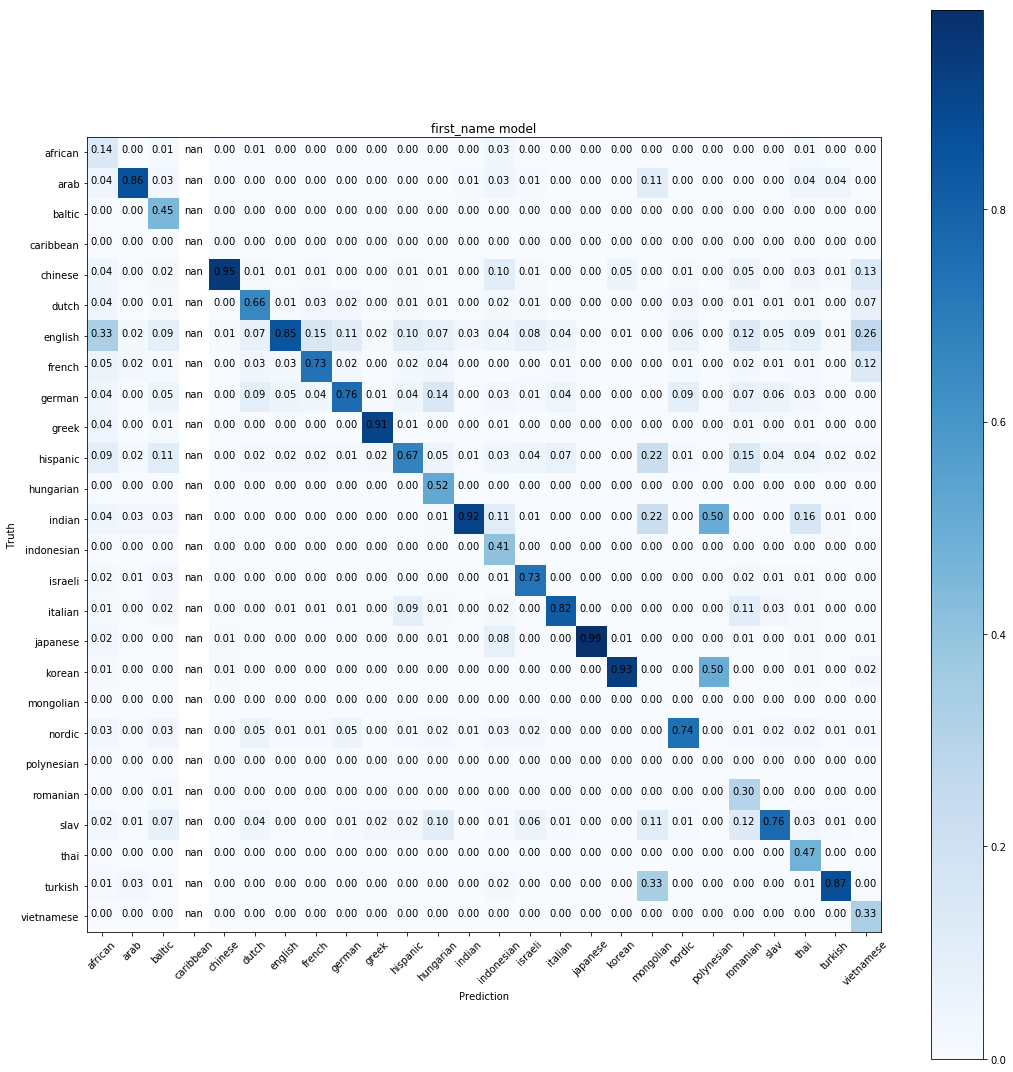

Normalized confusion matrix


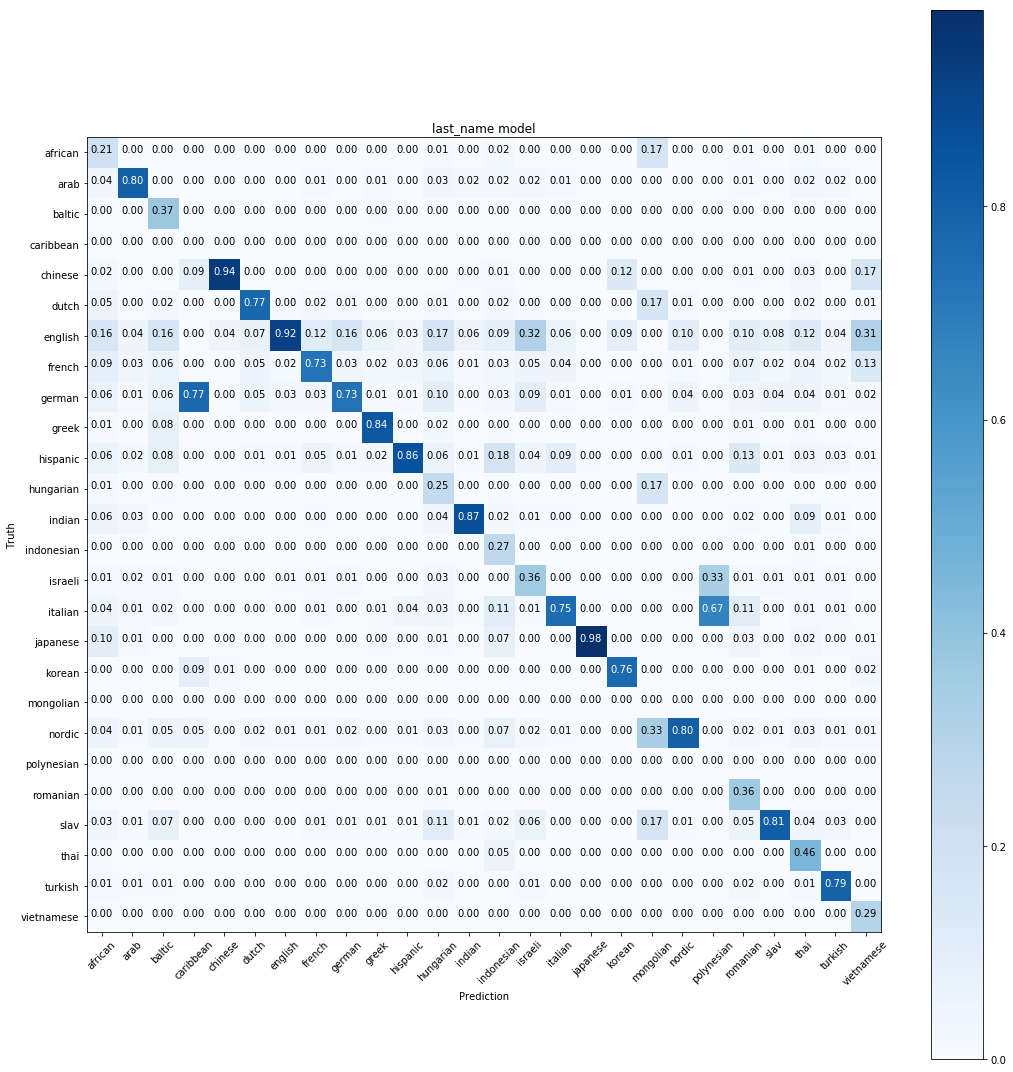

Normalized confusion matrix


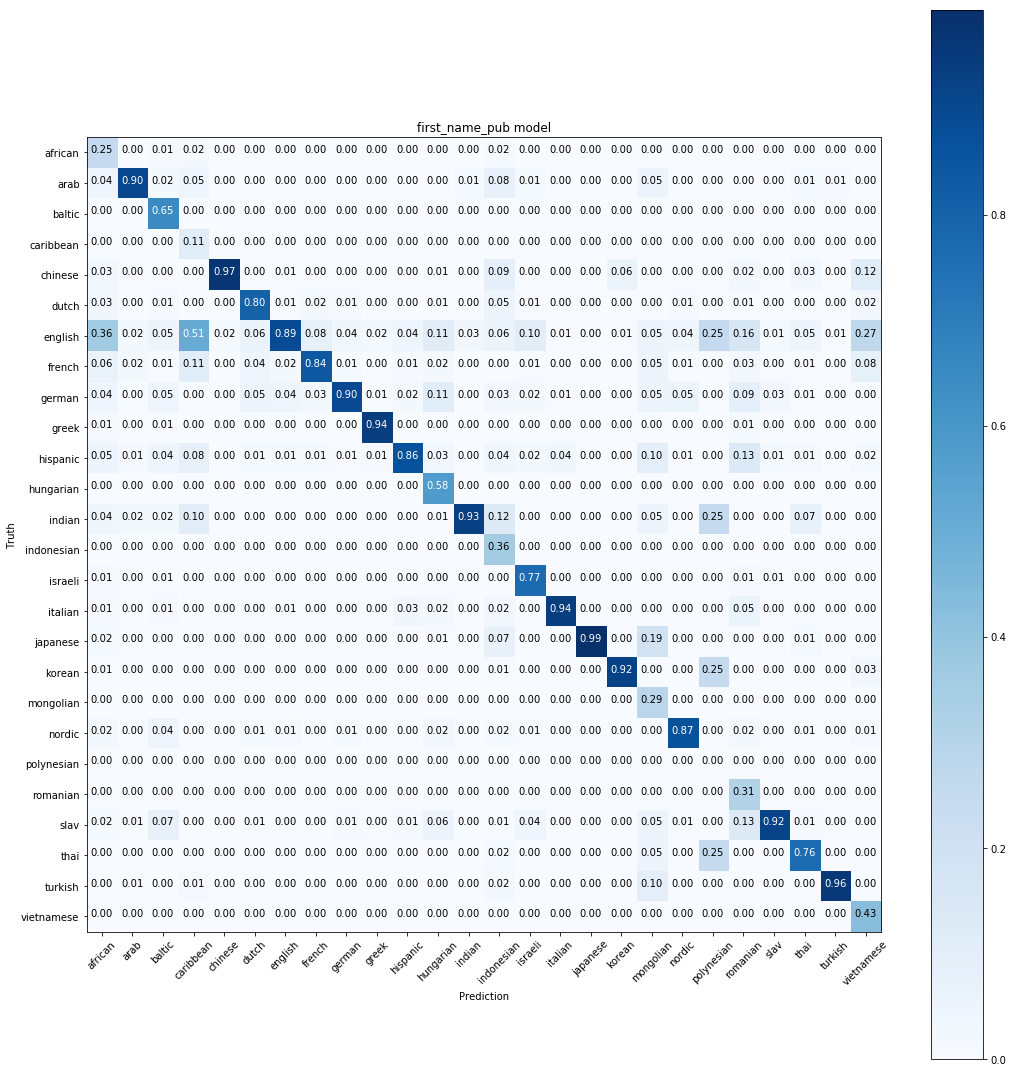

Normalized confusion matrix


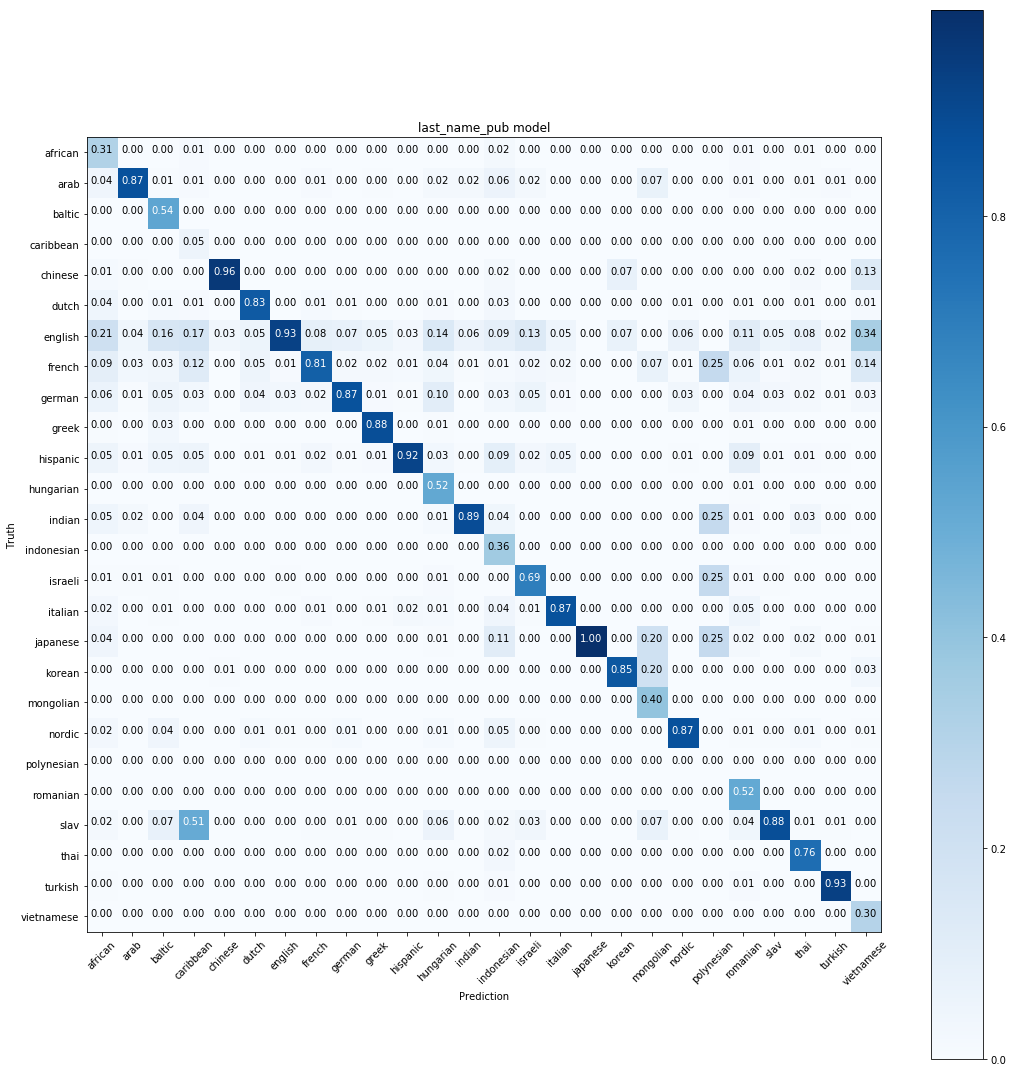

Normalized confusion matrix


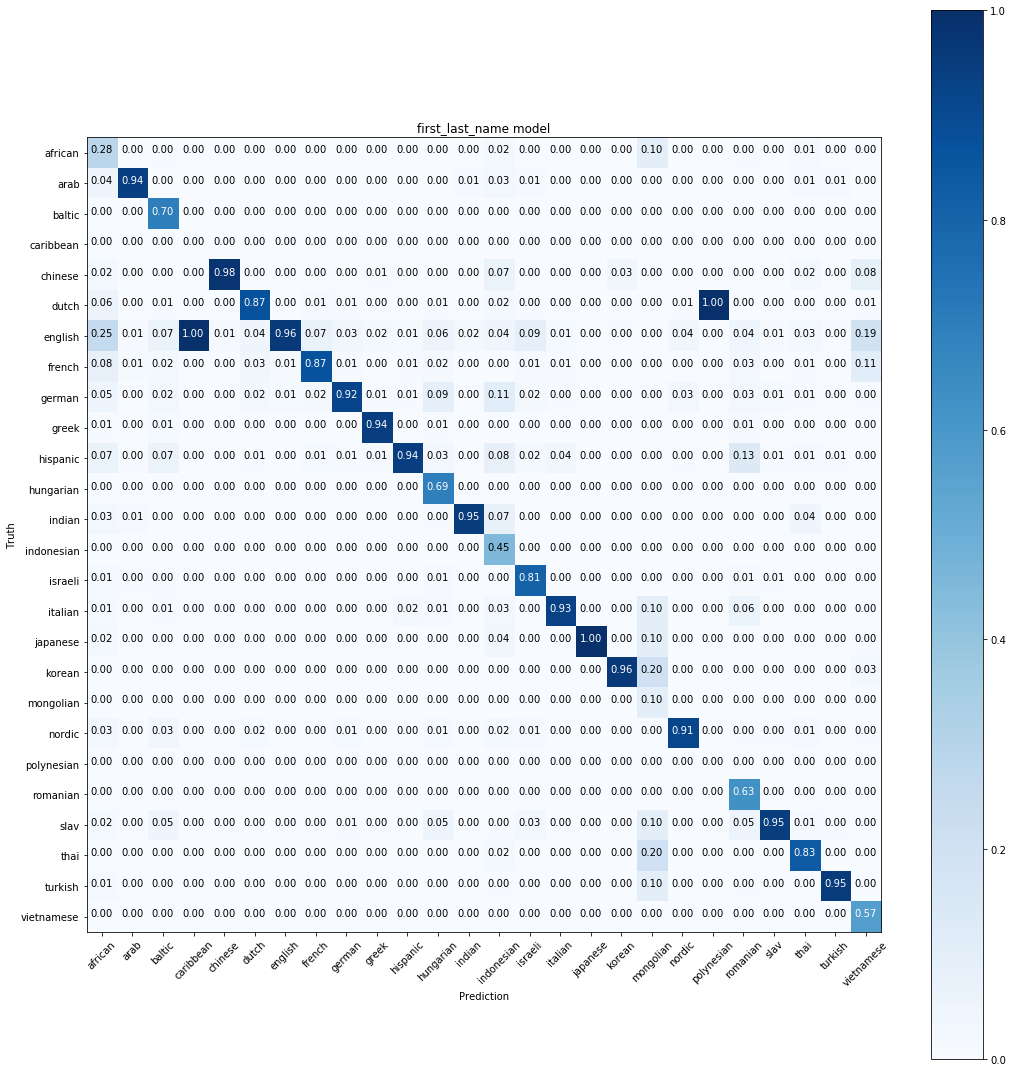

Normalized confusion matrix


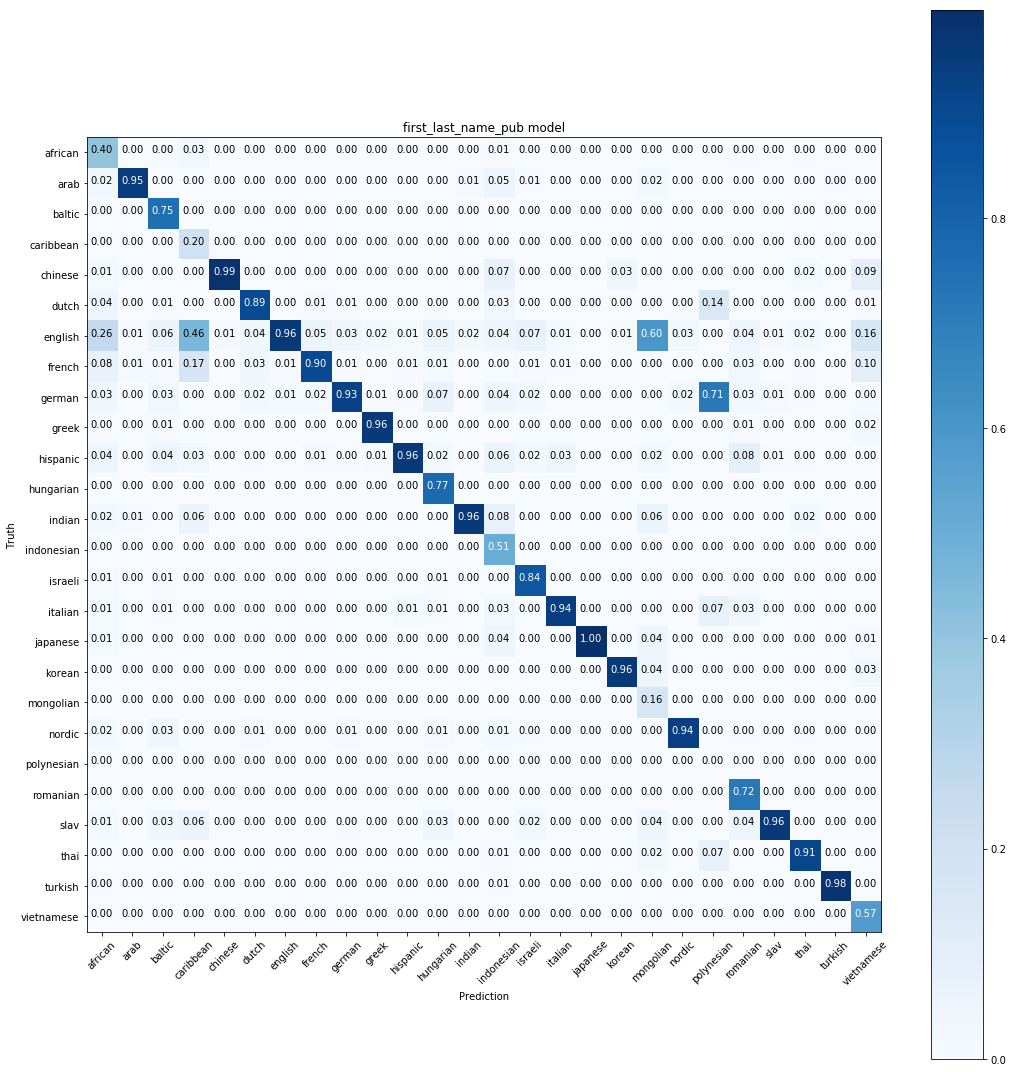

In [64]:
# Compute confusion matrix
for i in range(6):
    test_output = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,isotonic_test[i])
    #test_output_normal = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,pred_test_prob[4])
    cnf_matrix = confusion_matrix(test_labels,test_output)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


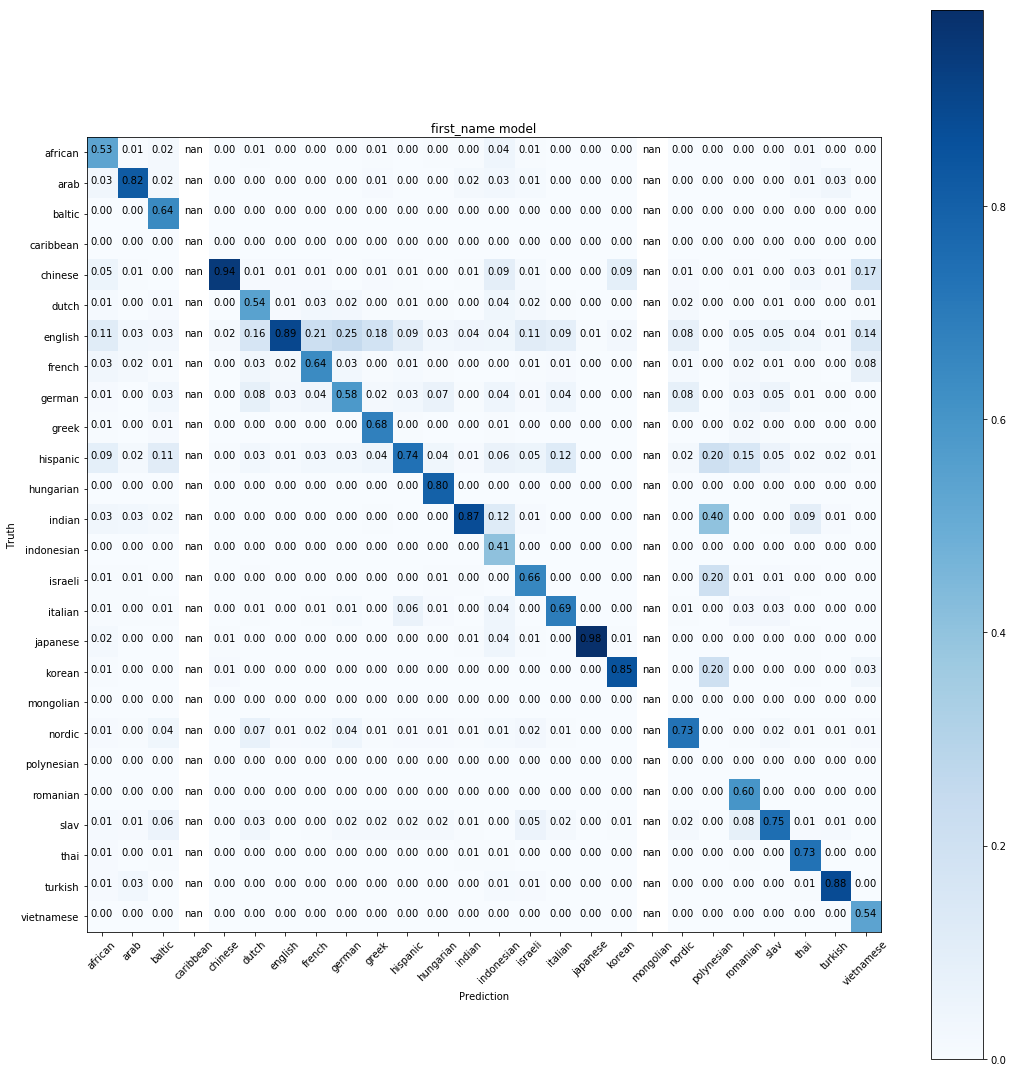

Normalized confusion matrix


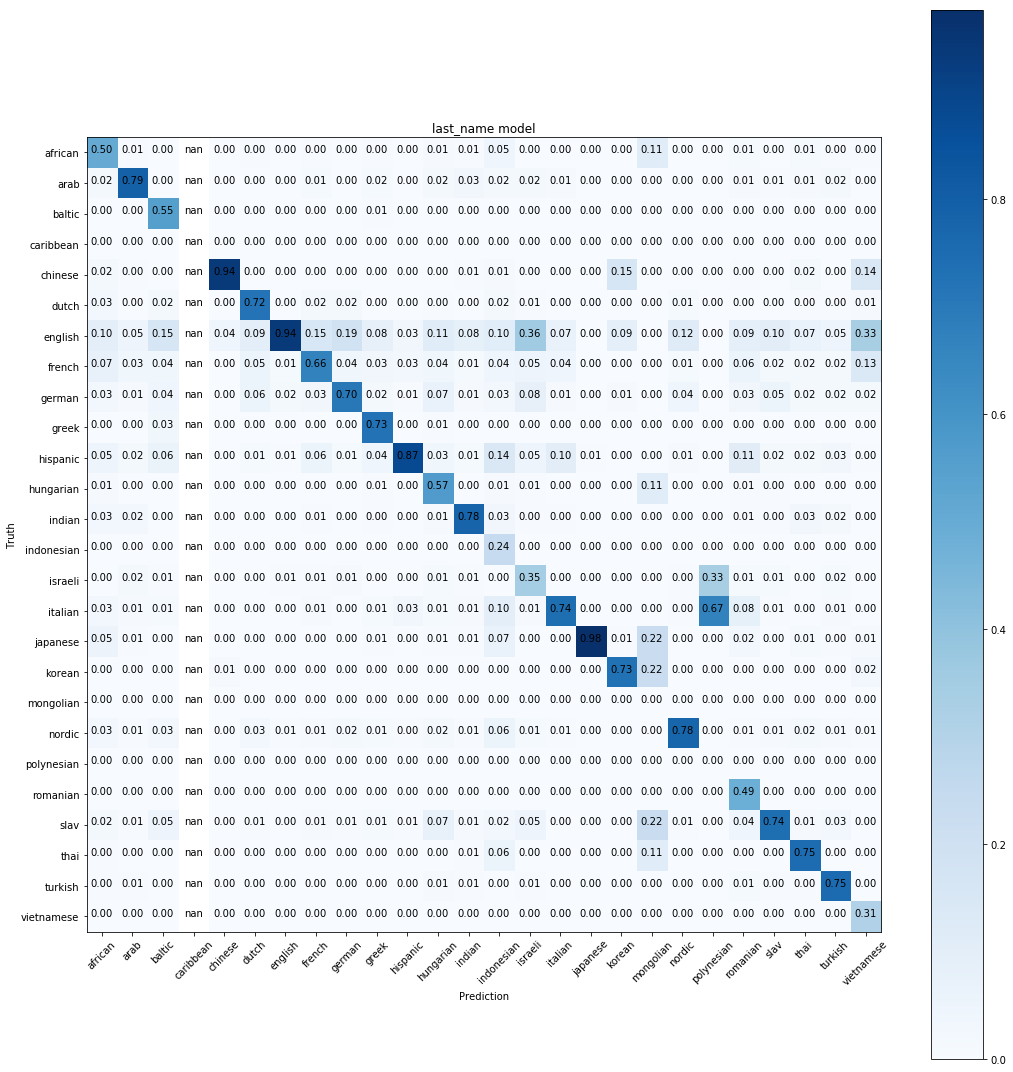

Normalized confusion matrix


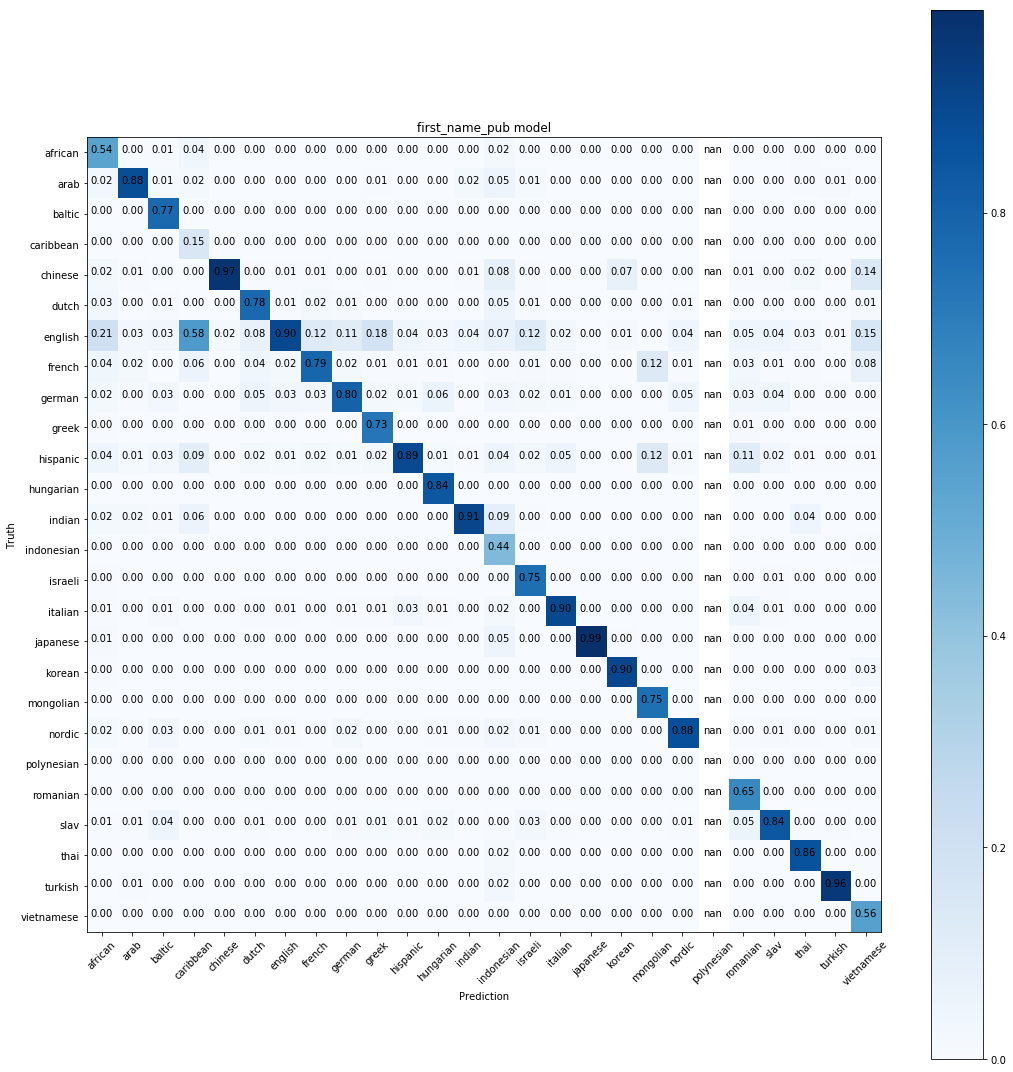

Normalized confusion matrix


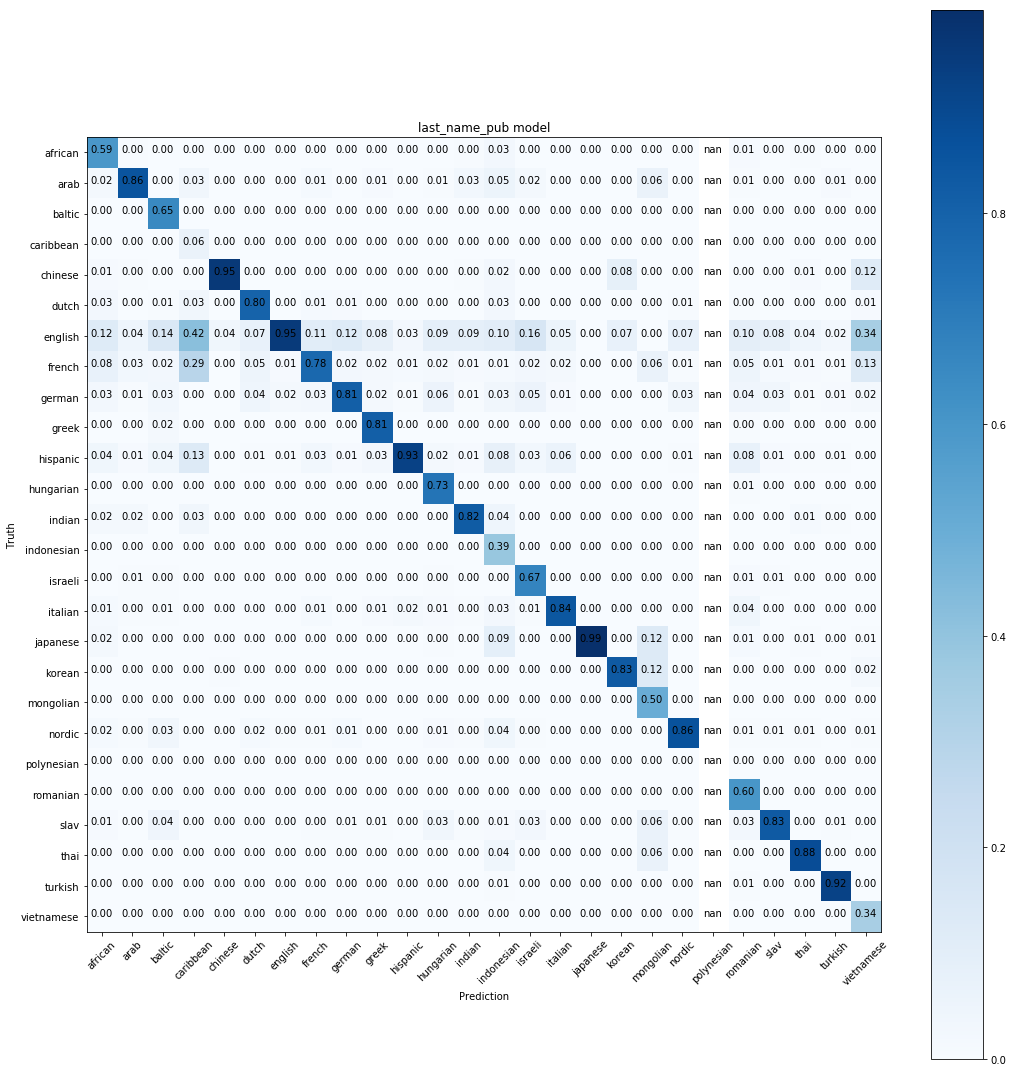

Normalized confusion matrix


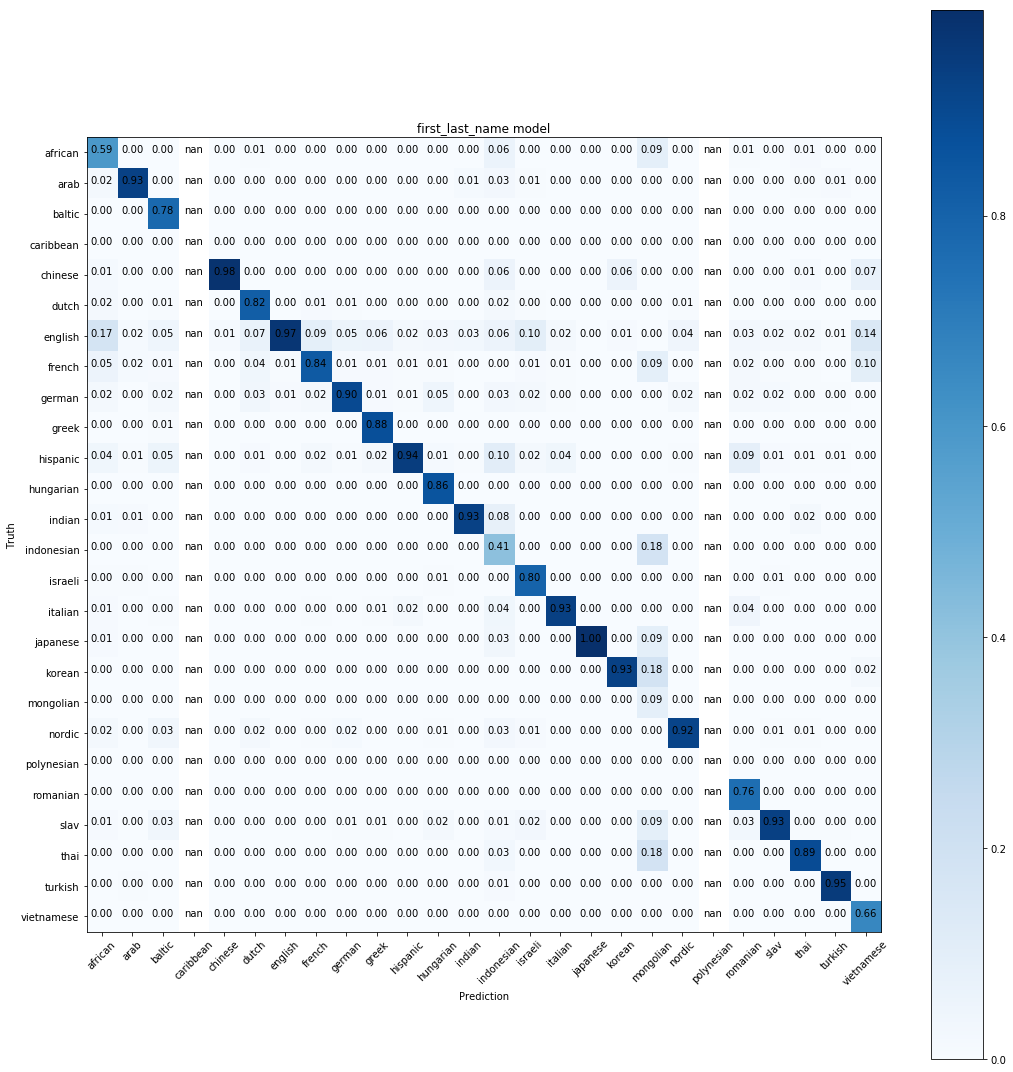

Normalized confusion matrix


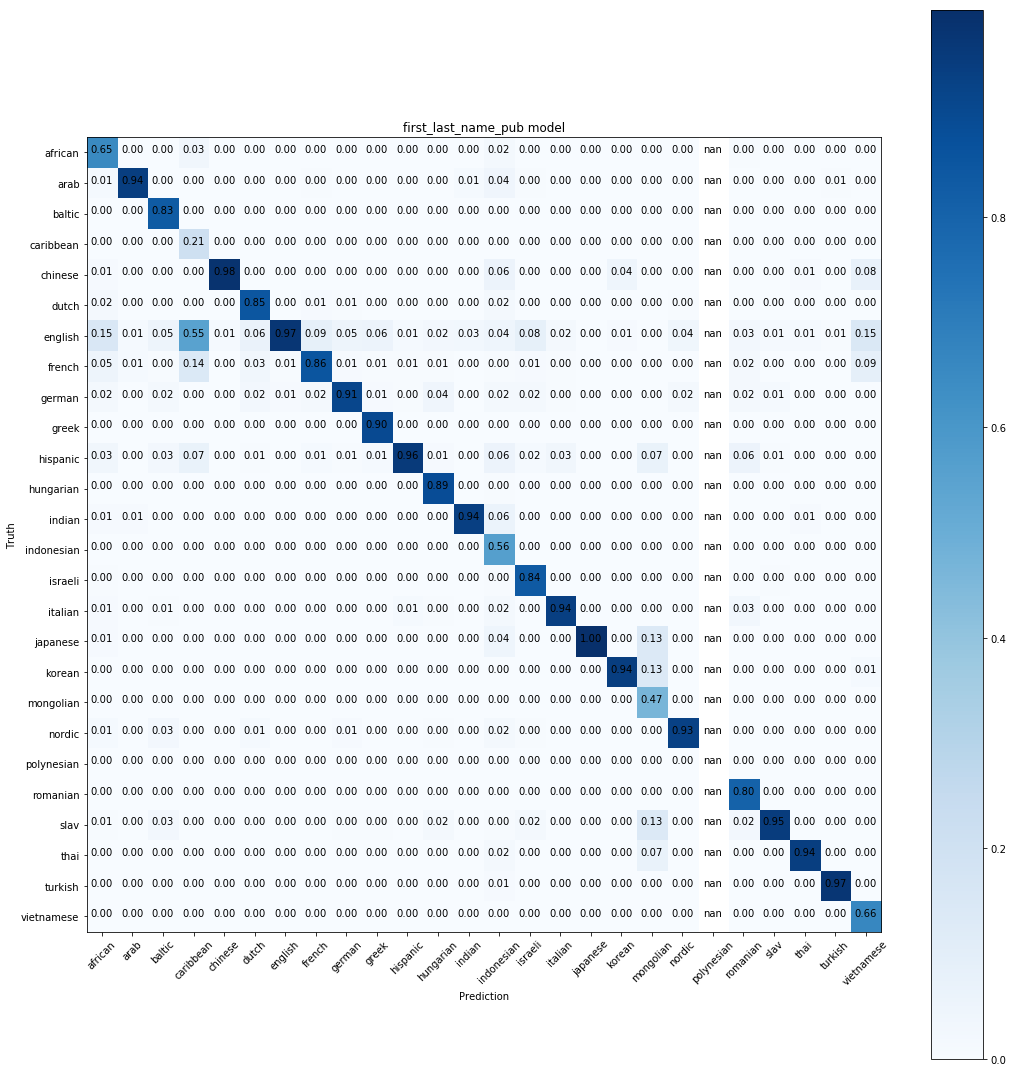

In [65]:
# Compute confusion matrix
for i in range(6):
    #test_output = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,isotonic_test[i])
    test_output_normal = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,pred_test_prob[i])
    cnf_matrix = confusion_matrix(test_labels,test_output_normal)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

Normalized confusion matrix


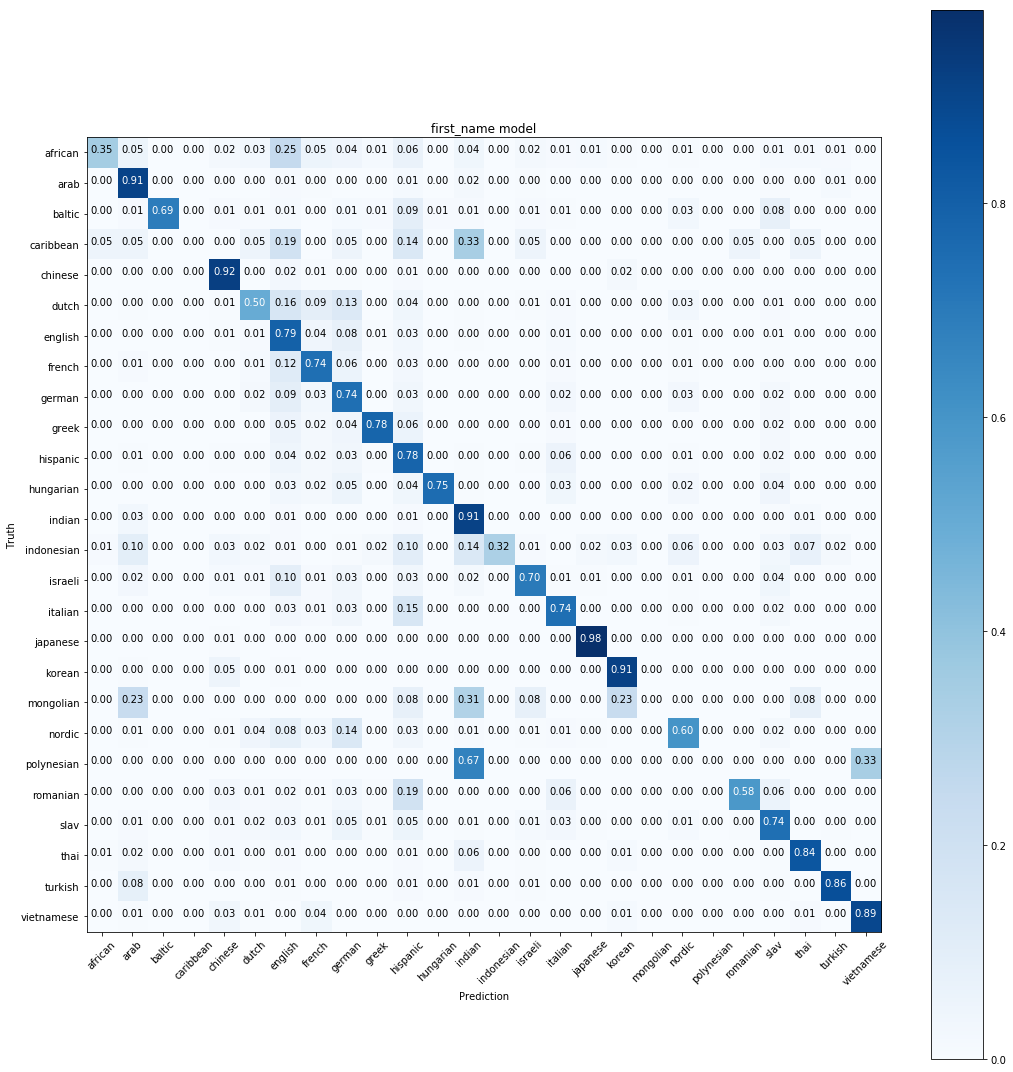

Normalized confusion matrix


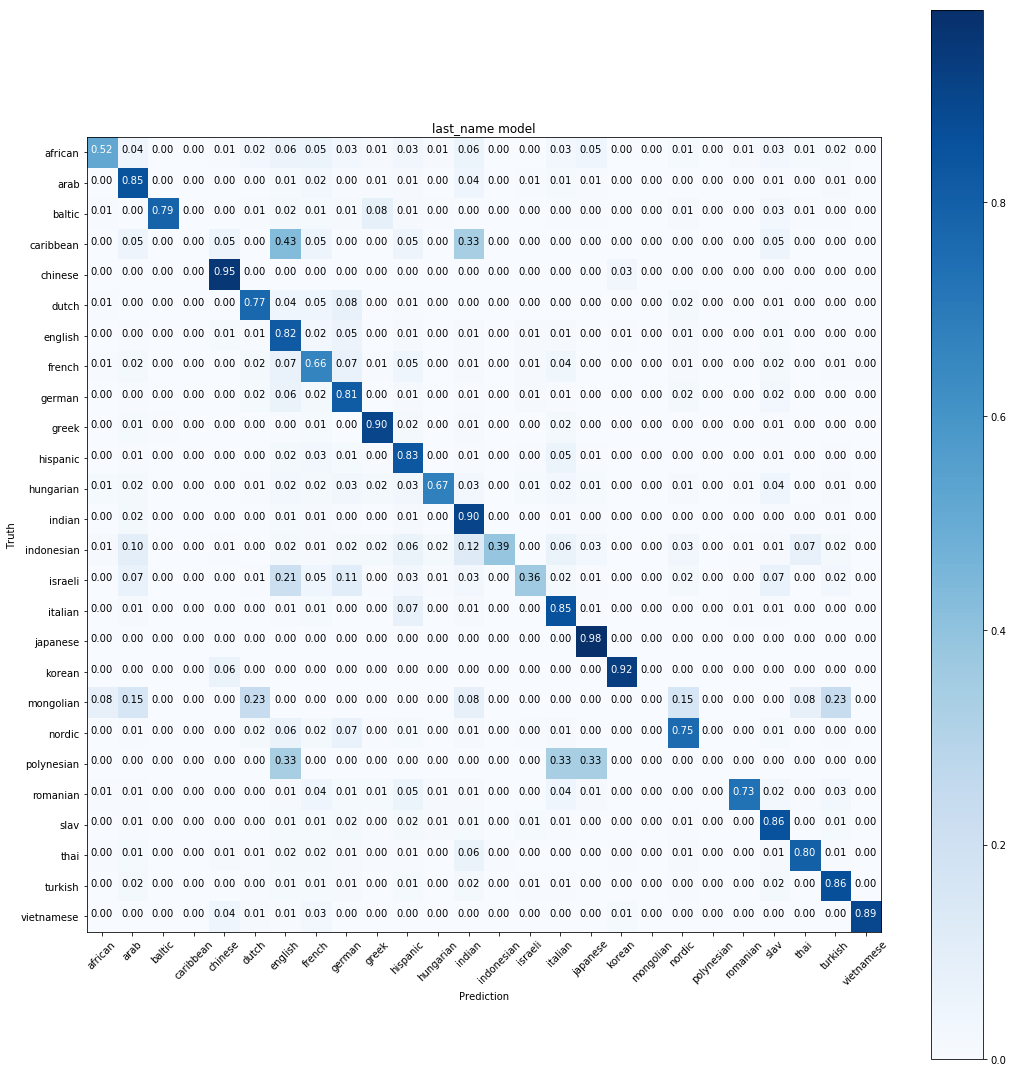

Normalized confusion matrix


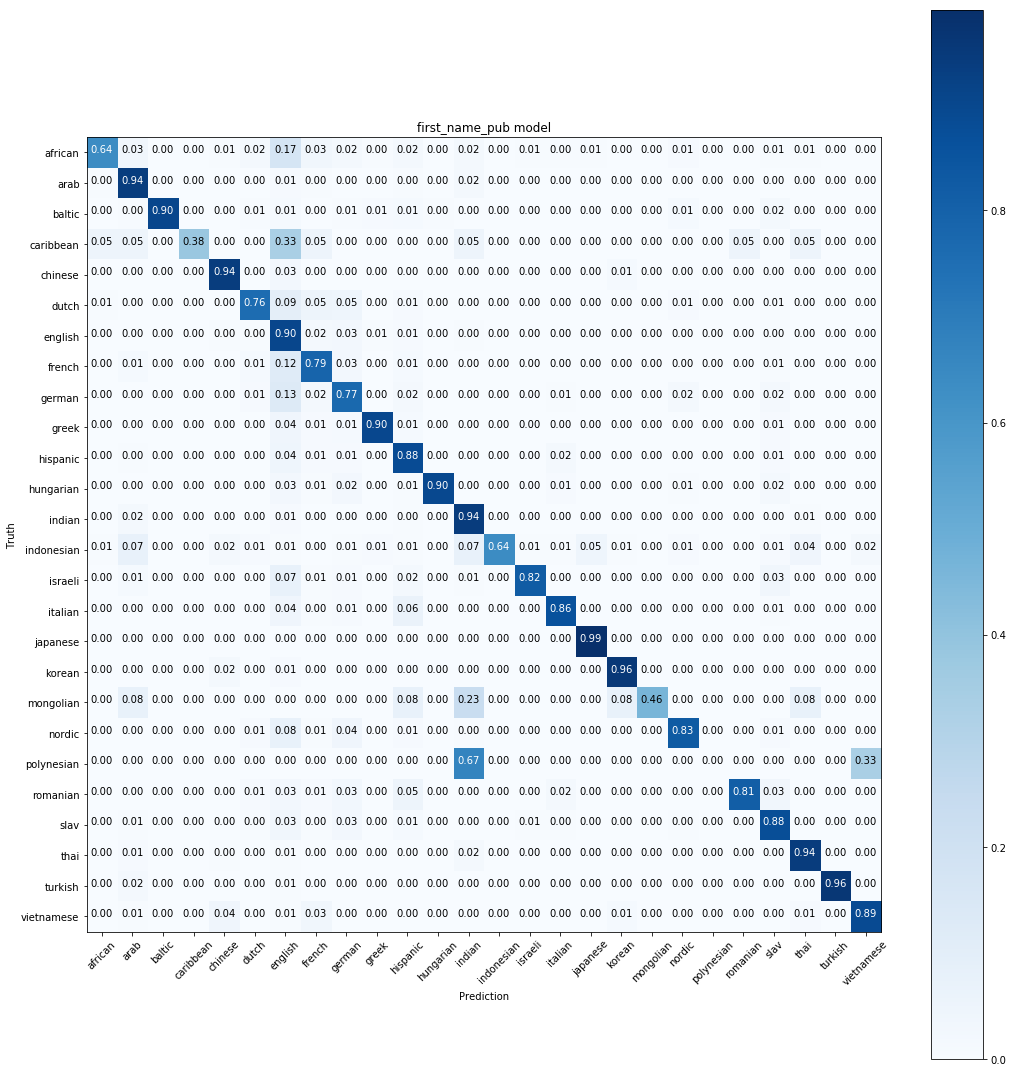

Normalized confusion matrix


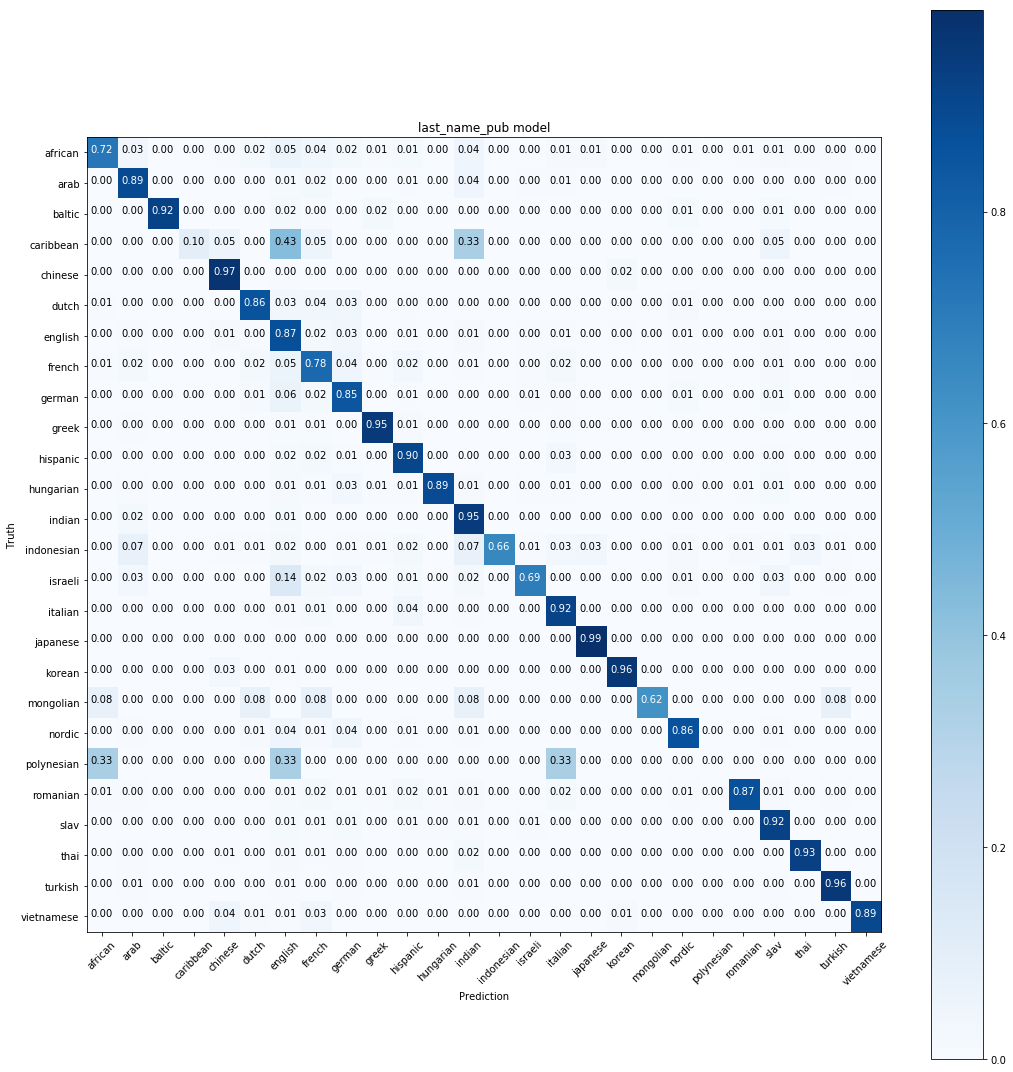

Normalized confusion matrix


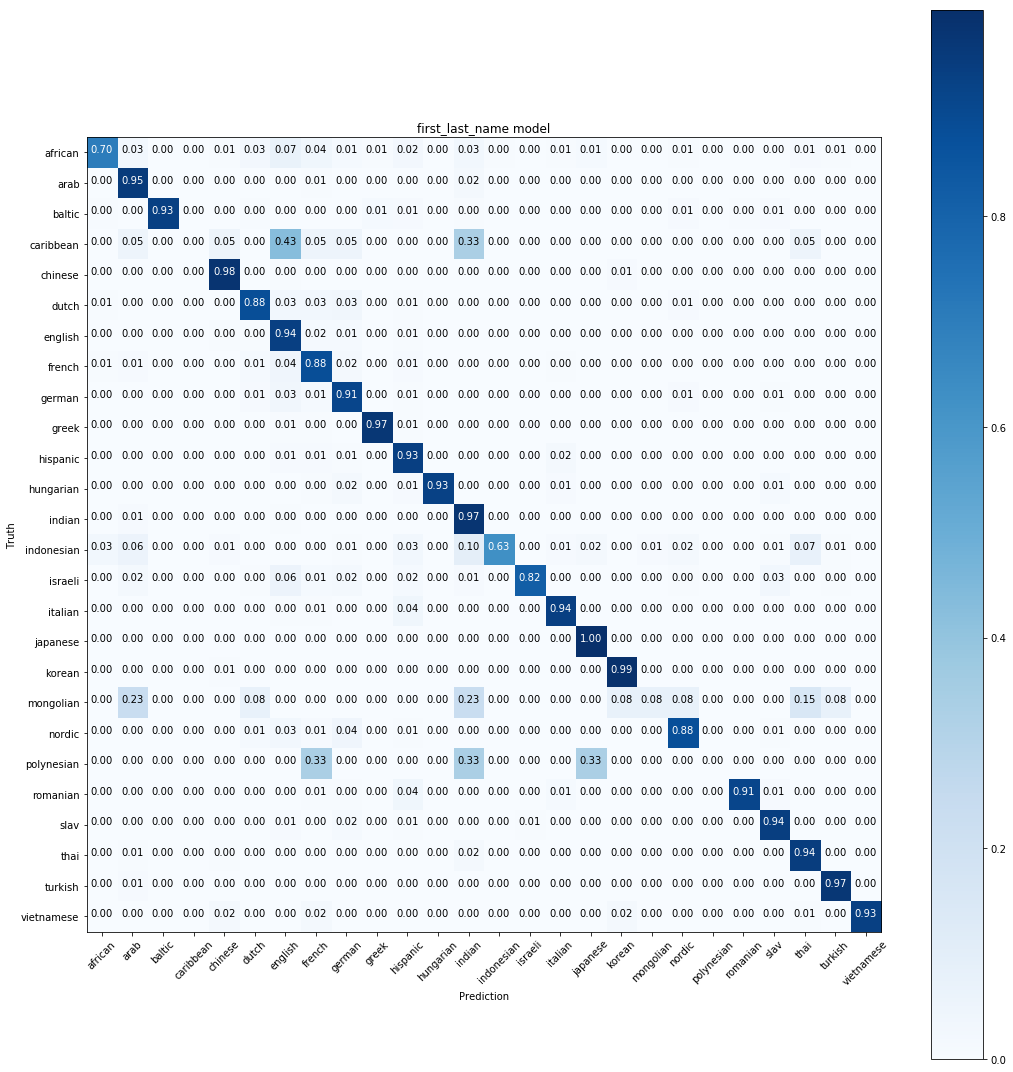

Normalized confusion matrix


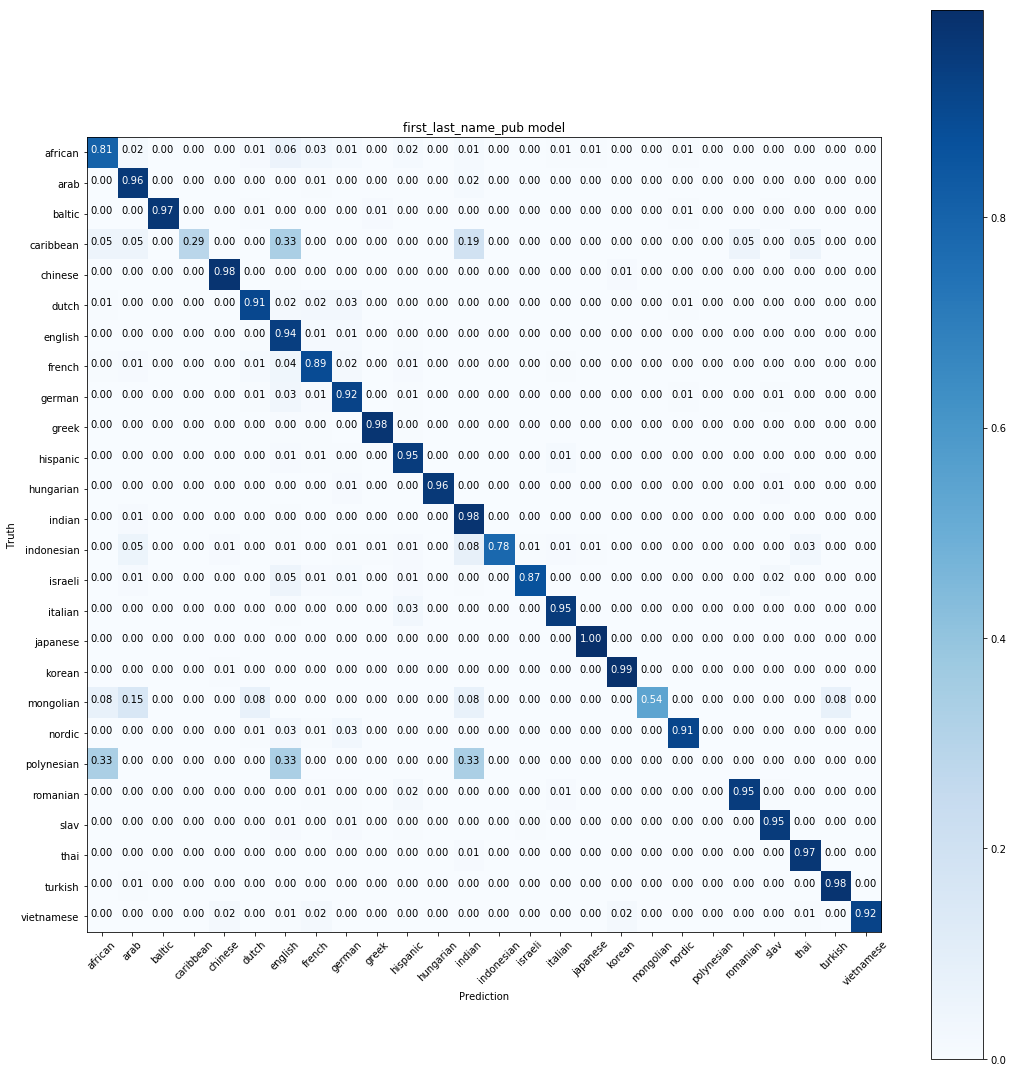

In [78]:
# Compute confusion matrix
for i in range(6):
    #test_output = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,isotonic_test[i])
    test_output_normal = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,pred_test_prob[i])
    cnf_matrix = confusion_matrix(test_labels,test_output_normal)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

Normalized confusion matrix


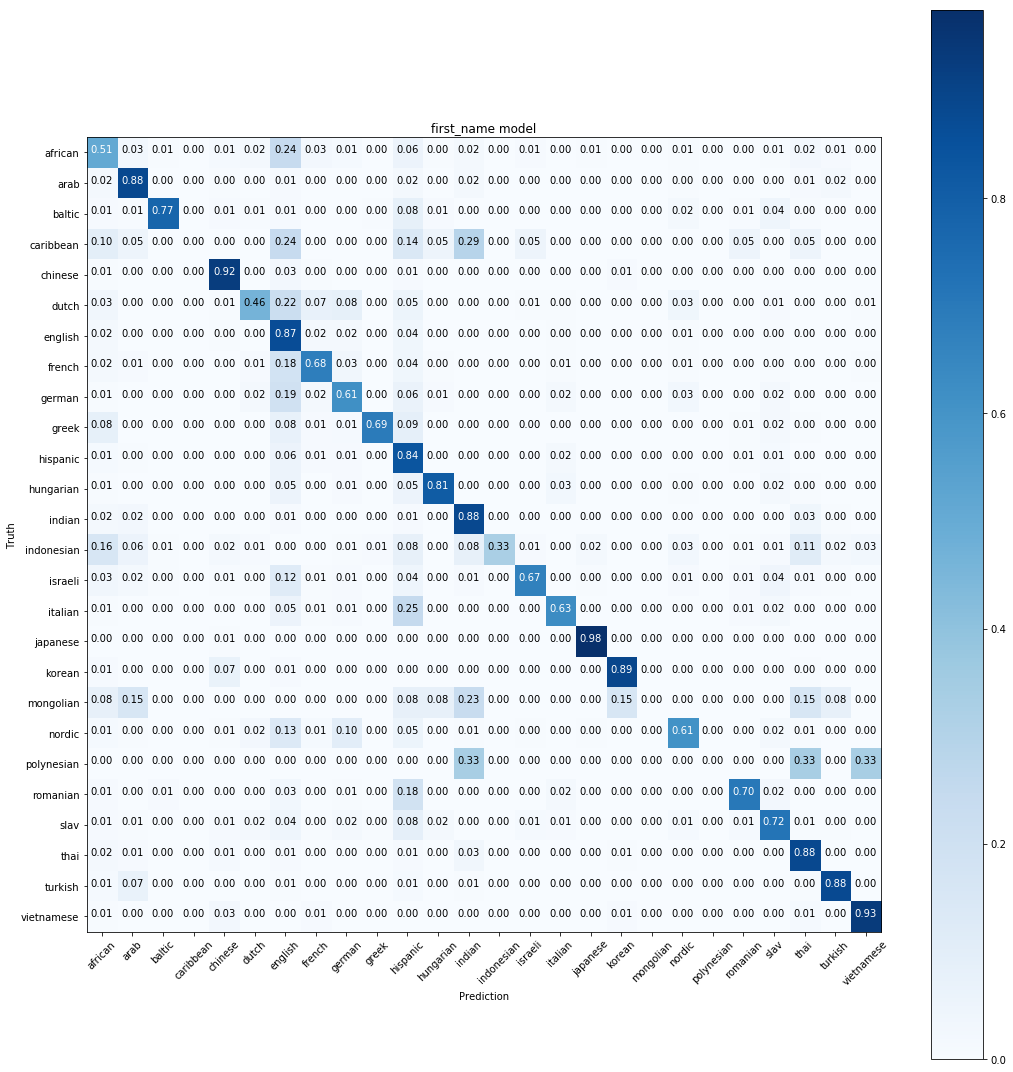

Normalized confusion matrix


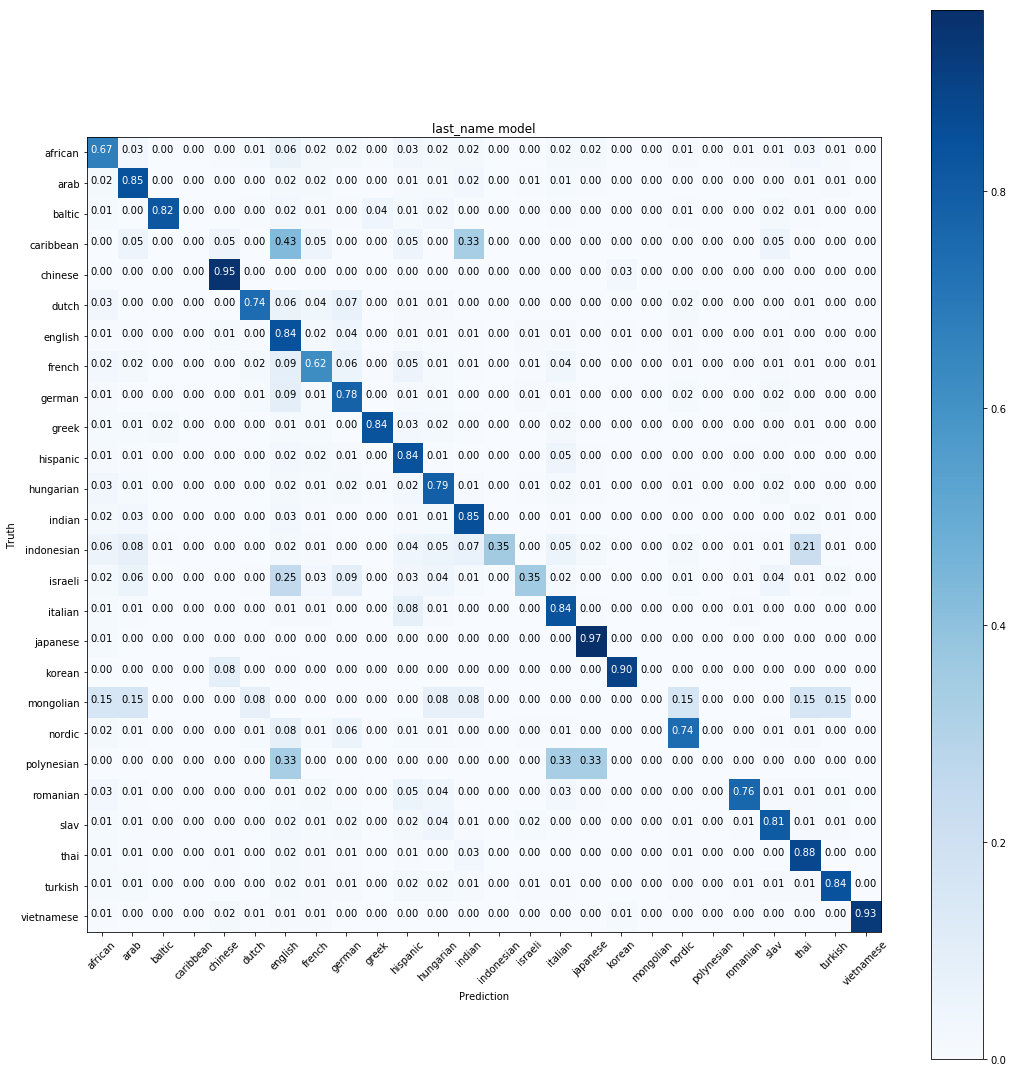

Normalized confusion matrix


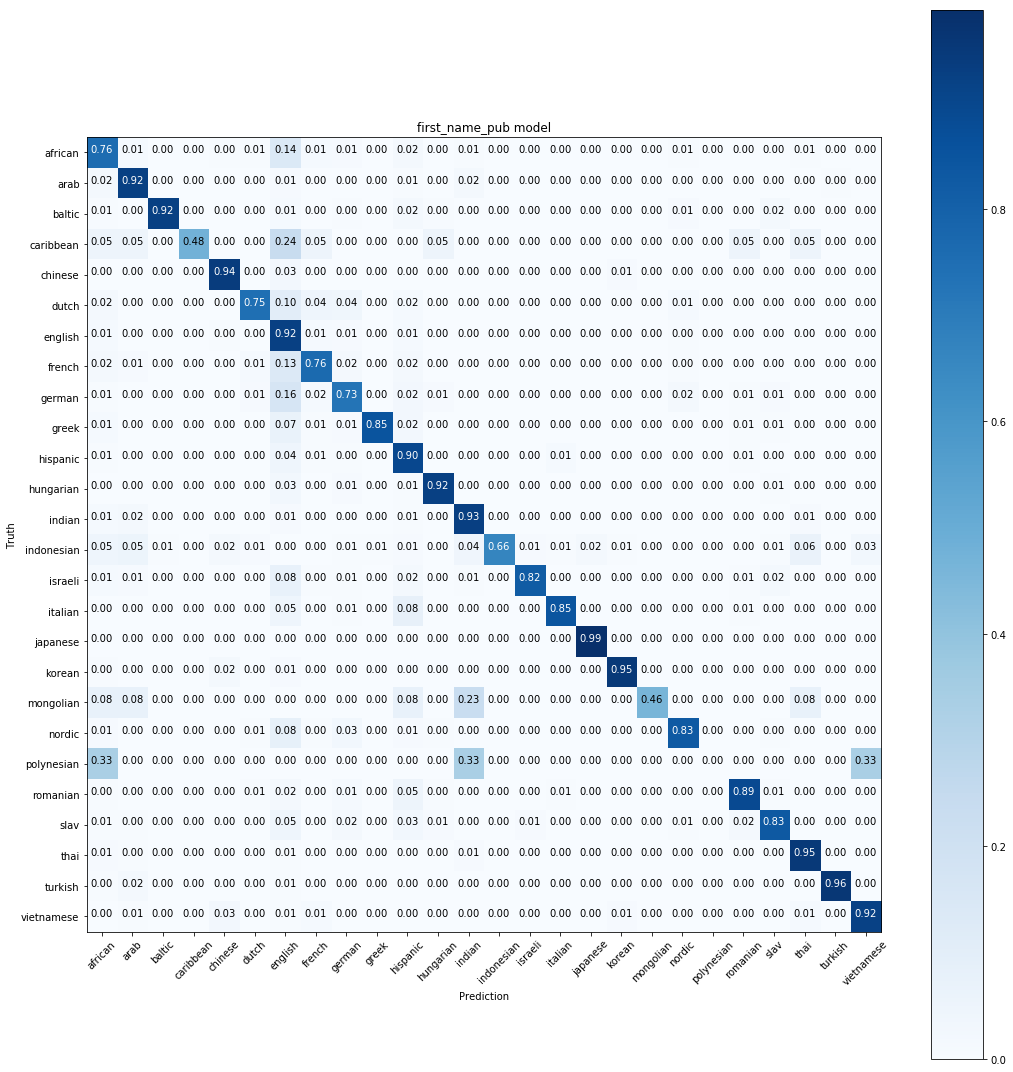

Normalized confusion matrix


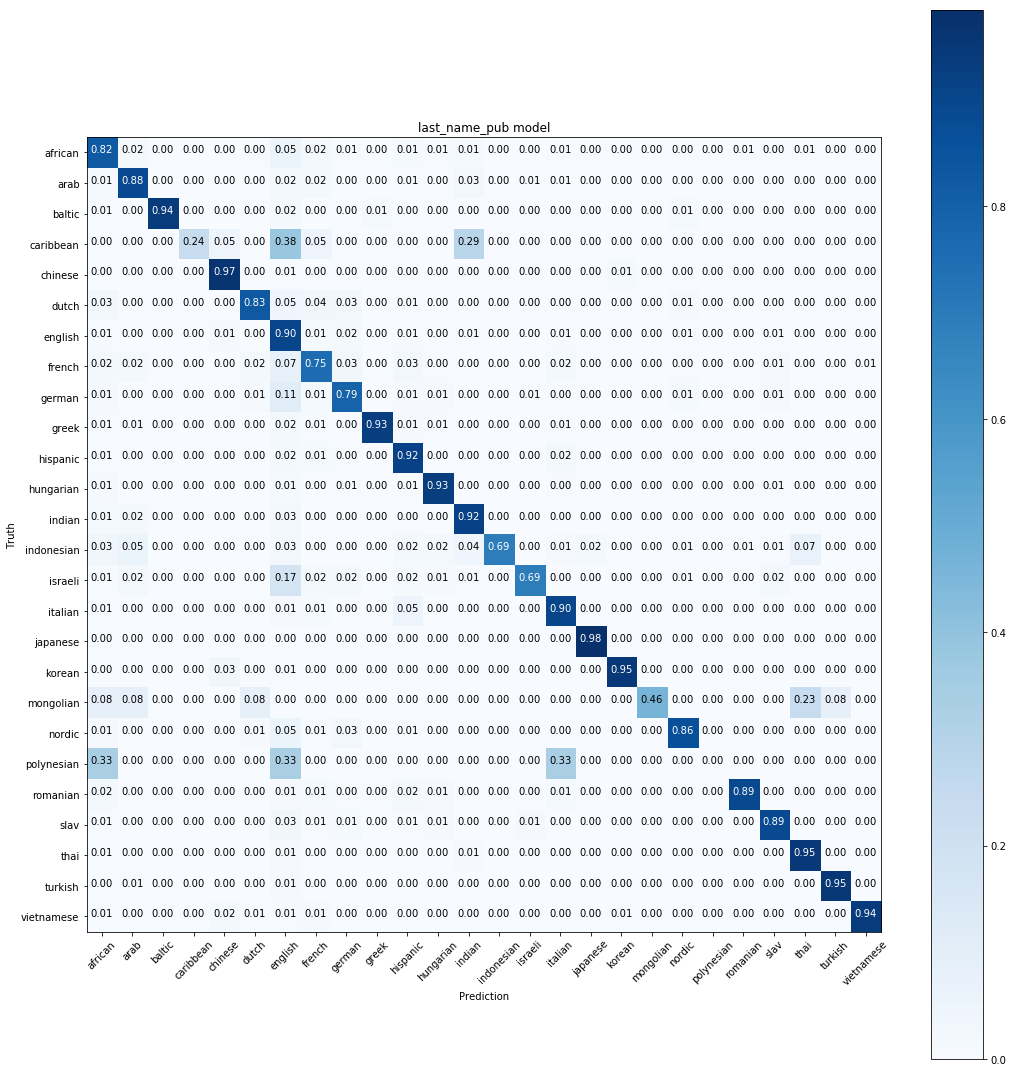

Normalized confusion matrix


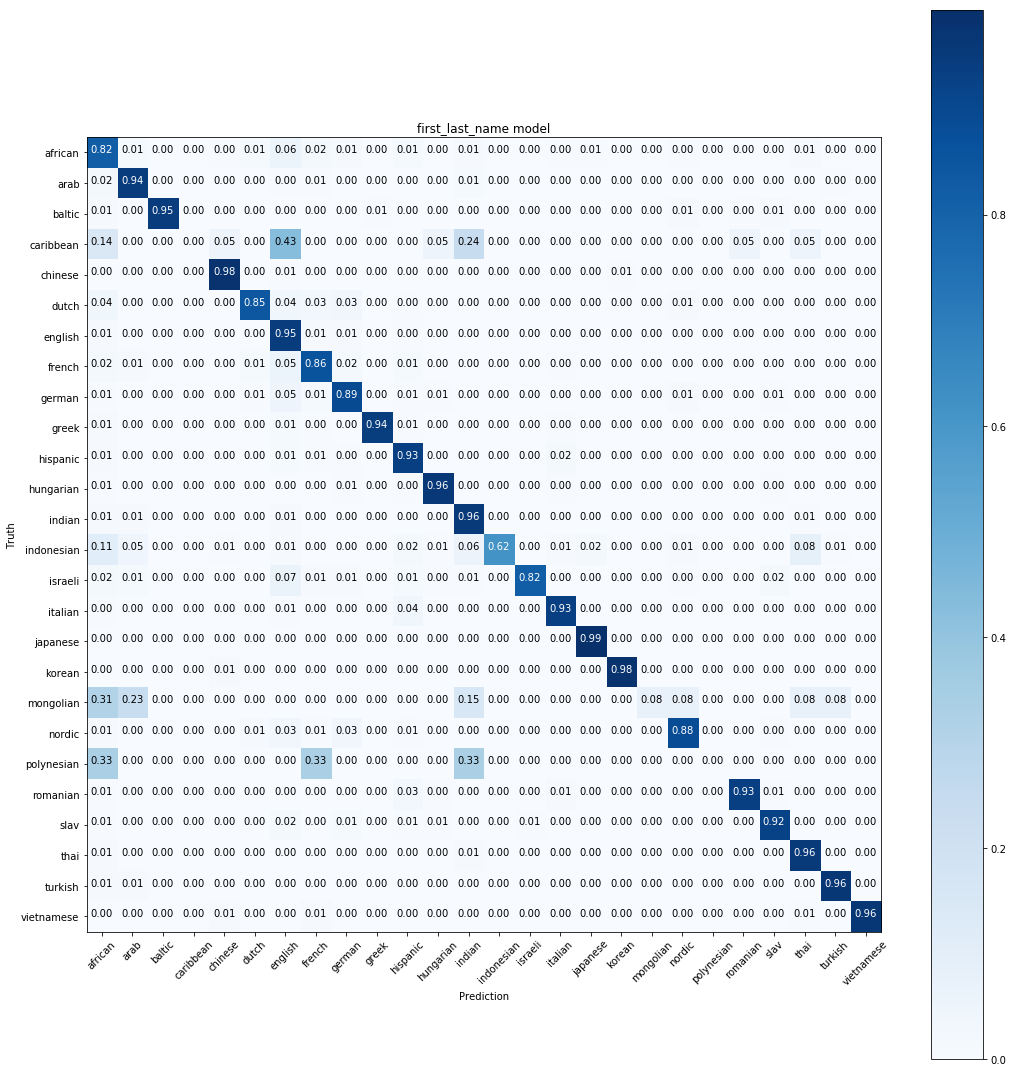

Normalized confusion matrix


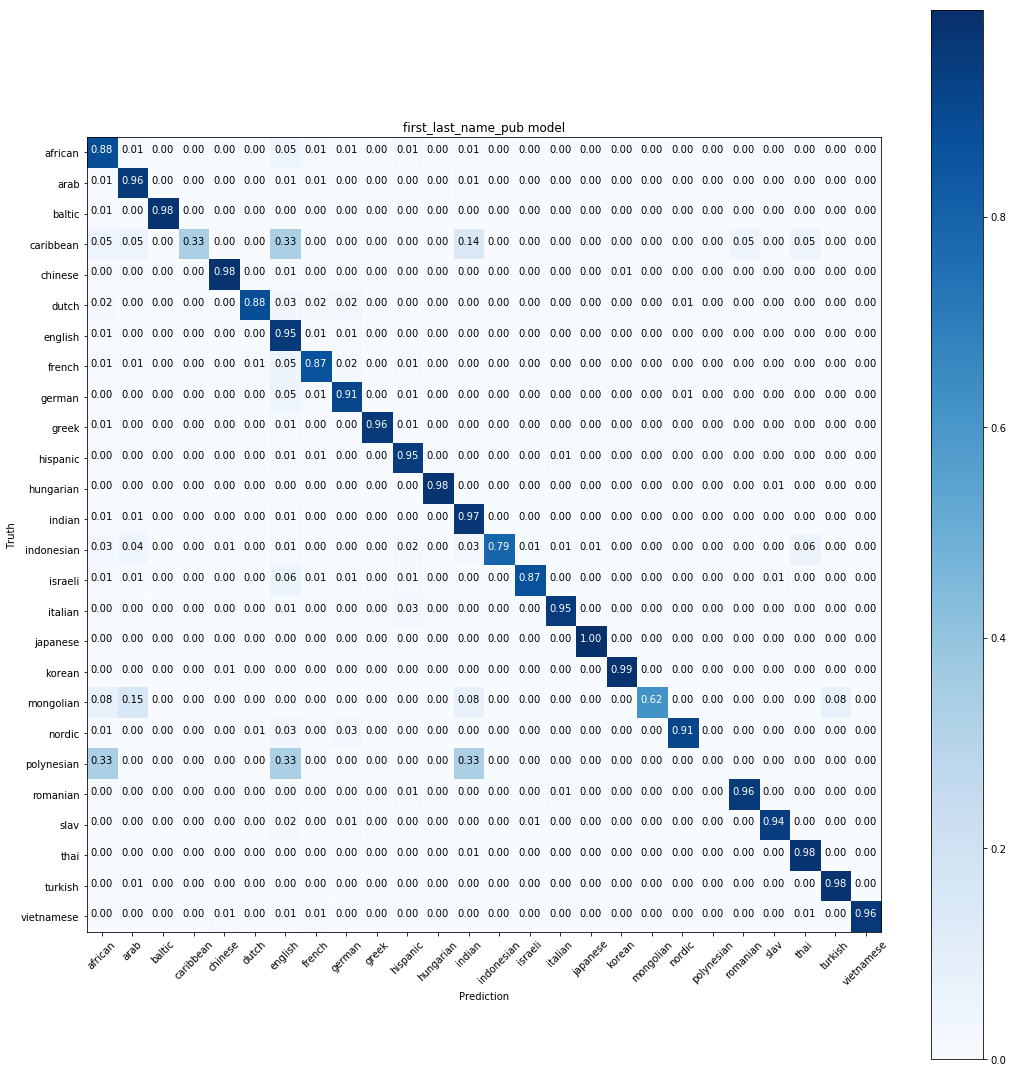

In [79]:
# Compute confusion matrix
for i in range(6):
    test_output = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,isotonic_test[i])
    #test_output_normal = np.apply_along_axis(lambda x: np.argsort(x)[::-1][0],1,pred_test_prob[4])
    cnf_matrix = confusion_matrix(test_labels,test_output)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

In [73]:
index = ["first_name","last_name","first_name_pub","last_name_pub","first_last_name","first_last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]

def trans_name(name):
    name = name.lower()
    # transform space into underscore
    name = '_'+name.replace(' ','_')+'_'
    #transform the name into sequence structure
    ext_name = extract_structure(name)
    trans_name = transform_structure(ext_name)
    """
    name_ds_mat = np.zeros((1,len(struct_dict_keys)),dtype=np.int32)
    for i,x in enumerate(trans_name):
        name_ds_mat[0,x-1]+=1
    """
    trans_name = pad_sequences([trans_name], maxlen=50,value=0.)
    #trans_name = trans_name.reshape(trans_name.shape[0],1,trans_name.shape[1])
    return trans_name

def predict_ethnicity_isotonic(fname="",lname="",pub="",first_last_name_model=first_last_name_model,is_sentence=True):
    # lower case the name
    if is_sentence:
        fnamex = np.array(trans_name(fname))
        lnamex = np.array(trans_name(lname))
        pub_country = transform_labels(pub.lower(),pub_keys).reshape(fnamex.shape[0],len(pub_keys))
    else:
        fnamex = fname
        lnamex = lname
        pub_country = pub
    preds = first_last_name_model.predict([fnamex,lnamex,pub_country])
    preds = isotonic_scale(isotonic_model,preds)
    return_item = {}
    p_fname  = {}
    p_lname = {}
    p_fname_pub = {}
    p_lname_pub = {}
    p_type = 0
    if fname!="" and lname=="":
        if np.sum(pub_country) == 0 :
            p_type = 1
        else:
            p_type = 2
    elif fname=="" and lname!="":
        if np.sum(pub_country) == 0 :
            p_type = 3
        else:
            p_type = 4
    elif np.sum(pub_country) == 0:
        p_type = 5

    outputs = {}
    outputs[0] = ["first_last_name","first_last_name_join","first_last_name_pub","first_name","first_name_pub","last_name","last_name_pub","first_pub_last_name_join","last_pub_first_name_join"]
    outputs[1] = ["first_name"]
    outputs[2] = ["first_name","first_name_pub"]
    outputs[3] = ["last_name"]
    outputs[4] = ["last_name","last_name_pub"]
    outputs[5] = ["first_last_name","first_last_name_join","first_name","last_name"]
        
    for i,pred in enumerate(preds):
        classes = []
        for x in np.argsort(pred[0])[::-1]:
            classes.append((ethnic_keys[x],pred[0][x]))
            if index[i] == "first_name":
                p_fname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name":
                p_lname[ethnic_keys[x]] = pred[0][x]
            if index[i] == "first_name_pub":
                p_fname_pub[ethnic_keys[x]] = pred[0][x]
            if index[i] == "last_name_pub":
                p_lname_pub[ethnic_keys[x]] = pred[0][x]

        return_item[index[i]] = classes
        
    # first name last name join prob
    join_result = {}
    join_result_pub = {}
    join_result_first_pub_last = {}
    join_result_last_pub_first = {}
    total = 0
    total_pub = 0
    total_first_pub_last = 0
    total_last_pub_first = 0
    
    for eth in ethnic_keys:
        join = p_fname[eth] * p_lname[eth]
        join_pub = p_fname_pub[eth] * p_lname_pub[eth]
        join_first_pub_last = p_fname_pub[eth] * p_lname[eth]
        join_last_pub_first = p_fname[eth] * p_lname_pub[eth]
        join_result[eth] = join
        join_result_pub[eth] = join_pub
        join_result_first_pub_last[eth] = join_first_pub_last
        join_result_last_pub_first[eth] = join_last_pub_first
        total += join
        total_pub += join_pub
        total_first_pub_last += join_first_pub_last
        total_last_pub_first += join_last_pub_first
        
    # normalize
    join_result_list = []
    join_pub_result_list = []
    join_first_pub_last_result_list = []
    join_last_pub_first_result_list = []
    for eth in ethnic_keys:
        join_result_list.append((eth,join_result[eth] / total))
        join_pub_result_list.append((eth,join_result_pub[eth]/total_pub))
        join_first_pub_last_result_list.append((eth,join_result_first_pub_last[eth]/total_first_pub_last))
        join_last_pub_first_result_list.append((eth,join_result_last_pub_first[eth]/total_last_pub_first))
    
    join_result_list = sorted(join_result_list, key=lambda x:x[1])[::-1]
    join_pub_result_list = sorted(join_pub_result_list, key=lambda x:x[1])[::-1]
    join_first_pub_last_result_list = sorted(join_first_pub_last_result_list, key=lambda x:x[1])[::-1]
    join_last_pub_first_result_list = sorted(join_last_pub_first_result_list, key=lambda x:x[1])[::-1]
    
    return_item["first_last_name_join"] = join_result_list
    return_item["first_last_name_pub_join"] = join_pub_result_list
    return_item["first_pub_last_name_join"] = join_first_pub_last_result_list
    return_item["last_pub_first_name_join"] = join_last_pub_first_result_list
    
    rendered_return = {}
    # render the output
    for key in outputs[p_type]:
        rendered_return[key] = return_item[key]
    
    return rendered_return

In [82]:
test = predict_ethnicity('Nikolaus','Parulian','indonesia')
pd.DataFrame(test)

first_last_name             first_last_name_join  \
0          (german, 0.998578)         (german, 0.998366284796)   
1         (slav, 0.000486488)      (french, 0.000501199303704)   
2       (french, 0.000465601)      (nordic, 0.000334741970053)   
3     (hispanic, 9.31162e-05)        (slav, 0.000328199213534)   
4       (nordic, 9.07019e-05)     (english, 0.000186633943838)   
5      (english, 9.00102e-05)    (hispanic, 0.000154497608684)   
6        (dutch, 8.62267e-05)       (dutch, 7.98468534463e-05)   
7      (israeli, 2.66442e-05)     (italian, 3.29342109162e-05)   
8    (hungarian, 2.35283e-05)       (greek, 6.29541460254e-06)   
9      (african, 1.98922e-05)        (arab, 4.79741780205e-06)   
10     (italian, 1.65683e-05)     (african, 2.25940056669e-06)   
11        (arab, 4.40625e-06)      (indian, 1.27136837346e-06)   
12     (chinese, 4.27591e-06)   (hungarian, 4.94813507517e-07)   
13     (turkish, 4.27556e-06)     (israeli, 3.26011385789e-07)   
14    (romanian, 2.79416e-06)    (romanian, 1.04861494093e-07)   
15       (greek, 2.65184e-06)     (turkish, 4.15172166704e-08)   
16      (indian, 1.85713e-06)     (chinese, 3.09636754482e-08)   
17    (japanese, 9.21757e-07)    (japanese, 1.99149452443e-08)   
18      (baltic, 8.91989e-07)        (thai, 1.55303629308e-08)   
19        (thai, 8.59674e-07)      (baltic, 1.88515746614e-09)   
20   (caribbean, 2.04483e-07)  (indonesian, 1.38815845817e-09)   
21      (korean, 8.43329e-08)       (korean, 1.3308773053e-09)   
22  (indonesian, 1.77747e-08)   (caribbean, 2.81834153788e-10)   
23   (mongolian, 1.08264e-09)    (mongolian, 9.1045739674e-14)   
24  (vietnamese, 1.07629e-10)  (vietnamese, 7.32249742362e-15)   
25  (polynesian, 5.98238e-16)  (polynesian, 3.81756000821e-29)   

          first_last_name_pub                 first_name  \
0          (german, 0.995102)         (german, 0.973451)   
1         (dutch, 0.00170244)        (nordic, 0.0127281)   
2        (french, 0.00104899)         (dutch, 0.0074633)   
3     (hispanic, 0.000587214)       (french, 0.00430211)   
4       (israeli, 0.00042643)     (english, 0.000587832)   
5         (slav, 0.000330396)       (greek, 0.000309063)   
6         (arab, 0.000177577)        (slav, 0.000307944)   
7     (indonesian, 9.321e-05)     (african, 0.000292743)   
8      (italian, 9.18029e-05)    (hispanic, 0.000243071)   
9      (english, 8.83232e-05)      (italian, 0.00018255)   
10    (japanese, 8.05383e-05)   (hungarian, 5.41094e-05)   
11      (nordic, 5.93083e-05)        (arab, 3.04459e-05)   
12       (greek, 5.59843e-05)      (korean, 9.35859e-06)   
13     (african, 4.00063e-05)     (chinese, 8.86521e-06)   
14     (turkish, 3.88108e-05)    (japanese, 8.52842e-06)   
15   (hungarian, 3.57049e-05)     (israeli, 7.96327e-06)   
16       (indian, 1.1074e-05)      (indian, 6.54527e-06)   
17     (chinese, 9.92122e-06)     (turkish, 4.92301e-06)   
18        (thai, 7.54649e-06)    (romanian, 5.85879e-07)   
19    (romanian, 7.11949e-06)         (thai, 5.8377e-07)   
20       (korean, 4.2379e-06)   (caribbean, 1.02645e-07)   
21   (caribbean, 6.49247e-07)  (indonesian, 3.82024e-08)   
22   (mongolian, 3.83181e-07)      (baltic, 3.75426e-08)   
23      (baltic, 2.50079e-07)   (mongolian, 1.05435e-09)   
24   (vietnamese, 1.4798e-08)  (vietnamese, 2.64038e-10)   
25  (polynesian, 1.01799e-12)  (polynesian, 8.25405e-22)   

               first_name_pub         first_pub_last_name_join  \
0           (german, 0.80014)         (german, 0.960079894265)   
1          (dutch, 0.0725409)          (slav, 0.0172306774566)   
2         (french, 0.0218733)       (hispanic, 0.012332665946)   
3      (indonesian, 0.021759)       (french, 0.00298132860835)   
4       (hispanic, 0.0165845)      (italian, 0.00281380365416)   
5           (slav, 0.0138188)         (arab, 0.00142621962539)   
6         (italian, 0.013331)   (indonesian, 0.00092502477581)   
7        (chinese, 0.0118173)       (dutch, 0.000907978092608)   
8          (arab

In [86]:
test = predict_ethnicity_isotonic('Jayanta','Bhattachrya','usa')
pd.DataFrame(test)

first_last_name            first_last_name_join  \
0          (indian, 0.985964912281)        (indian, 0.999871252741)   
1       (english, 0.00572441052201)       (thai, 8.89979231612e-05)   
2      (african, 0.000558763270628)    (english, 3.23295310536e-05)   
3      (chinese, 0.000339529751294)    (african, 7.12704086974e-06)   
4         (thai, 0.000190240654428)     (german, 1.38778105446e-07)   
5    (caribbean, 0.000184919791041)    (chinese, 5.94019766493e-08)   
6   (polynesian, 0.000101829537354)       (dutch, 4.2474988908e-08)   
7    (hungarian, 7.01385235841e-05)       (arab, 2.42188146989e-08)   
8       (german, 6.12107486075e-05)     (nordic, 1.53958163502e-08)   
9     (romanian, 1.74249420621e-05)  (caribbean, 1.24945302525e-08)   
10                     (greek, 0.0)               (vietnamese, 0.0)   
11                      (arab, 0.0)                  (turkish, 0.0)   
12                    (baltic, 0.0)                     (slav, 0.0)   
13                     (dutch, 0.0)                 (romanian, 0.0)   
14                    (french, 0.0)               (polynesian, 0.0)   
15                      (slav, 0.0)                (mongolian, 0.0)   
16                  (hispanic, 0.0)                   (korean, 0.0)   
17                   (turkish, 0.0)                 (japanese, 0.0)   
18                (indonesian, 0.0)                  (italian, 0.0)   
19                   (israeli, 0.0)                  (israeli, 0.0)   
20                   (italian, 0.0)               (indonesian, 0.0)   
21                  (japanese, 0.0)                (hungarian, 0.0)   
22                    (korean, 0.0)                 (hispanic, 0.0)   
23                 (mongolian, 0.0)                    (greek, 0.0)   
24                    (nordic, 0.0)                   (french, 0.0)   
25                (vietnamese, 0.0)                   (baltic, 0.0)   

                first_last_name_pub                       first_name  \
0          (indian, 0.982558139535)         (indian, 0.821180555556)   
1       (english, 0.00579642939949)           (thai, 0.141526217228)   
2         (thai, 0.000178157847853)       (english, 0.0221761097077)   
3      (african, 0.000174003828084)        (african, 0.021718764887)   
4      (chinese, 0.000112956060093)       (hungarian, 0.01048435386)   
5         (arab, 9.98668442077e-05)     (hispanic, 0.00365917407214)   
6       (german, 7.55287009063e-05)     (chinese, 0.000959990090425)   
7    (hungarian, 2.46087213308e-05)     (israeli, 0.000789889415482)   
8       (nordic, 2.11734315781e-05)      (french, 0.000663786919611)   
9   (polynesian, 1.89537528431e-05)     (italian, 0.000642369221834)   
10                  (romanian, 0.0)      (german, 0.000629987400252)   
11                    (baltic, 0.0)  (indonesian, 0.000559597090095)   
12                 (caribbean, 0.0)       (dutch, 0.000540373629767)   
13                     (dutch, 0.0)   (caribbean, 0.000539519827354)   
14                      (slav, 0.0)  (polynesian, 0.000392464678179)   
15                    (french, 0.0)     (romanian, 0.00025817555938)   
16                  (hispanic, 0.0)    (japanese, 0.000189464319899)   
17                     (greek, 0.0)        (arab, 0.000180212650928)   
18                   (turkish, 0.0)       (greek, 0.000128386185646)   
19                (indonesian, 0.0)      (nordic, 7.99948710028e-05)   
20                   (israeli, 0.0)        (slav, 5.04133897963e-05)   
21                   (italian, 0.0)  (vietnamese, 2.30489296367e-06)   
22                  (japanese, 0.0)                   (turkish, 0.0)   
23                    (korean, 0.0)                    (korean, 0.0)   
24                 (mongolian, 0.0)                 (mongolian, 0.0)   
25                (vietnamese, 0.0)                    (baltic, 0.0)   

                     first_name_pub        first_pub_last_name_join  \
0          (indian, 0.898096564531)        (indian, 0.999970399005)   
1        (engli

___
## Balancing Set for less representative

In [34]:
# class that have less than 90% precission
first_last_name_df = conf_table(pred_class[4],test_labels)

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
flname_less = first_last_name_df[(first_last_name_df.precision<0.90)|(pd.isnull(first_last_name_df.precision))]

In [390]:
# this might be due to the fact that these ethnicity doesn't have 
# enough representation in the dataset
# For further checking let us check the representation in the train set
x = pd.DataFrame(ethnic_series.iloc[trainIndex])
x = pd.DataFrame(x.Ethnea.value_counts())
#x.groupby(by="Ethnea").sum()

In [49]:
# print the distribution of the classes
x

Ethnea
english     1155275
japanese     350087
hispanic     342347
chinese      336731
german       287984
french       179371
italian      147994
indian       124010
slav         120474
nordic       113808
arab         106862
dutch         67764
korean        59086
turkish       42209
greek         30279
israeli       28474
african       14954
thai          14359
hungarian     12788
romanian       6142
baltic         3037
vietnamese     2379
indonesian      721
caribbean        61
mongolian        57
polynesian       15

In [61]:
display(flname_less)
x.loc[flname_less.index]

precision    recall                   precision-1  \
african      0.673335  0.669665     (african, 0.673335160318)   
baltic       0.880822  0.863087      (baltic, 0.880821917808)   
caribbean         NaN  0.000000             (vietnamese, nan)   
dutch        0.868111  0.867908       (dutch, 0.868111273792)   
indonesian   0.545455  0.474576  (indonesian, 0.545454545455)   
israeli      0.892978  0.765743     (israeli, 0.892977663506)   
mongolian    0.272727  0.230769        (slav, 0.272727272727)   
polynesian        NaN  0.000000             (vietnamese, nan)   
romanian     0.856669  0.848226    (romanian, 0.856668878567)   
vietnamese   0.847670  0.874307  (vietnamese, 0.847670250896)   

                            precision-2                  precision-3  \
african      (english, 0.0690600164429)    (french, 0.0624828720197)   
baltic        (nordic, 0.0260273972603)  (hispanic, 0.0219178082192)   
caribbean                (turkish, nan)                  (arab, nan)   
dutch         (french, 0.0389458272328)   (english, 0.0267642752562)   
indonesian      (thai, 0.0714285714286)    (indian, 0.0649350649351)   
israeli      (english, 0.0271573196208)      (slav, 0.0223364936526)   
mongolian   (mongolian, 0.272727272727)       (arab, 0.181818181818)   
polynesian               (turkish, nan)                  (arab, nan)   
romanian    (hispanic, 0.0497677504977)   (italian, 0.0185799601858)   
vietnamese    (french, 0.0663082437276)   (chinese, 0.0304659498208)   

                                recall-1                     recall-2  \
african         (african, 0.66966475879)    (english, 0.128645407468)   
baltic          (baltic, 0.863087248322)  (hispanic, 0.0214765100671)   
caribbean       (english, 0.52380952381)     (indian, 0.285714285714)   
dutch             (dutch, 0.86790795714)   (english, 0.0431524093917)   
indonesian  (indonesian, 0.474576271186)     (indian, 0.118644067797)   
israeli        (israeli, 0.765743420146)    (english, 0.110238390519)   
mongolian       (indian, 0.384615384615)  (mongolian, 0.230769230769)   
polynesian  (vietnamese, 0.333333333333)   (japanese, 0.333333333333)   
romanian      (romanian, 0.848226018397)  (hispanic, 0.0427069645204)   
vietnamese  (vietnamese, 0.874306839187)   (chinese, 0.0443622920518)   

                               recall-3  
african     (hispanic, 0.0280730444263)  
baltic       (english, 0.0201342281879)  
caribbean        (arab, 0.047619047619)  
dutch         (german, 0.0377656771474)  
indonesian      (arab, 0.0677966101695)  
israeli         (slav, 0.0250792338432)  
mongolian       (arab, 0.0769230769231)  
polynesian     (indian, 0.333333333333)  
romanian     (italian, 0.0308804204993)  
vietnamese   (english, 0.0406654343808)

Ethnea
african      14954
baltic        3037
caribbean       61
dutch        67764
indonesian     721
israeli      28474
mongolian       57
polynesian      15
romanian      6142
vietnamese    2379

In [388]:
# we compute the class weight base on the distribution
# default weight
list(zip(ethnic_keys,custom_weight))

[('african', 0.34365102127462011),
 ('arab', 0.62426981255105107),
 ('baltic', 0.63128731584478781),
 ('caribbean', 0.63652985275846286),
 ('chinese', 0.68829742811161232),
 ('dutch', 0.8721359964920925),
 ('english', 0.96014820056377614),
 ('french', 1.0488948977542185),
 ('german', 1.0641764933222122),
 ('greek', 1.0948986767707887),
 ('hispanic', 1.129922554050935),
 ('hungarian', 1.4189294731048483),
 ('indian', 1.5195606248831051),
 ('indonesian', 1.797867968863796),
 ('israeli', 2.1227046075854705),
 ('italian', 2.1889512333811121),
 ('japanese', 3.0205194625568863),
 ('korean', 3.0824655305702966),
 ('mongolian', 3.2663221258078816),
 ('nordic', 4.7130866087798635),
 ('polynesian', 6.7025170993958172),
 ('romanian', 7.5729154067388595),
 ('slav', 13.756016694729082),
 ('thai', 47.292841557124568),
 ('turkish', 48.924106033192864),
 ('vietnamese', 95.370640001831674)]

In [78]:
x.loc[flname_less.index]
# custom weight calculation
y = np.sqrt(x.sum()) / np.sqrt(26 * x)
custom_weight = y.Ethnea.values

In [406]:
#np.log10(x)
1155275/x

Ethnea
english         1.000000
japanese        3.299965
hispanic        3.374573
chinese         3.430854
german          4.011594
french          6.440701
italian         7.806229
indian          9.315983
slav            9.589413
nordic         10.151088
arab           10.810906
dutch          17.048507
korean         19.552432
turkish        27.370348
greek          38.154331
israeli        40.572979
african        77.255249
thai           80.456508
hungarian      90.340554
romanian      188.094269
baltic        380.400066
vietnamese    485.613703
indonesian   1602.323162
caribbean   18938.934426
mongolian   20267.982456
polynesian  77018.333333

In [105]:
t = pd.DataFrame(ethnic_series.iloc[trainIndex])
#.loc[flname_less.index]

Series([], Name: Ethnea, dtype: object)

In [112]:
ethnea_less = ethnea_df.iloc[trainIndex][t.Ethnea.apply(lambda x: x in flname_less.index)]
#flname_less.index.values

In [120]:
ethnea_less.Ethnea.value_counts()

DUTCH         67764
ISRAELI       28474
AFRICAN       14954
ROMANIAN       6142
BALTIC         3037
VIETNAMESE     2379
INDONESIAN      721
CARIBBEAN        61
MONGOLIAN        57
POLYNESIAN       15
Name: Ethnea, dtype: int64

In [162]:
# Train model for the less representation
json_file = open('model-keras-w7-bigram-integration-full-lstm-embedding-cw.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
fl_model_less = model_from_json(loaded_model_json)
fl_model_less.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [164]:
f_less_struct = ethnea_less.First.apply(lambda x: extract_structure(x.lower(),2))
l_less_struct = ethnea_less.Last.apply(lambda x: extract_structure(x.lower(),2))
x = ethnea_less.Ethnea.str.lower()
ethnic_less = x.value_counts().index.values.tolist()
labels_less = np.array(list(map(lambda x: transform_labels(x,ethnic_keys),ethnea_less.Ethnea.str.lower())))

In [160]:
mini_batch_size = 10000
sample = OverSample(ethnea_less.Ethnea.str.lower(),ethnic_less,mini_batch_size,1)
# custom weight less
x = ethnea_less.Ethnea.value_counts()
y = np.sqrt(x.sum()) / np.sqrt(26 * x)
cw_less = y.values

In [166]:
first_trainX = f_less_struct
last_trainX = l_less_struct
trainY = labels_less

mini_batch_size = 10000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 1000

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[ethnea_less.index].iloc[nextList])))        
        fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-less-checkpoint.h5')    

batch 12
Epoch 1/1
10004/10004 [==============================] - 52s - loss: 17.9816 - first_name_output_loss: 2.7767 - last_name_output_loss: 2.5538 - first_name_pub_output_loss: 3.1364 - last_name_pub_output_loss: 3.1050 - first_last_name_output_loss: 3.2097 - first_last_name_pub_output_loss: 3.2000 - first_name_output_acc: 0.4792 - last_name_output_acc: 0.5481 - first_name_pub_output_acc: 0.4357 - last_name_pub_output_acc: 0.5317 - first_last_name_output_acc: 0.2292 - first_last_name_pub_output_acc: 0.1092    
batch 11
Epoch 1/1
10004/10004 [==============================] - 52s - loss: 15.1586 - first_name_output_loss: 1.6626 - last_name_output_loss: 1.6383 - first_name_pub_output_loss: 2.9548 - last_name_pub_output_loss: 2.8809 - first_last_name_output_loss: 3.0392 - first_last_name_pub_output_loss: 2.9828 - first_name_output_acc: 0.5481 - last_name_output_acc: 0.5481 - first_name_pub_output_acc: 0.5492 - last_name_pub_output_acc: 0.6053 - first_last_name_output_acc: 0.5481 - fir

In [172]:
for x in range(3):
    #sample.reset()
    #nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys),pub_series[ethnea_less.index].iloc[nextList])))        
        fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()
        first_last_name_model.save_weights('model-keras-w7-bigram-integration-full-lstm-embedding-less-checkpoint.h5')    

batch 5
Epoch 1/1
10004/10004 [==============================] - 57s - loss: 1.6621 - first_name_output_loss: 0.5055 - last_name_output_loss: 0.4062 - first_name_pub_output_loss: 0.2330 - last_name_pub_output_loss: 0.1865 - first_last_name_output_loss: 0.2216 - first_last_name_pub_output_loss: 0.1093 - first_name_output_acc: 0.8403 - last_name_output_acc: 0.8658 - first_name_pub_output_acc: 0.9241 - last_name_pub_output_acc: 0.9428 - first_last_name_output_acc: 0.9311 - first_last_name_pub_output_acc: 0.9639    
batch 4
Epoch 1/1
10004/10004 [==============================] - 57s - loss: 1.7087 - first_name_output_loss: 0.5030 - last_name_output_loss: 0.4078 - first_name_pub_output_loss: 0.2596 - last_name_pub_output_loss: 0.2010 - first_last_name_output_loss: 0.2160 - first_last_name_pub_output_loss: 0.1213 - first_name_output_acc: 0.8422 - last_name_output_acc: 0.8680 - first_name_pub_output_acc: 0.9175 - last_name_pub_output_acc: 0.9398 - first_last_name_output_acc: 0.9355 - first_l

In [195]:
x = predict_ethnicity("Nikolaus","Parulian",first_last_name_model=fl_model_less)['first_last_name']
# rebuild the probability matrix
list(map(lambda x: x[1],sorted(x,key=lambda x: ethnic_keys.index(x[0]))))

# add first_last_name less probability into our first_last_name model
#first_last_name_model
# first_last_name_pub
fl_less_model_input = Input(shape=(len(ethnic_keys),),name='fl_less_model_input') 

merge_first_last_name_less = keras.layers.concatenate([first_last_name_output,fl_less_model_input],name='merge_first_last_name_less')
#merge_first_last_name_less_hidden = Dense(100, activation='relu',name='hidden_first_last_name_pub_1')(merge_first_last_name_pub)
first_last_name_less_output = Dense(len(ethnic_keys),activation='softmax',name='first_last_name_less_output')(merge_first_last_name_less)
first_last_name_less_merge_model = Model(inputs=[first_name_input,last_name_input,fl_less_model_input], outputs=[first_last_name_output,first_last_name_less_output])
first_last_name_less_merge_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [196]:
first_last_name_less_merge_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2_input (InputLayer)   (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_last_name_input (Input (None, 50)            0                                            
____________________________________________________________________________________________________
embedding_first_name (Embedding) (None, 50, 200)       145200      embedding_2_input[0][0]          
____________________________________________________________________________________________________
embedding_last_name (Embedding)  (None, 50, 200)       145200      embedding_last_name_input[0][0]  
___________________________________________________________________________________________

In [247]:
mini_batch_size = 50000
sample = OverSample(ethnic_series[trainIndex],ethnic_keys,mini_batch_size,1)

In [250]:
# fetch all less prediction

first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

output_less_mat = []

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        less_pred = fl_model_less.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(nextList),len(pub_keys)))],verbose=True,batch_size=5000)
        #fl_model_less.fit([first_name_ds_mat, last_name_ds_mat, pub_country],[trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                        
        output_less_mat.append(less_pred[4])
        nextList = sample.genNext()        

batch 70
50014/50014 [==============================] - 95s    
batch 69
50014/50014 [==============================] - 95s    
batch 67
50014/50014 [==============================] - 102s   
batch 63
50014/50014 [==============================] - 100s   
batch 62
50014/50014 [==============================] - 99s    
batch 59
50014/50014 [==============================] - 97s    
batch 53
50014/50014 [==============================] - 96s    
batch 52
50014/50014 [==============================] - 93s    
batch 50
50014/50014 [==============================] - 93s    
batch 45
50014/50014 [==============================] - 95s    
batch 40
50014/50014 [==============================] - 97s    
batch 38
50014/50014 [==============================] - 95s    
batch 30
50014/50014 [==============================] - 93s    
batch 29
50014/50014 [==============================] - 93s    
batch 28
50014/50014 [==============================] - 93s    
batch 27
50014/50014 [==================

with open('first_last_name_less_train_output.pickle','wb') as file:
    pickle.dump(output_less_mat,file)

In [267]:
sample.reset()
nextList = sample.genNext()
sample.batch_count
sample.batch_counter
sample.batch_count-(sample.batch_counter+1)

0

In [268]:
# fetch all less prediction
first_trainX = first_name_struct[trainIndex]
first_testX = first_name_struct[testIndex]
last_trainX = last_name_struct[trainIndex]
last_testX = last_name_struct[testIndex]
trainY = labels[trainIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

for x in range(1):
    sample.reset()
    nextList = sample.genNext()
    while(len(nextList)>0):
        print("batch {}".format(sample.batch_counter))
        first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
        less_pred = output_less_mat[sample.batch_count-(sample.batch_counter+1)]
        first_last_name_less_merge_model.fit([first_name_ds_mat, last_name_ds_mat, less_pred],[trainY[nextList],trainY[nextList]],epochs=1,batch_size=batch_size)                
        nextList = sample.genNext()        

batch 70
Epoch 1/1
50014/50014 [==============================] - 278s - loss: 3.2542 - first_last_name_output_loss: 0.1005 - first_last_name_less_output_loss: 3.1537 - first_last_name_output_acc: 0.9690 - first_last_name_less_output_acc: 0.0988   
batch 69
Epoch 1/1
50014/50014 [==============================] - 277s - loss: 2.8989 - first_last_name_output_loss: 0.1055 - first_last_name_less_output_loss: 2.7934 - first_last_name_output_acc: 0.9678 - first_last_name_less_output_acc: 0.4820   
batch 68
Epoch 1/1
50014/50014 [==============================] - 283s - loss: 2.5779 - first_last_name_output_loss: 0.1049 - first_last_name_less_output_loss: 2.4730 - first_last_name_output_acc: 0.9671 - first_last_name_less_output_acc: 0.7242   
batch 67
Epoch 1/1
50014/50014 [==============================] - 281s - loss: 2.2927 - first_last_name_output_loss: 0.1029 - first_last_name_less_output_loss: 2.1898 - first_last_name_output_acc: 0.9682 - first_last_name_less_output_acc: 0.7448   
batc

50014/50014 [==============================] - 286s - loss: 0.2770 - first_last_name_output_loss: 0.1188 - first_last_name_less_output_loss: 0.1581 - first_last_name_output_acc: 0.9632 - first_last_name_less_output_acc: 0.9635   
batch 5
Epoch 1/1
50014/50014 [==============================] - 285s - loss: 0.2464 - first_last_name_output_loss: 0.1053 - first_last_name_less_output_loss: 0.1411 - first_last_name_output_acc: 0.9675 - first_last_name_less_output_acc: 0.9682   
batch 4
Epoch 1/1
50014/50014 [==============================] - 285s - loss: 0.2482 - first_last_name_output_loss: 0.1074 - first_last_name_less_output_loss: 0.1408 - first_last_name_output_acc: 0.9679 - first_last_name_less_output_acc: 0.9678   
batch 3
Epoch 1/1
50014/50014 [==============================] - 284s - loss: 0.2417 - first_last_name_output_loss: 0.1036 - first_last_name_less_output_loss: 0.1381 - first_last_name_output_acc: 0.9684 - first_last_name_less_output_acc: 0.9682   
batch 2
Epoch 1/1
50014/50

In [269]:
model_json = first_last_name_less_merge_model.to_json()
with open('model-keras-w8-bigram-integration-full-lstm-embedding-plus-less.json','w') as f:
    f.write(model_json)
#save the last weight
first_last_name_less_merge_model.save_weights('model-keras-w8-bigram-integration-full-lstm-embedding-plus-less-1.h5')    

In [270]:
# fetch all less test

first_testX = first_name_struct[testIndex]
last_testX = last_name_struct[testIndex]
testY = labels[testIndex]

mini_batch_size = 50000
len_mini_batch = round(len(trainY)/mini_batch_size)
batch_size = 500

first_name_ds_mat = pad_sequences(first_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
last_name_ds_mat = pad_sequences(last_testX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
less_pred_test = fl_model_less.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(testIndex),len(pub_keys)))],verbose=True,batch_size=5000)

886817/886817 [==============================] - 1679s  


In [273]:
with open("less_pred_test.h5","wb") as file:
    pickle.dump(less_pred_test,file)

In [278]:
# prediction for the less combination
pred_class = [[],[]]
pred_prob = [[],[]]
pred_full = [[],[]]

test_len = len(testY)
len_mini_batch = round(test_len/mini_batch_size)+1
print(len_mini_batch)
for i in range(len_mini_batch):
    print(i)
    y_first_trainX,y_last_trainX,batch_range = generate_batch(first_testX,last_testX,i,mini_batch_size)
    preds = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4][batch_range]],batch_size=1000)
    for i,pred in enumerate(preds):
        pred_class[i].extend([np.argsort(x)[::-1][0] for x in pred])
        pred_prob[i].extend([x[np.argsort(x)[::-1][0]] for x in pred])

19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [283]:
with open('evaluation-lessmerge.pickle','wb') as file:
    pickle.dump((pred_class,pred_prob),file)

In [286]:
for i,x in enumerate(np.array(pred_class)):
    print("{} : {}".format(index[i],np.sum(x==test_labels)/len(test_labels)))

first_name : 0.9500190005378787
last_name : 0.9503178220534789


It is not working good since the first_last name and fist_last_name with the attention network probability doesn't give much improvement.

In [293]:
# try to use custom precision for less balanced class

# look for wrong prediction
np.array(pred_class[0])[np.array(pred_class[0])!=test_labels]

(44324,)

In [303]:
ethnic_less

['dutch',
 'israeli',
 'african',
 'romanian',
 'baltic',
 'vietnamese',
 'indonesian',
 'caribbean',
 'mongolian',
 'polynesian']

In [324]:
# prediction for the less combination
pred_wrong_class = [[],[]]
pred_wrong_prob = [[],[]]
pred_wrong_full = [[],[]]

y_first_trainX = first_testX[(less_test) & (np.array(pred_class[0])!=test_labels)]
y_last_trainX = last_testX[(less_test) & (np.array(pred_class[0])!=test_labels)]
y_first_trainX = pad_sequences(y_first_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
y_last_trainX = pad_sequences(y_last_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

preds_wrong_less = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4][(less_test) & (np.array(pred_class[0])!=test_labels)]],batch_size=1000)

In [336]:
# wrong prediciton for less class
np.array(pred_class[0])[(less_test) & (np.array(pred_class[0])!=test_labels)]
np.array(pred_prob[0])[(less_test) & (np.array(pred_class[0])!=test_labels)]
less_test_wrong = (less_test) & (np.array(pred_class[0])!=test_labels)

In [356]:
tmp_prob = {}
y = np.array(test_labels)[less_test_wrong]
for i,x in enumerate(preds_wrong_less[0]):    
    if y[i] not in tmp_prob:
        tmp_prob[y[i]] = []
    tmp_prob[y[i]].append(x[y[i]])

In [375]:
y_first_trainX = first_testX
y_last_trainX = last_testX
y_first_trainX = pad_sequences(y_first_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)
y_last_trainX = pad_sequences(y_last_trainX.apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

pred_all_less = first_last_name_less_merge_model.predict([y_first_trainX,y_last_trainX,less_pred_test[4]],batch_size=5000,verbose=True)

886817/886817 [==============================] - 1655s  


In [371]:
# get average probability for all less ethnicity
for x in tmp_prob:
    print(x)
    print(ethnic_keys[x])
    print(np.array(tmp_prob[x]).mean())
    print(np.array(tmp_prob[x]).max())

14
israeli
0.108934
0.496406
5
dutch
0.149406
0.496414
0
african
0.0946472
0.482906
25
vietnamese
0.144361
0.496666
13
indonesian
0.0360141
0.36655
21
romanian
0.105544
0.475826
2
baltic
0.104776
0.441747
3
caribbean
0.000524964
0.00334149
18
mongolian
0.0267651
0.240153
20
polynesian
9.73529e-11
2.82966e-10


In [381]:
custom_decision = {
    14: 0.45,
    5: 0.45,
    0: 0.45,
    25: 0.45,    
    13: 0.3,
    21: 0.45,
    2: 0.40,
    18: 0.20,
    3: 0.003,
    20: 2.8e-10
}

In [382]:
pred_custom_decision = []
for x in pred_all_less[0]:
    isCustom = False
    for key in custom_decision:
        if x[key] > custom_decision[key]:
            isCustom = True
            break
    if isCustom:
        pred_custom_decision.append(key)
    else:
        pred_custom_decision.append(np.argsort(x)[::-1][0])
        

Prediction Custom Decision : 0.9271743775773356
Normalized confusion matrix


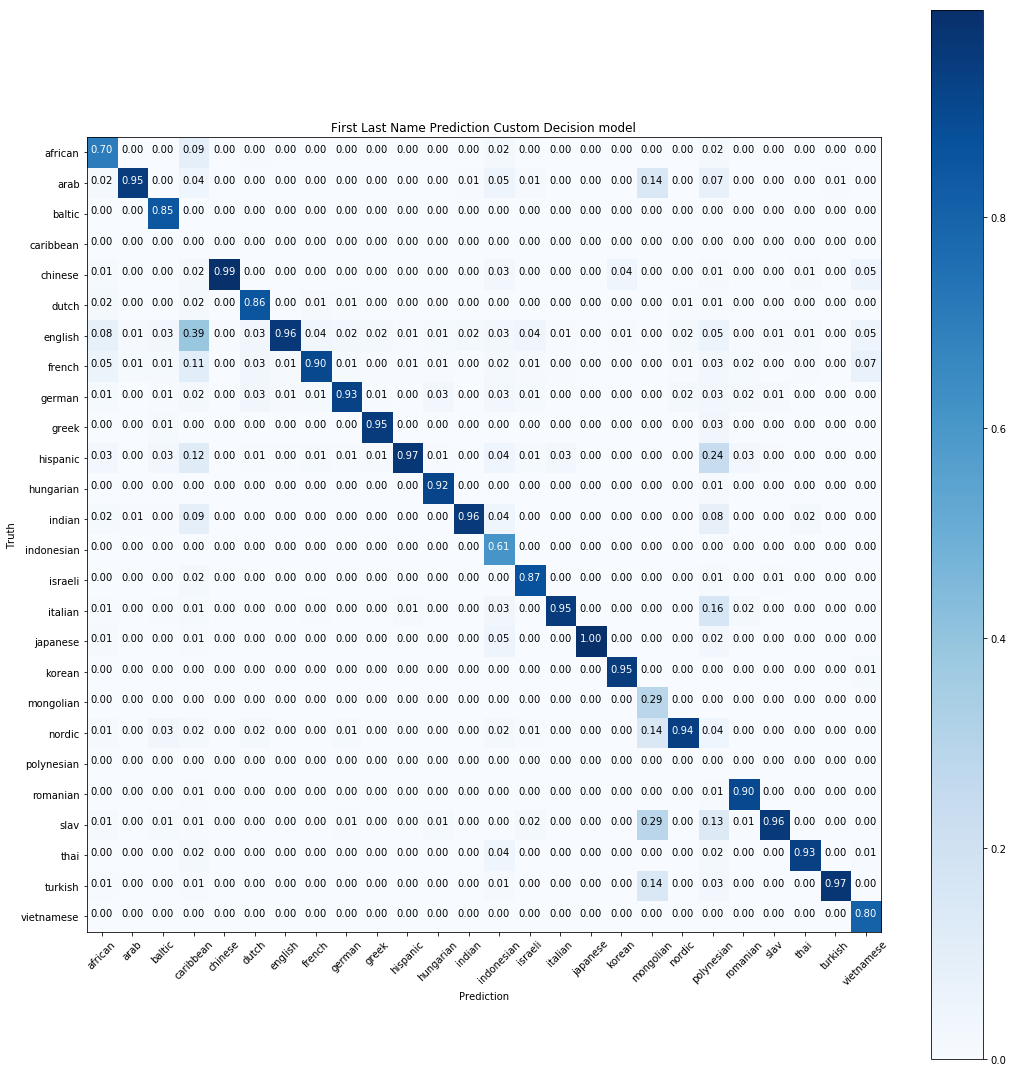

In [386]:
print("{} : {}".format("Prediction Custom Decision",np.sum(np.array(pred_custom_decision)==test_labels)/len(test_labels)))
cnf_matrix = confusion_matrix(test_labels,pred_custom_decision)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                      title="{} model".format("First Last Name Prediction Custom Decision"))

plt.show()

In [385]:
display(conf_table(pred_custom_decision,test_labels))

precision    recall                   precision-1  \
african      0.704573  0.638321     (african, 0.704572803851)   
arab         0.949433  0.894822        (arab, 0.949433061468)   
baltic       0.849206  0.861745      (baltic, 0.849206349206)   
caribbean    0.002320  0.047619     (english, 0.385150812065)   
chinese      0.990920  0.981166     (chinese, 0.990920415888)   
dutch        0.856028  0.873822       (dutch, 0.856028450155)   
english      0.964208  0.968642     (english, 0.964207906457)   
french       0.900739  0.858978      (french, 0.900738807188)   
german       0.925300  0.915465      (german, 0.925300058753)   
greek        0.950922  0.856302       (greek, 0.950922027007)   
hispanic     0.966835  0.875217    (hispanic, 0.966834765605)   
hungarian    0.916496  0.848005   (hungarian, 0.916495550992)   
indian       0.961817  0.904714      (indian, 0.961816664348)   
indonesian   0.605042  0.406780  (indonesian, 0.605042016807)   
israeli      0.869606  0.763676     (israeli, 0.869606150949)   
italian      0.953045  0.838654     (italian, 0.953045180631)   
japanese     0.997378  0.990025    (japanese, 0.997378056528)   
korean       0.948051  0.984500      (korean, 0.948051101551)   
mongolian    0.285714  0.153846        (slav, 0.285714285714)   
nordic       0.938688  0.850520      (nordic, 0.938687561214)   
polynesian   0.000036  0.333333    (hispanic, 0.239257990452)   
romanian     0.902174  0.818003    (romanian, 0.902173913043)   
slav         0.958565  0.841883        (slav, 0.958564893577)   
thai         0.931302  0.838511        (thai, 0.931302455704)   
turkish      0.972760  0.900806     (turkish, 0.972759856631)   
vietnamese   0.803419  0.868762  (vietnamese, 0.803418803419)   

                              precision-2                   precision-3  \
african        (english, 0.0836341756919)     (french, 0.0532490974729)   
arab            (french, 0.0136463099264)   (english, 0.00982693455341)   
baltic          (nordic, 0.0330687830688)    (english, 0.0251322751323)   
caribbean      (hispanic, 0.120649651972)      (french, 0.106728538283)   
chinese       (english, 0.00470748886014)    (korean, 0.00125772603134)   
dutch           (english, 0.034644946656)     (french, 0.0327520936102)   
english        (german, 0.00852488176165)    (french, 0.00831805082526)   
french         (english, 0.0376395459948)     (german, 0.0149858997366)   
german         (english, 0.0234031838402)     (nordic, 0.0138488655121)   
greek          (english, 0.0194569478728)  (hispanic, 0.00842166400465)   
hispanic       (italian, 0.0113466783307)   (english, 0.00643235733031)   
hungarian       (german, 0.0280629705681)       (slav, 0.0126625598905)   
indian         (english, 0.0193698706357)      (arab, 0.00674641813882)   
indonesian        (arab, 0.0504201680672)   (japanese, 0.0504201680672)   
israeli        (english, 0.0393849050683)       (slav, 0.0203985564099)   
italian       (hispanic, 0.0282034810804)   (english, 0.00694380716405)   
japanese    (hispanic, 0.000612171823926)  (english, 0.000485117294432)   
korean         (chinese, 0.0403467605267)   (english, 0.00638769391214)   
mongolian     (mongolian, 0.285714285714)        (arab, 0.142857142857)   
nordic          (german, 0.0220568070519)    (english, 0.0177864838394)   
polynesian      (italian, 0.157913918146)        (slav, 0.126863223878)   
romanian      (hispanic, 0.0260869565217)    (italian, 0.0173913043478)   
slav            (german, 0.0110770859325)   (english, 0.00911118672262)   
thai            (indian, 0.0164749766864)    (english, 0.0136773391358)   
turkish          (arab, 0.00573476702509)     (german, 0.0036866359447)   
vietnamese      (french, 0.0683760683761)    (chinese, 0.0495726495726)   

                                recall-1                        recall-2  \
african        (african, 0.638321068411)     (polynesian, 0.12755519215)   
arab              (arab, 0.894821703101)   (polynesian, 0.0757808691739)   
ba

In [240]:
"""
sample.reset()
nextList = sample.genNext()
first_name_ds_mat = pad_sequences(first_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)        
last_name_ds_mat = pad_sequences(last_trainX.iloc[nextList].apply(lambda x: transform_structure(x)),maxlen=50,value=0.)

preds = first_last_name_model.predict([first_name_ds_mat,last_name_ds_mat,np.zeros((len(nextList),len(pub_keys)))],verbose=True,batch_size=1000)
"""


10000/10004 [============================>.] - ETA: 0s

___
## Confusion Matrix

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


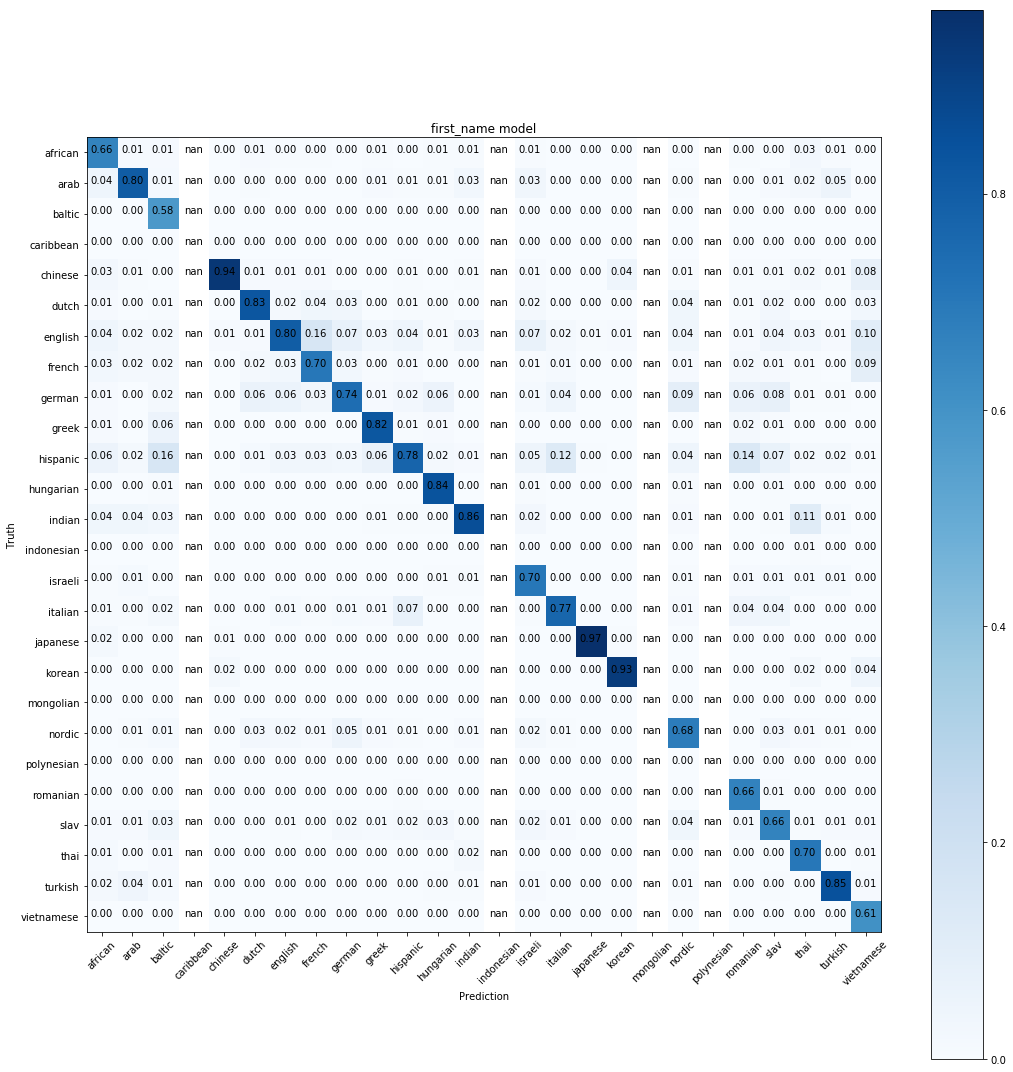

Normalized confusion matrix


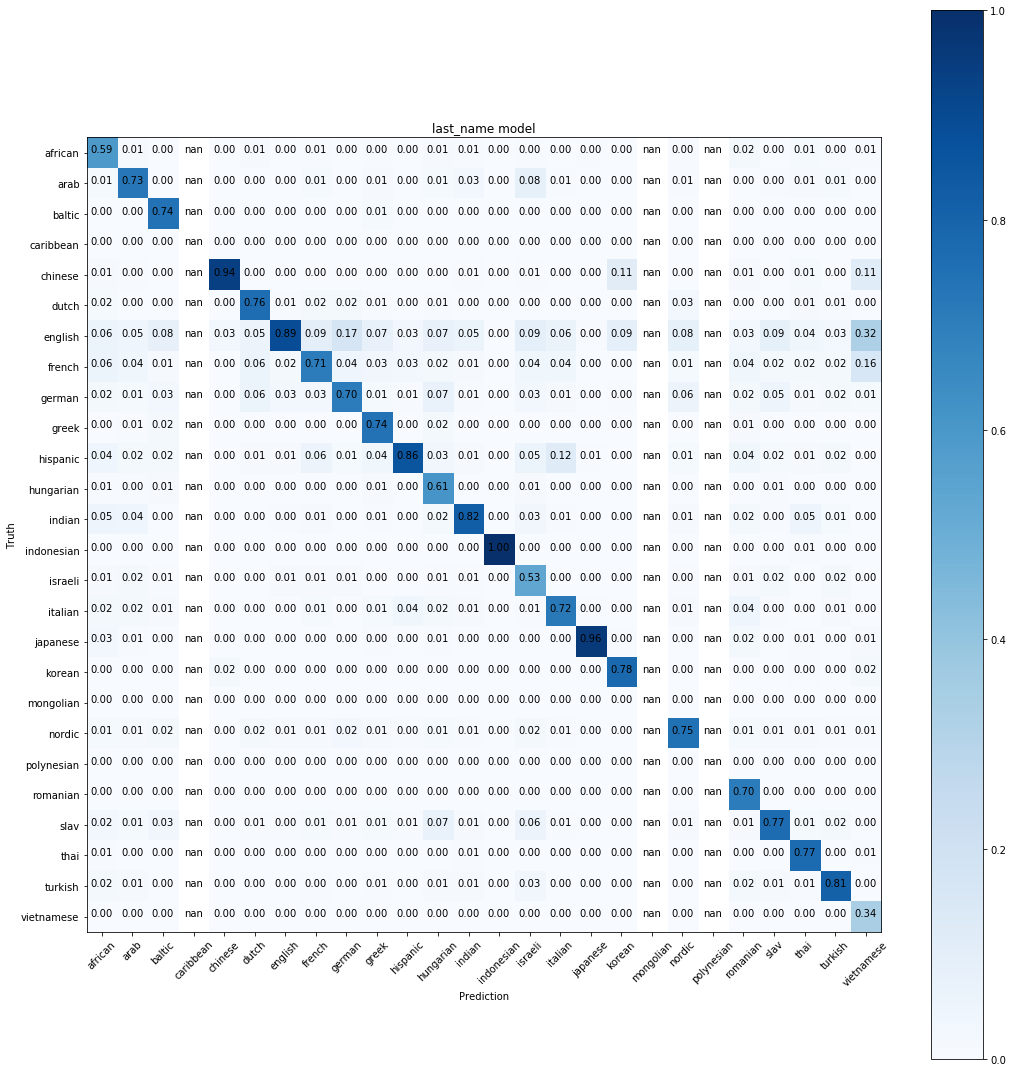

Normalized confusion matrix


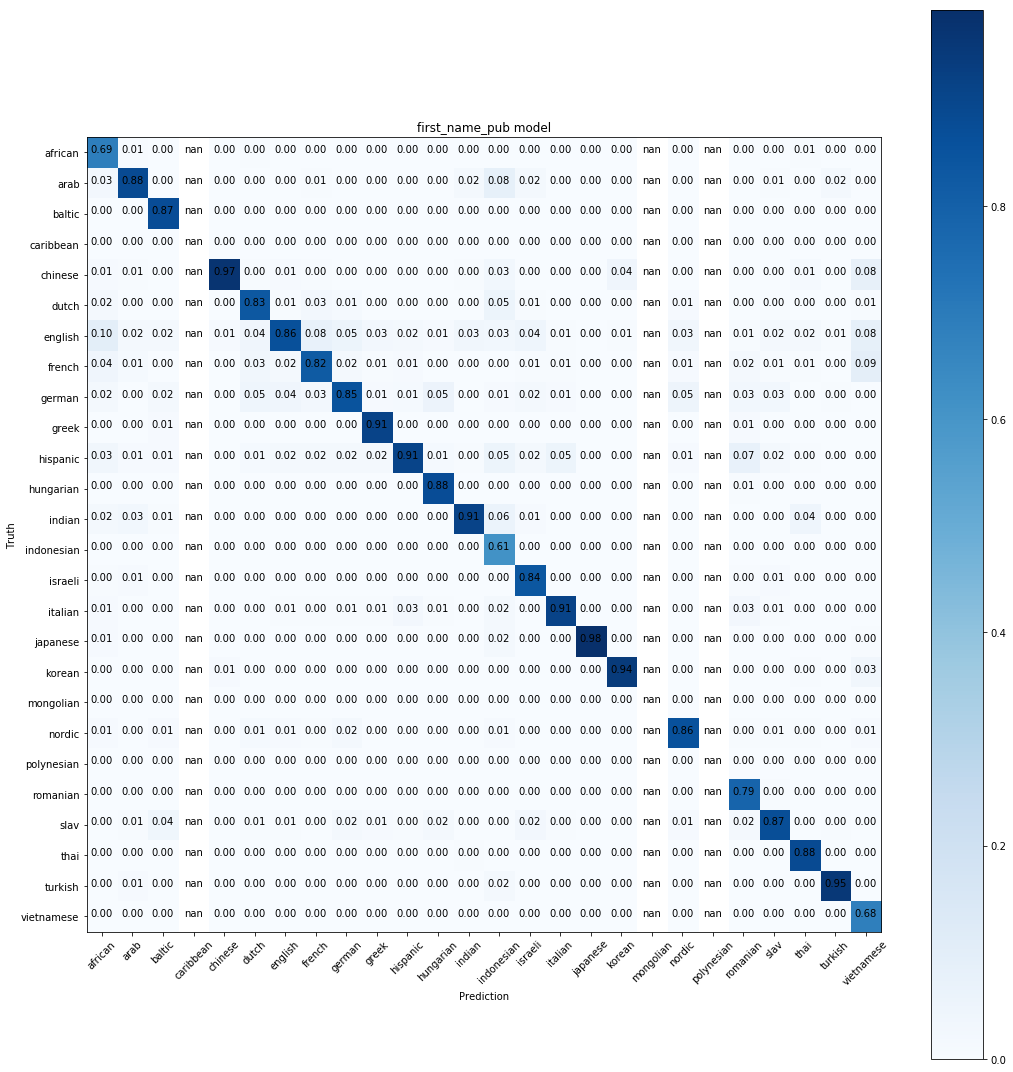

Normalized confusion matrix


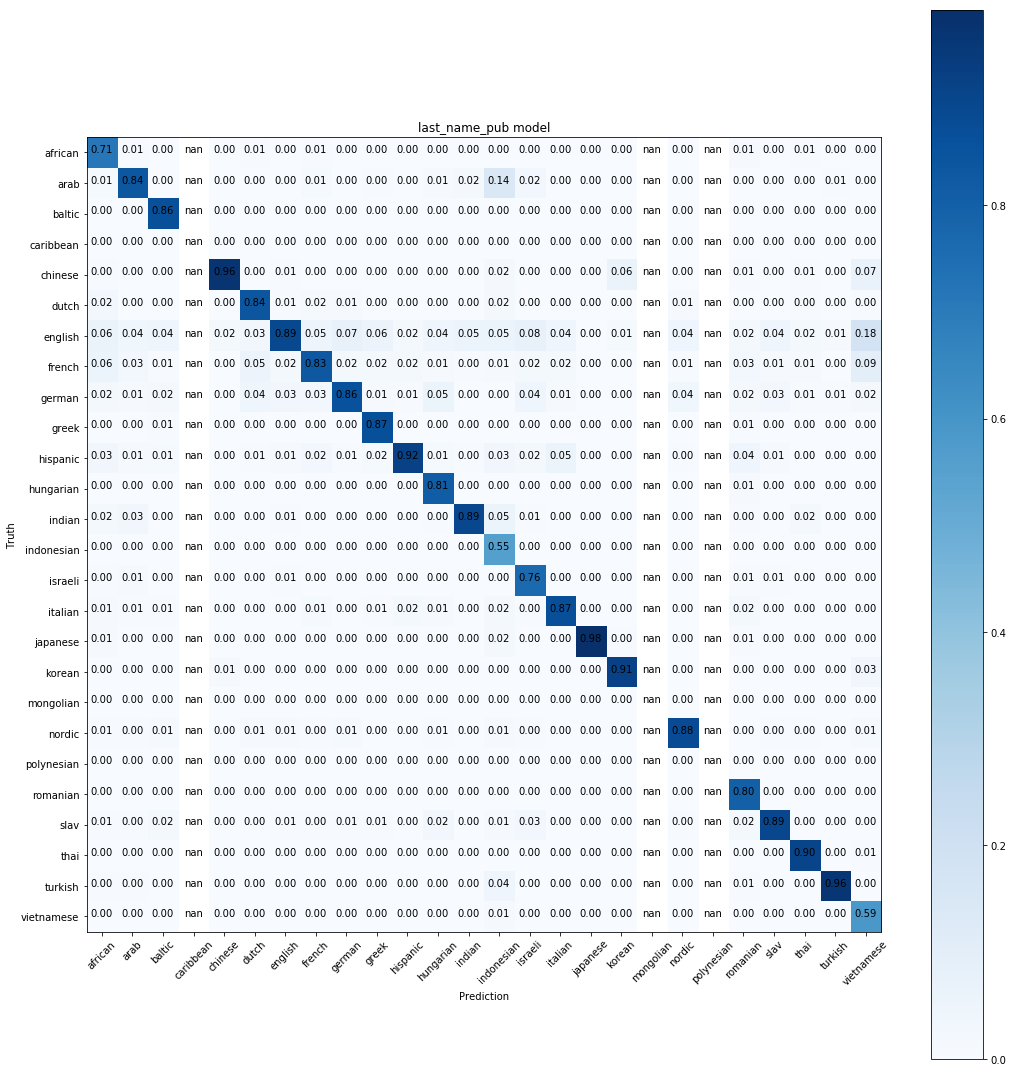

Normalized confusion matrix


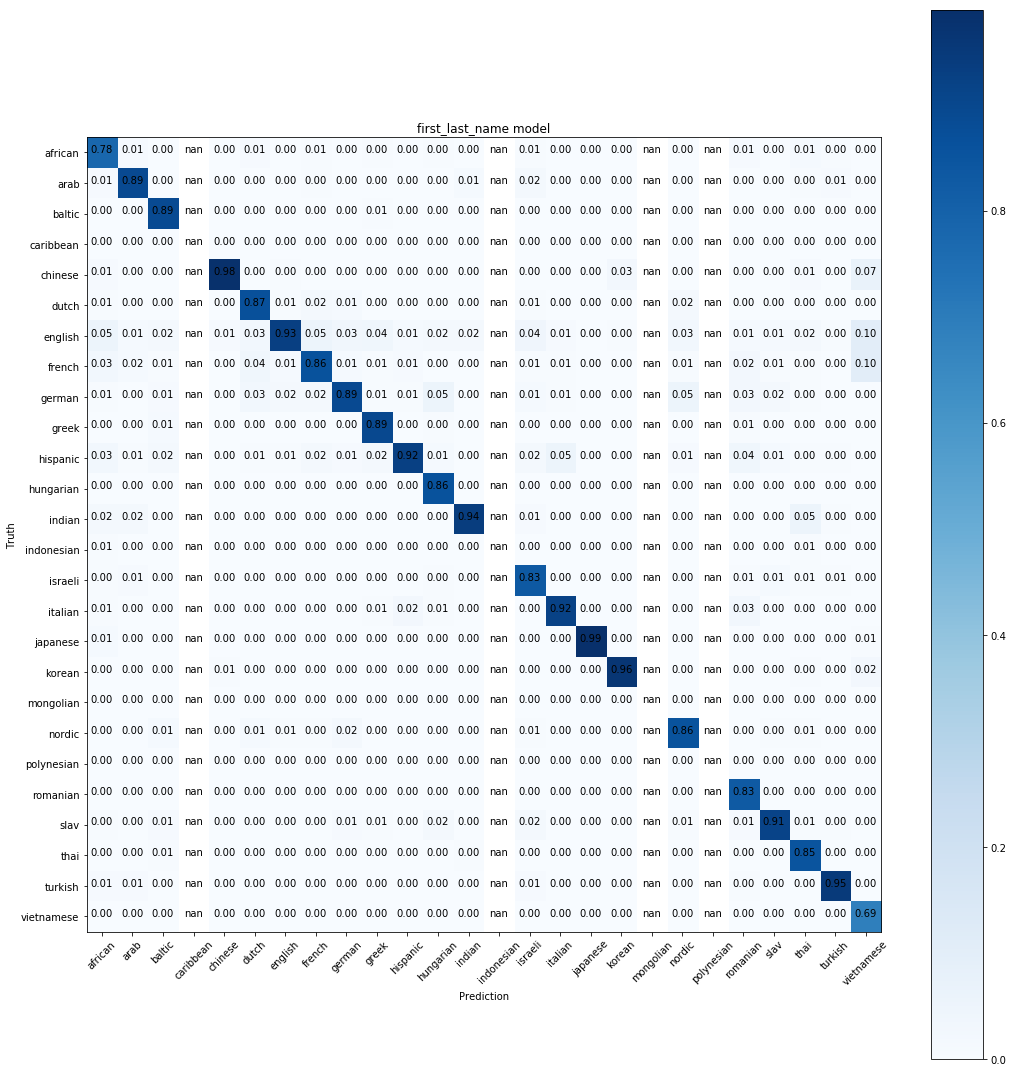

Normalized confusion matrix


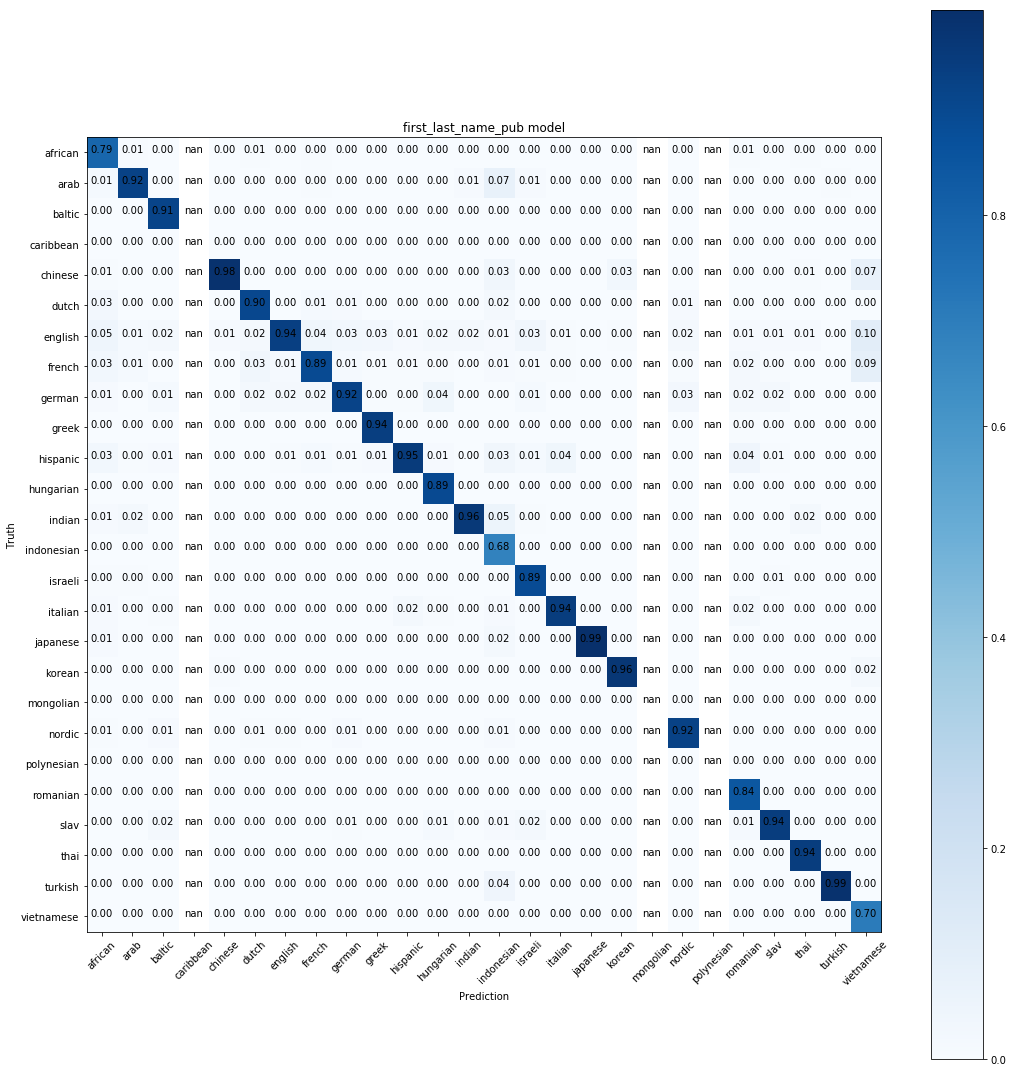

In [34]:
# Compute confusion matrix
for i in range(6):
    cnf_matrix = confusion_matrix(test_labels,pred_class[i])
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

/Volumes/HD-500GB/Users/nikolausn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


Normalized confusion matrix


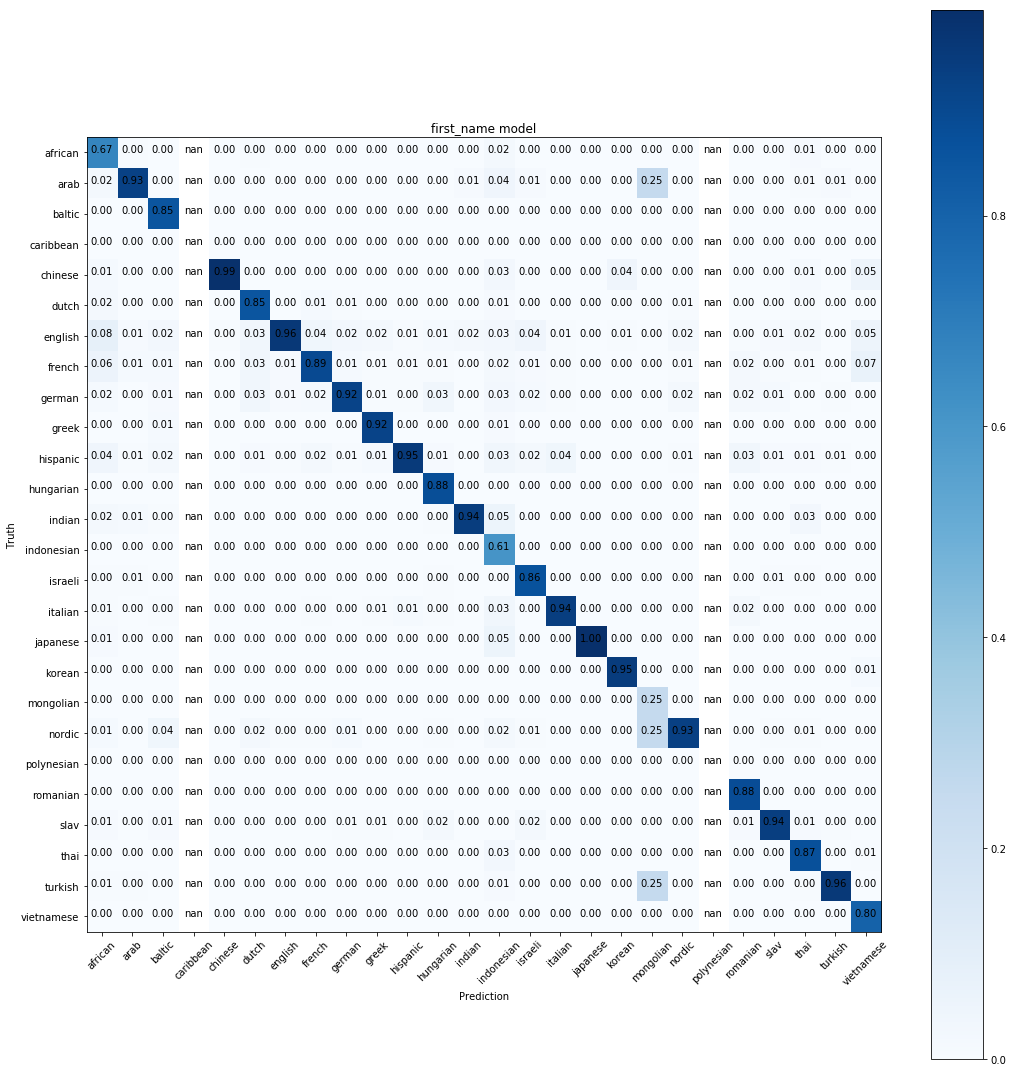

Normalized confusion matrix


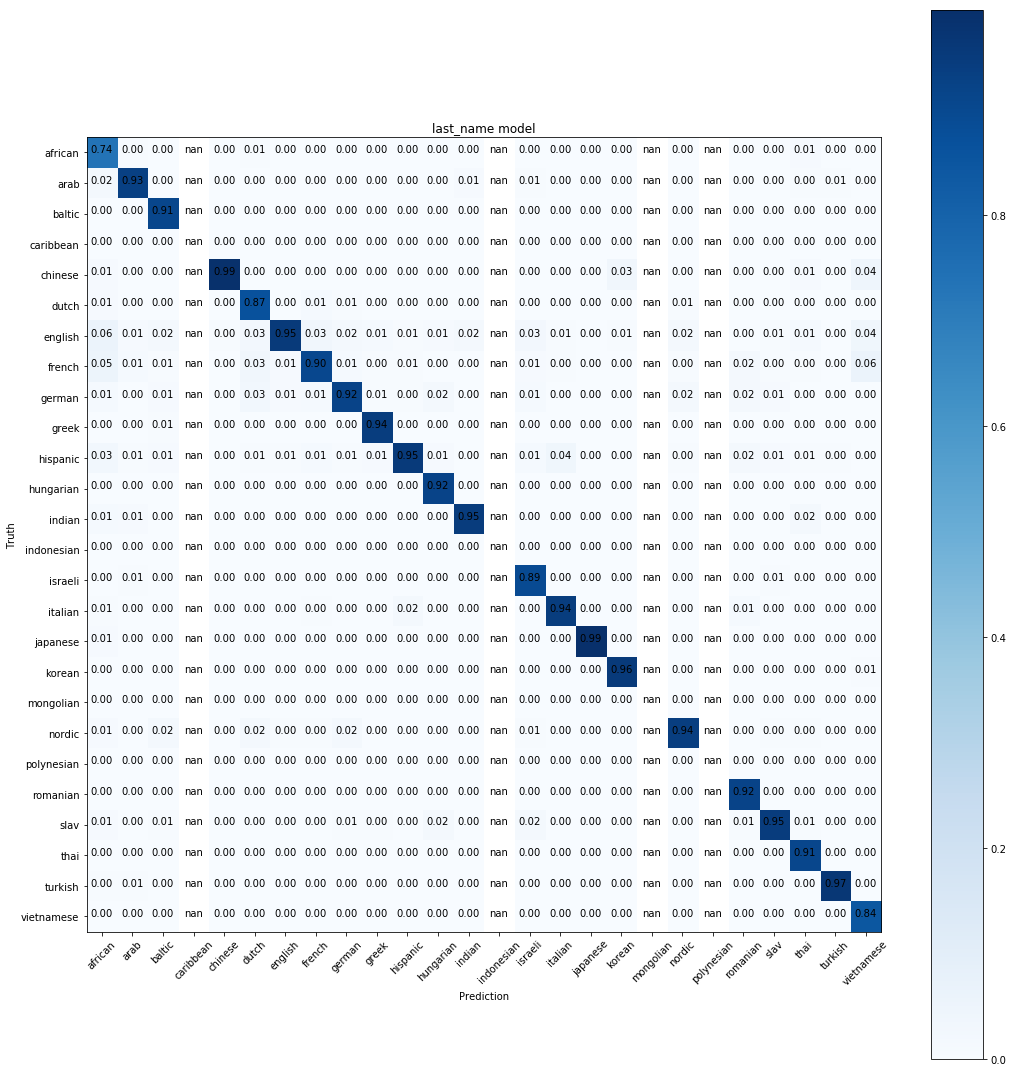

In [284]:
# Compute confusion matrix
for i in range(2):
    cnf_matrix = confusion_matrix(test_labels,pred_class[i])
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
                          title="{} model".format(index[i]))

    plt.show()

In [8]:
# embedd the structure vocabulary using text embedding and reduce the dimensionality

# convert the names into word structure vector
struct_dict_keys = list(struct_dict.keys())

def transform_structure(name_struct):
    list_structure = []
    for x in name_struct:
        try:
            list_structure.append(struct_dict_keys.index(x)+1)
        except BaseException:
            list_structure.append(0)
    #add pading 0 for structure less than num_input
    #for i in range(len(list_structure),timesteps):
    #    list_structure.append(0)
    return list_structure   
    #return [*map(lambda x:struct_dict_keys.index(x)+1, name_struct)]

#data_source = full_name_struct.apply(lambda x: transform_structure(x))

In [9]:
def transform_labels(x):
    y = np.zeros(len(ethnic_keys))
    y[ethnic_keys.index(x)]=1
    return y

labels = np.array(list(map(lambda x: transform_labels(x),ethnic_series)))

In [16]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import pickle

with open('train_test_fix.pickle', 'rb') as f:
    trainX,trainY,testX,testY,ethnic_keys,struct_dict_keys = pickle.load(f)
    #aha = pickle.load(f)

#with open('traintest-smote.pickle','rb') as f:
#    train_res,test_res = pickle.load(f)

with open('ethnic_keys.pickle','rb') as f:
    name_struct_keys,ethnic_keys = pickle.load(f)
        
embedding_vector_length = 1000
lstm_layer = 1000
max_sequence = 50

In [ ]:
# convert categorical to binary crossentropy
#trainY = np.array([np.where(x>0)[0][0] for x in trainY])
#testY = np.array([np.where(x>0)[0][0] for x in testY])

#test_res

In [2]:
model = Sequential()
model.add(Embedding(len(name_struct_keys)+1,embedding_vector_length,input_length=max_sequence))
model.add(Conv1D(filters=embedding_vector_length,kernel_size=3,padding='same',activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(lstm_layer,dropout=0.8))
model.add(Bidirectional(LSTM(max_sequence*2,return_sequences=False),input_shape=(max_sequence,1)))
#model.add(TimeDistributed(keras.layers.Dense(len(ethnic_keys),activation='softmax')))
model.add(keras.layers.Dense(lten(ethnic_keys),activation='softmax'))
#model.add(keras.layers.Dense(len(ethnic_keys),activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
for x in range(10):
    model.fit(trainX,trainY,epochs=1,batch_size=1000)
    scores = model.evaluate(testX,testY,verbose=0)
    print("Accuracy: %.2f%%" %(scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 1000)          62696000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 1000)          3001000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               880800    
_________________________________________________________________
dense_1 (Dense)              (None, 23)                4623      
Total params: 66,582,423
Trainable params: 66,582,423
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
35653/35653 [==============================] - 778s - loss: 1.6879 - acc: 0.5265    
Accuracy: 75.88%
Epoch 1/1
35653/35653 [==============================] - 796s - loss: 0.5197 - acc: 0.8582    
Accuracy: 84.37%
Epoch 1/1
35653/35653 [==========

In [4]:
testX

array([[  112,  1331,  1332, ...,     0,     0,     0],
       [  251,   252,   232, ...,     0,     0,     0],
       [ 4633, 11731, 23123, ...,     0,     0,     0],
       ..., 
       [  696,   697,   698, ...,     0,     0,     0],
       [   25,    26,  5195, ...,     0,     0,     0],
       [ 8671,  8672,  6568, ...,     0,     0,     0]], dtype=int32)

In [91]:
# store the predictions probabilities, predictions and labels
"""
# make a confusion matrix
pred = loaded_model.predict([first_testX,last_testX])
# pred probability distribution

pred_class = np.array([np.argsort(x)[::-1][0] for x in pred])
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

pred_prob = []
predictions = []
"""

def evaluate_probs(firstX, lastX, testY, testIndex, mini_batch_size=20000):
    test_class = []
    pred_class = []    
    pred_prob = []
    
    test_len = len(testY)
    len_mini_batch = round(test_len/mini_batch_size)+1
    print(len_mini_batch)
    for i in range(len_mini_batch):
        print(i)
        y_first_trainX,y_last_trainX,batch_range = generate_batch(firstX,lastX,i,mini_batch_size)
        #pub_country = np.array(list(map(lambda x: transform_labels(x,pub_keys), pub_series[testIndex].iloc[batch_range])))        
        pred = model.predict([y_first_trainX,y_last_trainX])
        pred_class_inn =  [np.argsort(x)[::-1][0] for x in pred]
        pred_class.extend(pred_class_inn)
        pred_prob.extend([x[np.argsort(x)[::-1][0]] for x in pred])
    return pred_class,pred_prob
    #scores = model.evaluate([first_testX, last_testX],testY,verbose=0)
    

In [92]:
#pred_class, pred_prob = evaluate_probs(first_testX[0:100],last_testX[0:100], testY[0:100], testIndex)
pred_class, pred_prob = evaluate_probs(first_testX,last_testX, testY, testIndex)

45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


(array([  2.07000000e+02,   2.28700000e+03,   7.56300000e+03,
          1.39370000e+04,   2.28850000e+04,   2.34090000e+04,
          2.51430000e+04,   3.02170000e+04,   4.46390000e+04,
          7.16530000e+05]),
 array([ 0.14609675,  0.23148708,  0.3168774 ,  0.40226773,  0.48765805,
         0.57304838,  0.6584387 ,  0.74382903,  0.82921935,  0.91460968,  1.        ]),
 <a list of 10 Patch objects>)

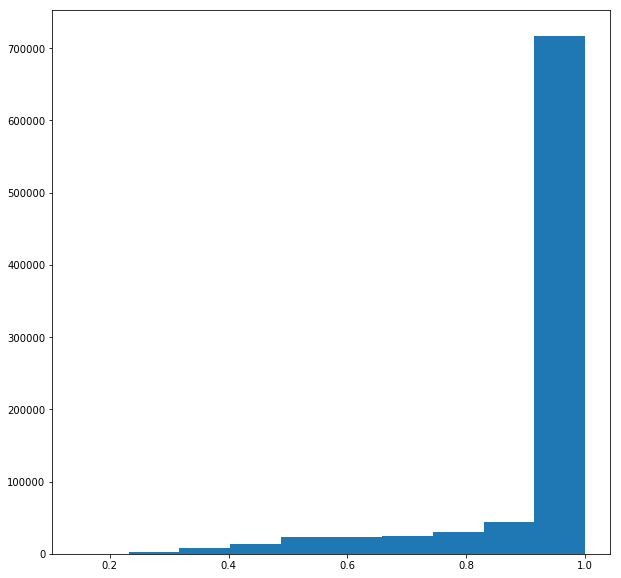

In [95]:
fig,ax = plt.subplots(figsize=(10,10))
ax.hist(pred_prob)

In [102]:
pred_class = np.array(pred_class)
test_labels = np.array([np.argsort(x)[::-1][0] for x in testY])
predicting_error = test_labels[np.where(pred_class != test_labels)]
class_error = pred_class[np.where(pred_class != test_labels)]

Confusion matrix, without normalization


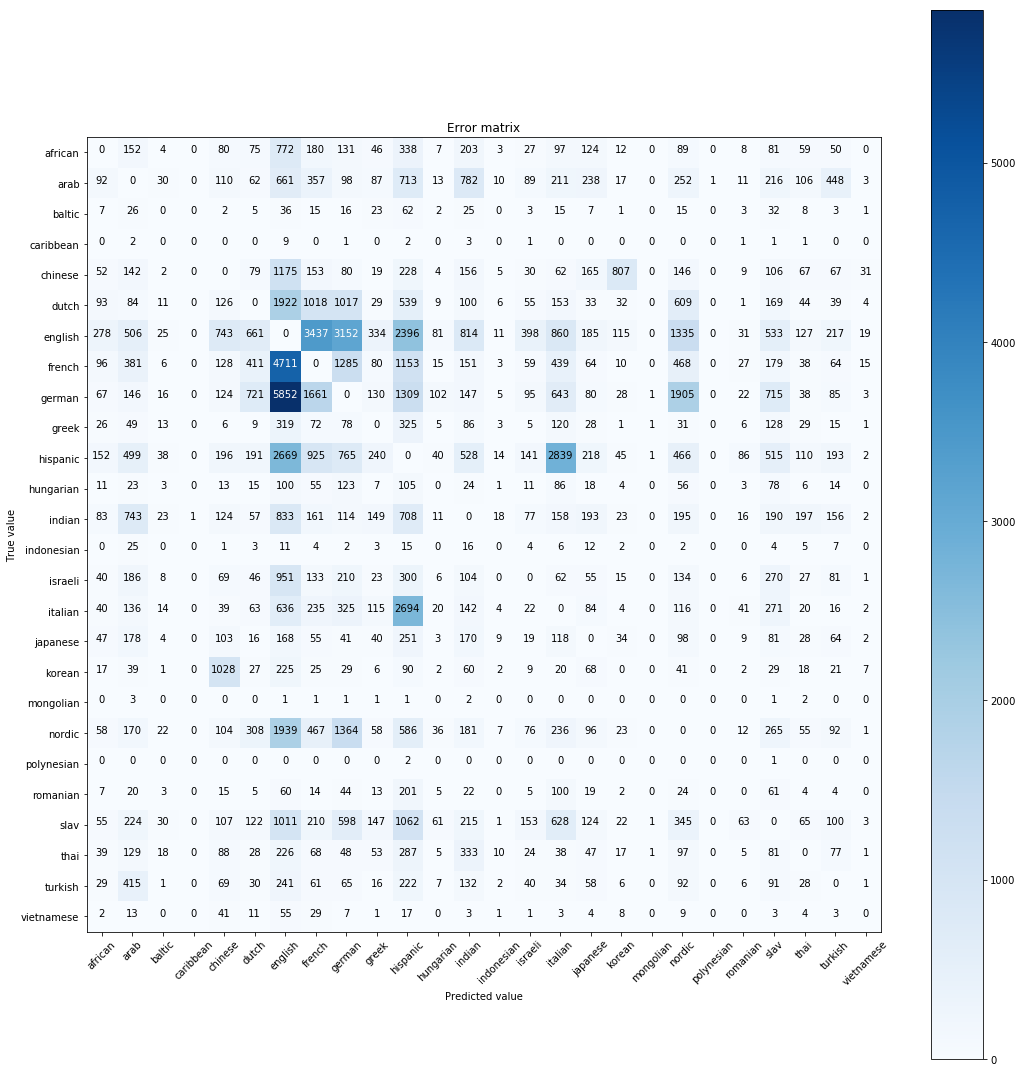

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')

# Compute confusion matrix
cnf_matrix = confusion_matrix(predicting_error, class_error)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=ethnic_keys,
                      title='Error matrix')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=ethnic_keys, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [111]:
len(struct_dict_keys)

725

In [112]:
struct_dict_keys

['_c',
 'ca',
 'am',
 'me',
 'er',
 'ro',
 'on',
 'n_',
 '_b',
 'be',
 'rt',
 't_',
 '_l',
 'le',
 'ee',
 'en',
 '_e',
 'es',
 'st',
 'th',
 'he',
 'r_',
 'el',
 'll',
 '_p',
 'pe',
 'et',
 'te',
 '_g',
 'ge',
 '_m',
 'ma',
 'ax',
 'x_',
 '_k',
 'kh',
 'ha',
 'al',
 'ed',
 'd_',
 'la',
 'an',
 'ni',
 'ie',
 'e_',
 'eu',
 'un',
 'ic',
 'ce',
 'ch',
 'hr',
 'ri',
 'is',
 'to',
 'op',
 'ph',
 '_j',
 'jo',
 'oo',
 'os',
 '_i',
 'ia',
 'ka',
 'at',
 'hl',
 '_t',
 'rr',
 're',
 'nc',
 'ju',
 'ul',
 'li',
 'iu',
 'us',
 's_',
 '_a',
 'mr',
 'mi',
 'ig',
 'gu',
 'ue',
 'l_',
 '_n',
 'ne',
 'ei',
 'il',
 'je',
 'oe',
 '_h',
 'hy',
 'yu',
 'ah',
 'h_',
 'ar',
 'rk',
 'k_',
 'ab',
 'bd',
 '_s',
 'se',
 'rg',
 'gi',
 'io',
 'o_',
 'uu',
 'dr',
 'pa',
 'au',
 'ja',
 'ik',
 'ke',
 'mu',
 'ir',
 'na',
 '_r',
 'rd',
 'rn',
 'ns',
 'as',
 'sw',
 'wa',
 'nt',
 'ur',
 '_d',
 'de',
 'og',
 'ho',
 'or',
 'ra',
 'ay',
 'ya',
 'a_',
 'em',
 'ad',
 'ak',
 'su',
 'u_',
 '_y',
 'yo',
 'ou',
 'si',
 'if',
 'f_',